In [1]:
from astropy.io import ascii
import matplotlib.tri as tri
import numpy as np
import pandas as pd
from astropy.io import fits
from glob import glob
from joblib import Parallel, delayed
from multiprocessing import  Pool
from astropy.io import ascii
from astropy.table import Table
import matplotlib.pyplot as plt
from scipy import interpolate
from matplotlib.colors import LogNorm
%matplotlib inline
import os
import numpy as np
from matplotlib import pyplot as plt
from IPython.display import clear_output
from time import sleep
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)
from scipy.optimize import curve_fit
# Import
from pandarallel import pandarallel
from scipy.interpolate import interp1d
# Initialization
pandarallel.initialize(nb_workers=22)

INFO: Pandarallel will run on 22 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [2]:
plt.style.use('/home/luuk/Documents/MNRAS_Style.mplstyle')
def interp_func(x, bins, delta, running_median):
    f = interpolate.interp1d(x=bins-delta/2,y=running_median, fill_value='extrapolate')
    return f(x)

In [3]:
# Import Master Catalogue
df_master = ascii.read('./data/MASTER_CATALOG/LOGR.XYVIQ1').to_pandas()

In [4]:
# Import KS2 --> Giacomo numbers
KS2_Guido = ascii.read('./coinc.tab').to_pandas()
KS2_Guido.columns = ['ROWID','ID','KS2_ID','NS']
#KS2_Guido['KS2_ID'] +=1
KS2_Guido = KS2_Guido.set_index('KS2_ID')['ID']
KS2_Guido = KS2_Guido[KS2_Guido!=0]
KS2_Guido = KS2_Guido[KS2_Guido.index!=0]
KS2_Guido = KS2_Guido.sort_index()

In [5]:
# Read Giacomo catalogue
wfc3_catalogue = Table.read('./match_Giacomo/30dor_all_newerr.UBVIHa.rot', format='ascii').to_pandas()
wfc3_catalogue.columns = 'ID;x;y;RA;Dec;u_1;eu_2;b_1;eb_2;v_1;ev_2;i_1;ei_2;ha_1;eha_2'.split(';')
wfc3_catalogue = wfc3_catalogue.set_index('ID')

In [6]:
pms = ascii.read('../30dorallpmsstars.txt').to_pandas()
distances = np.sqrt((pms.X.values - wfc3_catalogue.x.values[:,np.newaxis])**2+(pms.Y.values - wfc3_catalogue.y.values[:,np.newaxis])**2).T
argmins  = np.argmin(distances, axis=1)
mindists = np.min(distances, axis=1)
argmins = argmins[mindists<0.5]
pms_stars = wfc3_catalogue.iloc[argmins]
pms_ids=pms_stars.index
pms_ids


Int64Index([   39,   151,   181,   202,   325,   404,   422,   424,   444,
              610,
            ...
             4806,  7434,  8632,  5324,  6260,  5922, 12335,  6536,  5507,
            12885],
           dtype='int64', name='ID', length=1396)

In [7]:
#Column 1: x coordinates in pixel
#Column 2: y coordinates in pixel

#Columns 5 to 10 correspond to the filter F555W:

#C5: flux - when you convert it into magnitude you have to keep in mind that there are zero values and negative values: zero values correspond to the position of saturated stars that KS2 was not able 	to measure, while negative values correspond to sources that in that filter where below the detection threshold. 
#C6: rms of the flux (if in a filter a source was found in less than 3 exposures the value is 9999.900)
#C7: Quality of the fit, it ranges from 0 to 1, the higher the better
#C8: gives you an estimate of the crowding around your source (I never found an effective way to use it)
#C9:  number of exposures where the source is expected to be found
#C10: number of exposures where the source is found (C10<=C9)
#The following columns are the same but for the filters: F814W, F438W, F336W, and F656N

In [8]:
def give_names(df_master):# Get readable column names
    colnames = df_master.shape[1]*['']
    colnames[0] = 'X'
    colnames[1] = 'Y'
    colnames[2] = 'col3'
    colnames[3] = 'col4'
    filters = ['F555W','F814W','F438W','F336W','F656N']
    for i,filt in enumerate(filters):
        colnames[4+i*6] = 'flux_'+filt
        colnames[5+i*6] = 'rms_'+filt
        colnames[6+i*6] = 'Q_'+filt
        colnames[7+i*6] = 'crowd_'+filt
        colnames[8+i*6] = 'nEXPexp_'+filt
        colnames[9+i*6] = 'nEXPfound_'+filt
    return colnames
df_master.columns = give_names(df_master)

In [9]:
df_master = df_master.sort_values(by=['X','Y'])
df_master['ID'] = np.arange(1,len(df_master)+1)
df_master = df_master.set_index('ID')
df_master.head(4)

# Assign instrumental magnitudes (uncalibrated)
# Get magnitudes
filters= ['F336W','F438W','F555W','F814W','F656N']
for i,filt in enumerate(filters):
    df_master['instr_m_'+filt] = -2.5*np.log10(df_master['flux_'+filt])
    
filters= ['F336W','F438W','F555W','F814W','F656N']
for i,filt in enumerate(filters):
    df_master['em_'+filt] = 1.1 * (df_master['rms_'+filt]/df_master['flux_'+filt])

/home/luuk/anaconda3/lib/python3.8/site-packages/pandas/core/series.py:679: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/luuk/anaconda3/lib/python3.8/site-packages/pandas/core/series.py:679: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [10]:
df_master = pd.merge(df_master, KS2_Guido, left_index=True,right_index=True,how='inner').set_index('ID').sort_index()

In [11]:
def match_stars():
    # Get corresponding stars
    matched_stars = pd.DataFrame({'X_KS2':[],'Y_KS2':[],'ID_KS2':[],'X_drz':[],'Y_drz':[],'ID_drz':[]})
    matched_stars.loc[1]=[2492.5,1957,np.nan,2266.122,2770.384,np.nan]
    matched_stars.loc[2]=[2444,2093.8,np.nan,2280.107,2623.06,np.nan]
    matched_stars.loc[3]=[2336.1,2010.3,np.nan,2407.609,2678.784,np.nan]
    matched_stars.loc[4]=[2405.4,1917.8,np.nan,2362.028,2787.537,np.nan]
    matched_stars.loc[5]=[2282.1,2189.1,np.nan,2416.542,2488.537,np.nan]
    matched_stars.loc[6]=[2452.9,2058.6,np.nan,2280.11,2660.028,np.nan]
    matched_stars.loc[7]=[2346.8,2216.3,np.nan,2345.779,2477.712,np.nan]
    matched_stars.loc[8]=[2465.3,2580.5,np.nan,2138.144,2146.996,np.nan]
    matched_stars.loc[9]=[2417.3,2585.7,np.nan,2184.342,2129.948,np.nan]
    #matched_stars.loc[10]=[2469.9,2415,np.nan,2174.658,2411.817,np.nan]
    matched_stars.loc[11]=[2574.2,2402.2,np.nan,2074.687,2350.373,np.nan]
    matched_stars.loc[12]=[2472.4,2359.7,np.nan,2185.949,2367.119,np.nan]
    matched_stars.loc[13]=[2924,3787.7,np.nan,1384.584,1067.123,np.nan]
    matched_stars.loc[14]=[2910.9,3725.8,np.nan,1412.916,1125.03,np.nan]
    matched_stars.loc[15]=[2911.2,3783.9,np.nan,1398.189,1067.722,np.nan]
    matched_stars.loc[16]=[3619,3644.1,np.nan,732.933,1381.767,np.nan]
    matched_stars.loc[17]=[2369.4,2112.5,np.nan,2349.221,2585.771,np.nan]
    matched_stars.loc[18]=[2375.8,1995.1,np.nan,2372.108,2703.594,np.nan]
    matched_stars.loc[19]=[2322,1978.1,np.nan,2429.523,2707.162,np.nan]
    matched_stars.loc[20]=[2297.1,1915.1,np.nan,2469.752,2763.147,np.nan]

    d_KS2 = np.sqrt((matched_stars.X_KS2.values - df_master.X.values.reshape(-1,1))**2+
            (matched_stars.Y_KS2.values - df_master.Y.values.reshape(-1,1))**2)
    d_drz = np.sqrt((matched_stars.X_drz.values - wfc3_catalogue.x.values.reshape(-1,1))**2+
            (matched_stars.Y_drz.values - wfc3_catalogue.y.values.reshape(-1,1))**2)

    matched_stars['ID_KS2'] = np.argmin(d_KS2,axis=0)+1
    matched_stars['ID_drz'] = np.argmin(d_drz,axis=0)+1
    return matched_stars
matched_stars = match_stars()

/home/luuk/anaconda3/lib/python3.8/site-packages/pandas/core/computation/expressions.py:177: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  warnings.warn(
/home/luuk/anaconda3/lib/python3.8/site-packages/pandas/core/computation/expressions.py:177: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  warnings.warn(
/home/luuk/anaconda3/lib/python3.8/site-packages/pandas/core/computation/expressions.py:177: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  warnings.warn(
/home/luuk/anaconda3/lib/python3.8/site-packages/pandas/core/computation/expressions.py:177: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  warnings.warn(
/home/luuk/anaconda3/lib/python3.8/site-pack

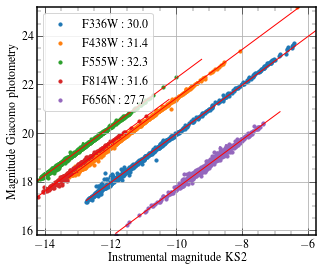

In [12]:
# Get Magnitude zeropoints
def MZP_func(x,MZP):
    return x+MZP
def derive_MZPs():
    plt.figure()
    MZP_dict = {}
    for filter_ in ['F336W','F438W','F555W','F814W','F656N']:
        col1 = 'instr_m_'+filter_
        col2 = {'F336W':'u_1','F438W':'b_1','F555W':'v_1','F814W':'i_1','F656N':'ha_1'}[filter_]
        col3 = {'F336W':'eu_2','F438W':'eb_2','F555W':'ev_2','F814W':'ei_2','F656N':'eha_2'}[filter_]
        matched_stars = df_master[(df_master['Q_F555W']>0.98)&(df_master['Q_F656N']>0.98)].index
        x = df_master.loc[matched_stars][col1]
        y = wfc3_catalogue.loc[matched_stars][col2]
        sigma = wfc3_catalogue.loc[matched_stars][col3]
        keep = np.isfinite(x).values * (np.abs(sigma)<0.05) * y>0
        x = x.values[keep]
        y = y.values[keep]
        sigma = sigma.values[keep]
        MZP = curve_fit(MZP_func,x,y,sigma=sigma)[0][0]
        plt.plot(np.arange(x.min(),x.max()+1),np.arange(x.min(),x.max()+1)+MZP,color='red',lw=1)
        plt.scatter(x,y,s=10,label=filter_ + ' : ' + str(np.round(MZP,1)))
        plt.errorbar(x,y,yerr=sigma,linestyle='none')
        plt.xlabel('Instrumental magnitude KS2')
        plt.ylabel('Magnitude Giacomo photometry')
        MZP_dict[filter_] = MZP
    plt.legend()
    plt.savefig('MZP_KS2.png',dpi=500)
    return MZP_dict
MZP_dict = derive_MZPs()

In [13]:
# Update true magnitudes
for i,filt in enumerate(filters):
    df_master['m_'+filt] = -2.5*np.log10(df_master['flux_'+filt]) + MZP_dict[filt]

# Export updated dataframe
df_master = df_master.drop([w for w in df_master.columns if 'instr' in w],axis=1)
df_master.to_csv('Master_catalogue_updatedMZP.csv')

/home/luuk/anaconda3/lib/python3.8/site-packages/pandas/core/series.py:679: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/luuk/anaconda3/lib/python3.8/site-packages/pandas/core/series.py:679: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


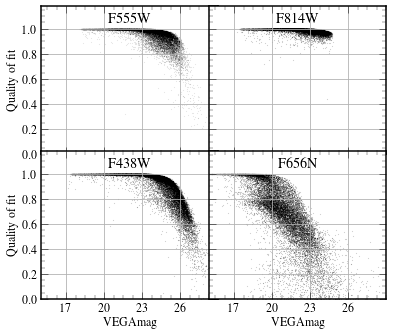

In [14]:
def Q_plot():
    fig,((ax1,ax2),(ax3,ax4)) = plt.subplots(2,2,sharex=True,sharey=True)
    ax1.scatter(df_master.m_F555W,df_master.Q_F555W,s=0.004,marker='.',color='black',facecolor='black')
    ax2.scatter(df_master.m_F814W,df_master.Q_F814W,s=0.004,color='black',facecolor='black')
    ax4.scatter(df_master.m_F656N,df_master.Q_F656N,s=0.004,color='black',facecolor='black')
    ax3.scatter(df_master.m_F438W,df_master.Q_F438W,s=0.004,color='black',facecolor='black')
    
    ax3.set_xlabel('VEGAmag')
    ax4.set_xlabel('VEGAmag')
    ax1.set_ylabel(r'Quality of fit')
    ax3.set_ylabel(r'Quality of fit')
    ax1.set_title('F555W',y=0.85)
    ax2.set_title('F814W',y=0.85)
    ax4.set_title('F656N',y=0.85)
    ax3.set_title('F438W',y=0.85)
    for ax in [ax1,ax2,ax3,ax4]:
        ax.set_ylim(0,1.18)
        #ax.grid()
        ax.set_xticks(np.arange(17,27,3))
        ax.set_xlim(15,29)
    plt.tight_layout(pad=-.8)
    plt.savefig('Qplot.pdf',bbox_inches='tight')
    plt.show()
Q_plot()

In [138]:
KsollPMS = pd.read_csv('../Ksoll_HTTP_PMS_p_mean_0_5/HTTP_PMS_p_mean_0_5.csv')
KsollPMS['ID'] = KsollPMS['ID']
KsollPMS = KsollPMS.set_index('ID')

In [139]:
KsollPMS = pd.merge(KsollPMS,MyID_ACS_ID,left_index=True,right_index=True).set_index('WFC3_ID')

In [140]:
KsollPMS_IDs = KsollPMS.index.values

In [15]:
# Get the time resolved catalogue
# Match on positions
def get_XY_to_ID():
    XY2ID = df_master.X.round(1).astype(str) + '_' + df_master.Y.round(1).astype(str)
    XY2ID = pd.DataFrame(XY2ID)
    XY2ID = XY2ID.reset_index()
    XY2ID.columns = ['ID','str']
    XY2ID = XY2ID.set_index('str')
    return XY2ID
XY2ID = get_XY_to_ID()
XY2ID.head(3)

,ID
str,
412.7_1580.1,1
1369.0_1423.7,2
3095.6_2460.0,3


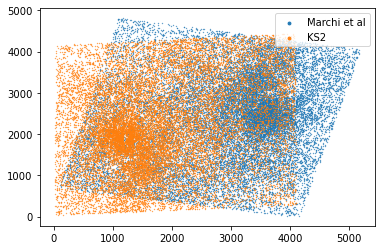

In [15]:
plt.scatter(wfc3_catalogue.x,wfc3_catalogue.y,s=0.1,label='Marchi et al')
plt.scatter(df_master.X,df_master.Y,s=0.1,label='KS2')
ldg_ = plt.legend(markerscale=9)

In [343]:
from joblib import Parallel, delayed
obstable= pd.read_csv('obstable.csv').set_index('OBSERVATION_ID')

def reader(f):
    df = ascii.read(f).to_pandas()
    df.columns = ['X','Y','col3','col4','flux','rms','Q','Crowd','nEXPexp','nEXPfound']
    df = df[df.Q>=0.01]
    df = df.sort_values(by=['X','Y'])
    df['ID'] = XY2ID.reindex(df.X.round(1).astype(str) + '_' + df.Y.round(1).astype(str)).values
    exp_name = f.split('/')[2]
    filter_ = obstable.loc[exp_name]['FILTER']
    obstime = obstable.loc[exp_name]['START_TIME']
    exptime = obstable.loc[exp_name]['EXPOSURE_DURATION']

    df['Filter'] = filter_
    df['ObsStart'] = obstime
    df['ExpTime'] = exptime
    df['OBS_ID'] = exp_name
    df['mag'] = -2.5*np.log10(df.flux) + MZP_dict[filter_]
    df['emagP'] = 1.1 * np.sqrt(df.flux)/df.flux
    df = df[['OBS_ID','Filter','ObsStart','ExpTime','X','Y','flux','Q','Crowd','ID','mag','emagP']]
    return df

def build_time_resolved_df():
    # Now get catalogue of all individual exposures
    flist = glob('./data/ib*/LOGD.XYVIQ1')
    expnames = [w.split('/')[2] for w in flist]
    obstable= pd.read_csv('obstable.csv').set_index('OBSERVATION_ID')
    
    df_phot = pd.DataFrame({'OBS_ID':[],'Filter':[],'ObsStart':[],'ExpTime':[],'X':[],'Y':[],
                        'flux':[],'Q':[],'Crowd':[], 'ID':[], 'mag':[], 'emagP':[]})
    
    photlist = Parallel(n_jobs=22)(delayed(reader)(f) for f in flist)
    df_phot = pd.concat(photlist)
    df_phot = df_phot.dropna().set_index(['ID','Filter']).sort_index()
    
    df_phot['EpochNR'] = df_phot.OBS_ID.apply(lambda x: x[-4])
    print('Converting to datetimes')
    df_phot['ObsStart'] = pd.to_datetime(df_phot.ObsStart)
    print('Converting to Juliandates')
    df_phot['JulianDate'] = df_phot.ObsStart.parallel_apply(lambda x:x.to_julian_date())
    return df_phot
df_phot = build_time_resolved_df()

KeyboardInterrupt: 

In [287]:
# Export / save time resolved photometry
df_phot.to_pickle('KS2_timeresolved.pickle')
df_phot.to_csv('KS2_timeresolved.csv')

In [ ]:
df_phot = pd.read_pickle('KS2_timeresolved.pickle')

In [55]:
df_phot_noclean = pd.read_pickle('KS2_timeresolved.pickle')

In [423]:
def get_error_from_consequtive(df):
    to_use = df.groupby(['ID','Filter','EpochNR']).ObsStart.nunique()
    df = df.reset_index().set_index(['ID','Filter','EpochNR'])
    df = df.loc[to_use.index]
    emag  = df.groupby(['ID','Filter','EpochNR']).mag.std()
    mag   = df.groupby(['ID','Filter','EpochNR']).mag.median()
    time  = df.groupby(['ID','Filter','EpochNR']).JulianDate.mean()
    Qmin  = df.groupby(['ID','Filter','EpochNR']).Q.min()
    Qmax  = df.groupby(['ID','Filter','EpochNR']).Q.max()
    Q     = df.groupby(['ID','Filter','EpochNR']).Q.mean()
    emagP = df.groupby(['ID','Filter','EpochNR']).emagP.median()
    concat_df = pd.DataFrame({'mag':mag,'emag':emag,'ObsTime':time,'Qmin':Qmin,'Qmax':Qmax,'Q':Q,'emagP':emagP})
    return concat_df
visit_errors = get_error_from_consequtive(df_phot)
df_phot = pd.merge(df_phot,visit_errors['emag'],left_on=['ID','Filter','EpochNR'],right_index=True)

In [424]:
# Get maximum value inside aperture of each measurement
filenames = df_phot.OBS_ID.apply(lambda x: './data/'+x+'/LOGR.STACK_X1_V1.fits')
df_phot['Filenames'] = df_phot.OBS_ID.apply(lambda x: './data/'+x+'/LOGR.STACK_X1_V1.fits')
df_phot['AperMaxVal'] = np.zeros(len(df_phot))
df_phot = df_phot.reset_index().set_index(['ID','Filter','OBS_ID'])


def analyze_max_apers(fname):
    subdf = df_phot[df_phot['Filenames']==fname]
    hdu  = fits.open(fname,ignore_missing_end=True)
    data = hdu[0].data
    
    dPIX = 3

    for i in range(len(subdf)):
        ID = subdf.iloc[i].name[0]
        Filter = subdf.iloc[i].name[1]
        OBS_ID = subdf.iloc[i].name[2]
        
        xmin = int(df_master.loc[ID].X-dPIX)
        xmax = int(df_master.loc[ID].X+dPIX)
        ymin = int(df_master.loc[ID].Y-dPIX)
        ymax = int(df_master.loc[ID].Y+dPIX)
    
        cutout = data[ymin:ymax,xmin:xmax]
        subdf.loc[(ID,Filter,OBS_ID),'AperMaxVal'] = np.nanmax(cutout)
    return subdf

subdf_list = Parallel(n_jobs=23)(delayed(analyze_max_apers)(f) for f in df_phot['Filenames'].unique())
df_phot = pd.concat(subdf_list).sort_index()
df_phot['RelativeMaxVal'] = (df_phot.groupby(['ID','Filter','OBS_ID']).AperMaxVal.median() / 
                             df_phot.groupby(['ID','Filter']).AperMaxVal.median())
df_phot['cr_Maxclip'] = df_phot['RelativeMaxVal']>np.quantile(df_phot['RelativeMaxVal'],0.9)

In [425]:
# Do Q parameter analysis
def Q_outlier(df):
    # Look at variation in Q
    dQ     = df.groupby(['ID','Filter','OBS_ID'])['Q'].median() - df.groupby(['ID','Filter'])['Q'].median()
    stdQ   = df.groupby(['ID','Filter'])['Q'].std()
    tQ     = dQ.abs()/stdQ
    dMAG   = df.groupby(['ID','Filter','OBS_ID'])['mag'].median() - df.groupby(['ID','Filter'])['mag'].median()
    dQ_sig = (tQ>=1.2)*(dQ<-0.01)&(dMAG<-0.05)
    return dQ_sig

df_phot['cr_Qclip'] = Q_outlier(df_phot)

/home/luuk/anaconda3/lib/python3.8/site-packages/pandas/core/computation/expressions.py:177: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  warnings.warn(


In [426]:
# For broadband: check using consecutive measurements
df_phot['cr_emagclip'] = 0
def merr_outlier(df):
    emag_obs = df.groupby(['ID','Filter','OBS_ID'])['emag'].median()
    mag_obs  = df.groupby(['ID','Filter','OBS_ID'])['mag'].median()
    emag_lc  = df.groupby(['ID','Filter'])['emag'].median()
    t_emag = (emag_obs / emag_lc).dropna()


    CR_emag = t_emag[(t_emag>1.5)&(emag_obs>0.07)]
    CR_emag = pd.merge(CR_emag,mag_obs,left_index=True,right_index=True)
    CR_emag = CR_emag.loc[CR_emag.groupby(['ID','Filter'])['mag'].idxmin()]

    return CR_emag.index

df_phot.loc[merr_outlier(df_phot),'cr_emagclip'] = True

In [427]:
df_phot['PotentialCR'] = df_phot[['cr_Maxclip','cr_Qclip','cr_emagclip']].sum(axis=1)>0

In [428]:
df_phot.to_pickle('KS2_timeresolved_withCRrejection.pickle')
df_phot.to_csv('KS2_timeresolved_withCRrejection.csv')

In [31]:
df_phot = pd.read_pickle('KS2_timeresolved_withCRrejection.pickle')

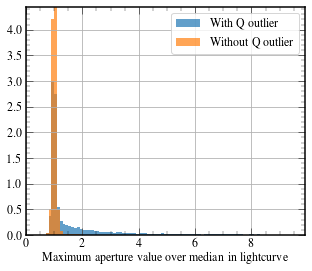

In [32]:
df_phot['RelativeMaxVal'][df_phot['cr_Qclip']].hist(bins=np.arange(0,10,0.1),density=True,label='With Q outlier',alpha=0.7)
df_phot['RelativeMaxVal'][~df_phot['cr_Qclip']].hist(bins=np.arange(0,10,0.1),density=True, label='Without Q outlier',alpha=0.7)
plt.xlabel('Maximum aperture value over median in lightcurve')
plt.legend()

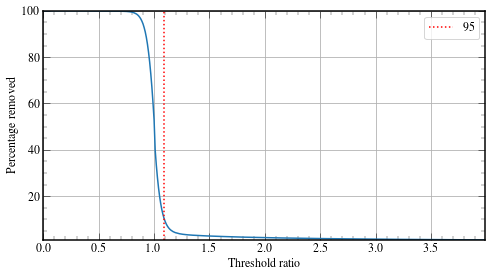

In [33]:
plt.figure(figsize=(7,4))
plt.plot(np.arange(0,4,0.01),[(df_phot['RelativeMaxVal']>=w).sum() / len(df_phot['RelativeMaxVal'])*100 for w in np.arange(0,4,0.01)])
plt.xlabel('Threshold ratio')
plt.ylabel('Percentage removed')
plt.axvline(np.quantile(df_phot['RelativeMaxVal'],0.9),c='red',ls='dotted',label='95% quantile')
plt.tight_layout()
plt.legend()
plt.show()

In [34]:
np.quantile(df_phot['RelativeMaxVal'],0.9)

1.092783505154639

In [35]:
"""narrowband = df_phot[df_phot.index.get_level_values(1)=='F656N']
narrowband = narrowband[narrowband.emagP<0.07]
narrowband['emag'] = narrowband['emagP']
broadband  = df_phot[df_phot.index.get_level_values(1)!='F656N'].dropna(subset=['emag'],axis=0)
broadband  = broadband[broadband.emag<0.07]
df_phot    = pd.concat((narrowband,broadband)).sort_index()"""

"narrowband = df_phot[df_phot.index.get_level_values(1)=='F656N']\nnarrowband = narrowband[narrowband.emagP<0.07]\nnarrowband['emag'] = narrowband['emagP']\nbroadband  = df_phot[df_phot.index.get_level_values(1)!='F656N'].dropna(subset=['emag'],axis=0)\nbroadband  = broadband[broadband.emag<0.07]\ndf_phot    = pd.concat((narrowband,broadband)).sort_index()"

In [36]:
"""def get_error_from_Ha(df):
    broadband_df  = df[df.index.get_level_values(1)!='F656N']
    narrowband_df = df[df.index.get_level_values(1)=='F656N']
    epochnr = narrowband_df.index.get_level_values(2)
    central_three = narrowband_df[(epochnr=='3')+(epochnr=='5')+(epochnr=='7')]
    ha_emag = pd.DataFrame({'emag_3std':central_three.groupby('ID').mag.std()})
    narrowband_df = pd.merge(narrowband_df,ha_emag, left_on='ID',right_index=True)
    return pd.concat((broadband_df,narrowband_df)).sort_index()
df_phot = get_error_from_Ha(df_phot)

narrowband = df_phot[df_phot.index.get_level_values(1)=='F656N']
narrowband = narrowband[narrowband.emagP<0.07]
narrowband['emag'] = narrowband['emagP']
narrowband = narrowband[narrowband.emag_3std<0.1]
broadband  = df_phot[df_phot.index.get_level_values(1)!='F656N'].dropna(subset=['emag'],axis=0)
broadband  = broadband[broadband.emag<0.07]
df_phot    = pd.concat((narrowband,broadband)).sort_index()
df_phot"""

"def get_error_from_Ha(df):\n    broadband_df  = df[df.index.get_level_values(1)!='F656N']\n    narrowband_df = df[df.index.get_level_values(1)=='F656N']\n    epochnr = narrowband_df.index.get_level_values(2)\n    central_three = narrowband_df[(epochnr=='3')+(epochnr=='5')+(epochnr=='7')]\n    ha_emag = pd.DataFrame({'emag_3std':central_three.groupby('ID').mag.std()})\n    narrowband_df = pd.merge(narrowband_df,ha_emag, left_on='ID',right_index=True)\n    return pd.concat((broadband_df,narrowband_df)).sort_index()\ndf_phot = get_error_from_Ha(df_phot)\n\nnarrowband = df_phot[df_phot.index.get_level_values(1)=='F656N']\nnarrowband = narrowband[narrowband.emagP<0.07]\nnarrowband['emag'] = narrowband['emagP']\nnarrowband = narrowband[narrowband.emag_3std<0.1]\nbroadband  = df_phot[df_phot.index.get_level_values(1)!='F656N'].dropna(subset=['emag'],axis=0)\nbroadband  = broadband[broadband.emag<0.07]\ndf_phot    = pd.concat((narrowband,broadband)).sort_index()\ndf_phot"

In [37]:
# Q analysis
def clean_df(df,minmeas=4,max_Qstd = 2.5, min_Q = 0.9):
    df = df[df.Q>=min_Q]
    nunique = df.groupby(['ID','Filter']).mag.nunique()
    keep = nunique[nunique > minmeas]
    df = df.loc[keep.index]
    
    # Identify Cosmic rays using Q outliers
    
    d_mag = df.groupby(['ID','Filter','EpochNR']).mag.median() - df.groupby(['ID','Filter']).mag.median()
    d_Q = df.groupby(['ID','Filter','EpochNR']).Q.median() - df.groupby(['ID','Filter']).Q.median()
    std_Q = df.groupby(['ID','Filter']).Q.std()
    
    good = (np.isfinite(d_mag.values))*(np.isfinite(d_Q.values))
    plt.figure(figsize=(6.5,3))
    plt.subplot(121)
    plt.ylim(-0.2,0.2)
    plt.scatter(d_mag, d_Q,s=0.005)
    plt.yticks(np.arange(-0.2,0.21,0.05))
    plt.ylabel('Difference in Q param')
    plt.xlabel('Magnitude difference')
    # Remove outliers
    t_Q = d_Q / std_Q
    
    keep = t_Q.index[t_Q>-1*max_Qstd]
    print('Rejected',len(t_Q[t_Q<-1*max_Qstd]),' measurements')
    df = df.set_index('EpochNR', append=True)
    df = df.loc[keep]

    d_mag = df.groupby(['ID','Filter','EpochNR']).mag.median() - df.groupby(['ID','Filter']).mag.median()
    d_Q = df.groupby(['ID','Filter','EpochNR']).Q.median() - df.groupby(['ID','Filter']).Q.median()
    good = (np.isfinite(d_mag.values))*(np.isfinite(d_Q.values))
    plt.subplot(122)
    plt.yticks(np.arange(-0.2,0.21,0.05),labels=len(np.arange(-0.2,0.21,0.05))*[''])
    plt.ylim(-0.2,0.2)
    plt.scatter(d_mag, d_Q,s=0.005)
    plt.xlabel('Magnitude difference')
    plt.tight_layout(pad=0)
    plt.show()
    
    return df 
#df_phot = clean_df(df_phot)
#for i in range(3):
#    df_phot = clean_df(df_phot.reset_index().set_index(['ID','Filter']))

In [38]:
df_phot = df_phot[(~df_phot.PotentialCR)&(df_phot.Q>0.9)]
df_phot = df_phot.drop(df_phot.index[df_phot.emag>0.07])

In [52]:
hasnoerror = df_phot[df_phot.index.get_level_values(1)!='F656N'].emag.isna()
df_phot = df_phot.drop(hasnoerror.index[hasnoerror])

In [53]:
nunique = df_phot.groupby(['ID','Filter']).mag.nunique()
keep = nunique[nunique >= 4]
df_phot = df_phot.reset_index().set_index(['ID','Filter']).loc[keep.index]
df_phot = df_phot.reset_index().set_index(['ID','Filter','OBS_ID'])

In [75]:
number_obs

Filter
F336W    20
F438W    12
F555W    16
F656N     8
F814W    16
Name: OBS_ID, dtype: int64

In [77]:
number_remaining = df_phot.reset_index().groupby(['Filter'])['ID'].agg(['count','nunique']) 
number_orig = df_phot_noclean.reset_index().groupby(['Filter'])['ID'].agg(['count','nunique'])
number_obs = df_phot.reset_index().groupby('Filter')['OBS_ID'].nunique()
perc_remaining = number_remaining / number_orig
df = pd.concat((number_remaining,perc_remaining),axis=1)
df = pd.concat((number_obs,df),axis=1)
df.columns = ['Exps','Obj','Meas.', 'Obj. (%)', 'Meas. (%)']
df[['Obj. (%)', 'Meas. (%)']] = 100*df[['Obj. (%)', 'Meas. (%)']]
df = df.round(1)
print(df.to_latex())

\begin{tabular}{lrrrrr}
\toprule
{} &  Exps &     Obj &  Meas. &  Obj. (\%) &  Meas. (\%) \\
Filter &       &         &        &           &            \\
\midrule
F336W  &    20 &   82584 &   6488 &      30.3 &       33.6 \\
F438W  &    12 &   86920 &  10064 &      42.2 &       51.9 \\
F555W  &    16 &  154930 &  13688 &      54.7 &       72.1 \\
F656N  &     8 &   20241 &   3123 &      28.7 &       18.6 \\
F814W  &    16 &  218891 &  18572 &      75.7 &       96.9 \\
\bottomrule
\end{tabular}



In [57]:
df_reduced = df_master[(df_master.Q_F555W>0.92)&(df_master.Q_F814W>0.92)&(df_master.Q_F656N>0.9)&(df_master.Q_F438W>0.9)&(df_master.Q_F336W>0.9)]
df_reduced = df_phot.loc[df_reduced.index]

In [58]:
def get_knn(k=150):
    X = df_master.X
    Y = df_master.Y
    df_reduced = df_master[(df_master.Q_F555W>0.92)&(df_master.Q_F814W>0.92)&(df_master.Q_F656N>0.9)]
    X_red = df_reduced.X
    Y_red = df_reduced.Y
    
    distances = np.sqrt((X.values - X_red.values[:,np.newaxis])**2+(Y.values - Y_red.values[:,np.newaxis])**2).T
    distances = pd.DataFrame(distances,index=X.index, columns=X_red.index)
    
    indices = pd.DataFrame(np.zeros((len(X),k)),index=X.index)
    for ID,row in indices.iterrows():
        indices.loc[ID] = distances.loc[ID].sort_values().index[1:k+1]
    return indices,distances
indices,distances = get_knn(75)

In [59]:
def local_MZP_corr(subdf, reduced_df):
    # Get KNN
    for iter_ ,(index, row) in enumerate(subdf.iterrows()):
        knn = indices.loc[index[0]].values
        knn_phot = reduced_df.loc[knn]
        knn_phot = knn_phot[knn_phot.index.get_level_values(1)==index[1]]
        corr = (knn_phot.groupby(['ID','OBS_ID'])['mag'].median() - knn_phot.groupby(['ID'])['mag'].median()).groupby('OBS_ID').median()
        OBS_IDs = subdf.loc[(index[0],index[1],corr.index),'mzpcorr'].index.get_level_values(2)
        subdf.loc[(index[0],index[1],corr.index),'mzpcorr']=corr.loc[OBS_IDs].values
    return subdf

In [61]:
import time
def parallel_mzp(test_df):
    num_processes = 22
    test_df['mzpcorr'] = 0
    chunk_size = int(test_df.shape[0]/num_processes)
    chunks = [test_df.loc[test_df.index[i:i + chunk_size]] for i in range(0, test_df.shape[0], chunk_size)]
    
    ret = Parallel(n_jobs=num_processes)(delayed(local_MZP_corr)(chunk,df_reduced) for chunk in chunks)

    return pd.concat(ret).sort_index()
ts = time.time()
df_phot = parallel_mzp(df_phot)
df_phot['mag'] = df_phot['mag'] - df_phot['mzpcorr']
time.time() - ts

856.6476986408234

In [78]:
meandist = pd.Series()
for ID,row in indices.iterrows():
    meandist.loc[ID] = np.mean(distances.loc[ID].sort_values()[1:75+1])

<ipython-input-78-81d18da44529>:1: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  meandist = pd.Series()


KeyboardInterrupt: 

0.0004119727116211891


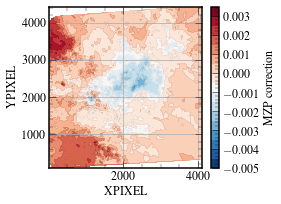

In [56]:
def plot_MZP_map(OBSID='ib6wr8jzq'):
    ngridx = 400
    ngridy = 400
    a = df_phot[df_phot.index.get_level_values(2)==OBSID]
    x = a.X
    y = a.Y
    z = a.mzpcorr

    fig, ax1 = plt.subplots(figsize=(4,3))
    ax1.tricontour(x, y, z, levels=16, linewidths=0.05, colors='k')
    print(np.abs(z).median())
    cntr1 = ax1.tricontourf(x, y, z, levels=16, cmap="RdBu_r")
    cbar = fig.colorbar(cntr1, ax=ax1)#,orientation="horizontal")
    ax1.set(xlim=(a.X.min(),a.X.max()), ylim=(a.Y.min(),a.Y.max()))
    #ax1.set_title('HST MZP correction')
    cbar.set_label('MZP correction')
    plt.subplots_adjust(hspace=0.5)
    plt.xlabel('XPIXEL')
    plt.ylabel('YPIXEL')
    plt.tight_layout()
    plt.savefig('HST_MZP_correction_'+OBSID+'.pdf',bbox_inches='tight')
    plt.show()
plot_MZP_map()

In [80]:
df_phot.to_pickle('./KS2_timeresolved_withCRrejection_withMZPcorr.pickle')

In [88]:
df_phot = pd.read_pickle('./KS2_timeresolved_withCRrejection_withMZPcorr.pickle')

In [89]:
print(((df_phot.groupby(['Filter','EpochNR']).JulianDate.min() - df_phot.groupby(['Filter','EpochNR']).JulianDate.max()).abs().groupby('Filter').mean()*24).to_latex())

\begin{tabular}{lr}
\toprule
{} &  JulianDate \\
Filter &             \\
\midrule
F336W  &    1.203958 \\
F438W  &    1.325602 \\
F555W  &    1.232292 \\
F656N  &    0.000000 \\
F814W  &    0.225694 \\
\bottomrule
\end{tabular}



14421


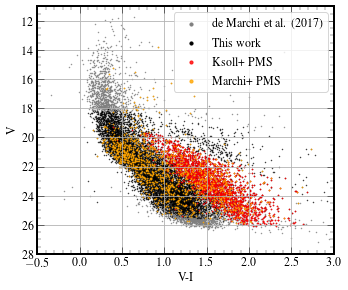

In [152]:
def plot_HR():
    all_stars_lowerr = wfc3_catalogue[(wfc3_catalogue.ei_2<0.07)&(wfc3_catalogue.ev_2<0.07)]
    #print("Length marchi 2011 data",len(all_stars_lowerr))
    this_work = df_master[(df_master.Q_F814W>0.95)&(df_master.Q_F555W>0.95)].index
    
    #KS2 = df_phot.groupby(['ID','Filter']).mag.median().unstack()
    VI = all_stars_lowerr.v_1 - all_stars_lowerr.i_1
    V = all_stars_lowerr.v_1
    print(len(all_stars_lowerr))
    
    #plt.figure(figsize=(8,6))
    plt.scatter(VI,V, color='grey', s=0.2, label='de Marchi et al. (2017)')
    plt.scatter(VI.reindex(this_work).iloc[0], V.reindex(this_work).iloc[0],s=0.05, color='black', label='This work')
    plt.scatter(VI.reindex(this_work), V.reindex(this_work),s=0.1, color='black', alpha=0.8)
    plt.scatter(VI.reindex(KsollPMS_IDs), V.reindex(KsollPMS_IDs),s=0.5, color='red', alpha=0.8,label='Ksoll+ PMS')
    plt.scatter(VI.reindex(pms_ids), V.reindex(pms_ids),s=0.5, color='orange', alpha=0.8,label='Marchi+ PMS')
    
    plt.xlabel('V-I')#, size=15)
    plt.ylabel(r'V')#, size=15)
    plt.tight_layout()
    plt.xlim(-0.5,3)
    plt.ylim(28,11)
    lgnd = plt.legend(loc='best',numpoints=1)
    lgnd.legendHandles[0]._sizes = [10]
    lgnd.legendHandles[1]._sizes = [10]
    lgnd.legendHandles[2]._sizes = [10]
    lgnd.legendHandles[3]._sizes = [10]
    lgnd.legendHandles[1]._colors = ['black']
    lgnd.legendHandles[1]._alphas = [1]
    
    plt.tight_layout()
    plt.savefig('VI_V_HR.pdf',bbox_inches='tight')
    return 
plot_HR()

[-0.03415938  0.03392318] [0.06808256]


/home/luuk/anaconda3/lib/python3.8/site-packages/matplotlib/colors.py:1171: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


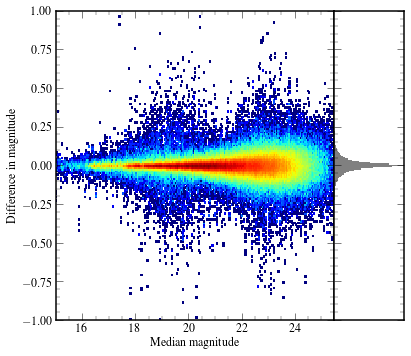

[-0.03305972  0.03283394] [0.06589366]


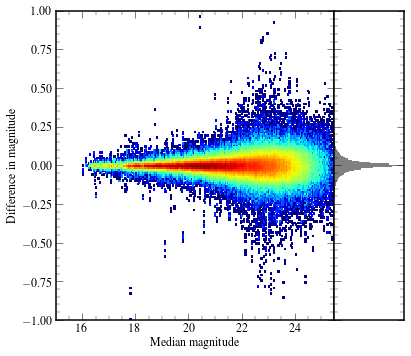

In [18]:
def Trumpet(phot_df,filters):
    magcol='mag'
    IDcol='ID'
    # Trumpet plot
    
    magnitudes = phot_df[magcol]
    num=0
    fig, (a0, a1) = plt.subplots(1, 2, gridspec_kw={'width_ratios': [4, 1]})#,figsize=(8.5,4.5))

    xs, ys = np.array([]), np.array([])
    for filter_ in np.sort(filters):
        epochs  = magnitudes.loc[:,filter_,:].index.get_level_values(1).unique()
        mags_t0 = pd.DataFrame(magnitudes.loc[:, filter_, epochs[0], :])
        num+=1
        for i in range(len(epochs)-1):
            mags_t1 = pd.DataFrame(magnitudes.loc[:, filter_, epochs[i+1], :])
            join_mags = mags_t0.join(mags_t1, lsuffix = '_t0', rsuffix='_t1', how='inner')
            join_mags['DeltaMag'] = join_mags[magcol+'_t1'] - join_mags[magcol+'_t0']
            median_mags = magnitudes.loc[:, filter_, :].groupby([IDcol]).median()
            join_mags = join_mags.join(median_mags)
            x, y = join_mags[magcol].values, join_mags['DeltaMag'].values
            x, y = x[np.isfinite(x)*np.isfinite(y)], y[np.isfinite(x)*np.isfinite(y)]
            xs = np.hstack((xs,x))
            ys = np.hstack((ys,y))
    a0.hist2d(xs, ys, bins=(np.linspace(14,25.5,250), np.linspace(-3,3,500)), cmap='jet', cmin=1, norm=LogNorm())
    a0.set_ylabel('Difference in magnitude')#, size=15)
    a0.set_xlabel('Median magnitude')#, size=15)
    a0.set_xlim(15,25.5)
    a0.set_ylim(-1,1)
    fig.tight_layout(pad=-1.65)
    #a0.set_xticks(fontsize=15)
    #a0.tick_params(labelsize=15)
    #a0.set_yticks(fontsize=15)
    a1.hist(ys, bins=np.arange(-1,1,0.0081),orientation="horizontal", color='gray')
    print(np.percentile(ys,[17,84]),np.diff(np.percentile(ys,[17,84])))
    a1.set_yticks(ticks=np.arange(-1,1.01,0.25))
    a1.set_yticklabels(len(np.arange(-1,1.01,0.25))*[''])
    a1.grid(False)
    a1.set_xticks([])
    plt.savefig('trumpet_diagram.pdf', dpi=500, bbox_inches='tight')
    plt.show()
Trumpet(df_phot, ['F336W','F438W','F555W','F814W', 'F656N'])
Trumpet(df_phot, ['F336W','F438W','F555W','F814W'])

In [19]:
df_phot.reset_index().OBS_ID.nunique()

72

In [74]:
ACS_catalogue = pd.read_pickle('../ACS/FullCatalogue.updatedWCS.pickle')
ACS_catalogue['m75'] = ACS_catalogue[['m75a','m75u']].min(axis=1)
ACS_catalogue['q75'] = ACS_catalogue[['q75a','q75u']].max(axis=1)
ACS_catalogue['e75'] = ACS_catalogue[['e75a','e75u']].min(axis=1)
# Drop redundant columns
ACS_catalogue = ACS_catalogue.drop(['e75a','e75u','m75a','m75u'], axis=1)

In [75]:
def ACS_MyIDs_transfer():
    # Load ACS IDs for the WFC3 region
    ACS_IDs = pd.read_pickle('../ACS/EpochDRZ_broadband_cleaned_ACS_IDs.pickle')
    ACS_IDs = ACS_IDs[ACS_IDs.XERR**2+ACS_IDs.YERR**2<2]
    ACS_IDs = ACS_IDs[ACS_IDs.MERR<0.1]
    ACS_IDs = ACS_IDs.groupby('AssocID')[['XCENTER', 'YCENTER']].median()
    
    # Load WFC3 IDs for the WFC3 region
    MyIDs = pd.read_pickle('../ACS/wfc3_photometry_raw.pickle')
    MyIDs = MyIDs[MyIDs.XERR**2+MyIDs.YERR**2<2]
    MyIDs = MyIDs[MyIDs.MERR<1]
    MyIDs = MyIDs.groupby('ID')[['XCENTER', 'YCENTER']].median()
    
    # Get the distances in x,y coordinates and find the minimum for each WFC3 ID
    distance = MyIDs.values - ACS_IDs.values[:,np.newaxis]
    distance = np.sqrt(np.sum(distance**2,axis=2))
    distance = pd.DataFrame(distance.T, index=MyIDs.index, columns=ACS_IDs.index)
    mindist = distance.min(axis=1)
    
    # We set the threshold to one pixel and match the IDs
    MyID_ACS_ID = distance.idxmin(axis=1)
    MyID_ACS_ID = MyID_ACS_ID[mindist<=1.5]
    MyID_ACS_ID = MyID_ACS_ID.reset_index()
    MyID_ACS_ID.columns = ['WFC3_ID','ACS_ID']
    MyID_ACS_ID['ACS_ID'] +=1
    MyID_ACS_ID = pd.DataFrame(MyID_ACS_ID)
    return MyID_ACS_ID
MyID_ACS_ID = ACS_MyIDs_transfer()
MyID_ACS_ID = MyID_ACS_ID.set_index('ACS_ID')
ACS_catalogue = ACS_catalogue.loc[MyID_ACS_ID.index]
ACS_catalogue['ID'] = MyID_ACS_ID
ACS_catalogue = ACS_catalogue.set_index('ID')

In [95]:
def GetMad(df):
    MAD = (df.groupby(['ID','Filter', 'OBS_ID'])['mag'].median() - df.groupby(['ID','Filter'])['mag'].median()).abs().groupby(['ID','Filter']).median()
    MAG = df.groupby(['ID','Filter'])['mag'].median()
    eMAD = np.sqrt(2)/np.sqrt(df.groupby(['ID','Filter'])['mag'].nunique()) * df.groupby(['ID','Filter'])['emag'].mean()
    eMAG = df.groupby(['ID','Filter'])['mag'].std()
    minmax = (df.groupby(['ID','Filter'])['mag'].max() - df.groupby(['ID','Filter'])['mag'].min())
    idxmax = (df.groupby(['ID','Filter'])['mag'].idxmax())
    idxmin = (df.groupby(['ID','Filter'])['mag'].idxmin())
    eminmax = np.sqrt(df.loc[idxmax].drop_duplicates()['emag'].droplevel(2)**2 + df.loc[idxmin].drop_duplicates()['emag'].droplevel(2)**2)
    return pd.DataFrame({'MAG':MAG, 'MAD':MAD,'eMAD':eMAD,'eMAG':eMAG,'minmax':minmax,'eminmax':eminmax})#,'eMAD':eMAD}).dropna()
MagMadeMAD = GetMad(df_phot)

In [23]:
def plot_images(ID,filt):
    if len(df_phot.loc[ID,filt])<3:
        print('Less than 3 exps')
    brightest = df_phot.loc[ID,filt].mag.idxmin()
    mag_brightest = df_phot.loc[ID,filt].mag.min()
    faintest  = df_phot.loc[ID,filt].mag.idxmax()
    mag_faintest  = df_phot.loc[ID,filt].mag.max()
    N = len(df_phot.loc[ID,filt])
    mean_bright = df_phot.loc[ID,filt].mag.sort_values().index[N//2]
    mean_mag = df_phot.loc[ID,filt].mag.sort_values().iloc[N//2]
    print(brightest)
    #f filt == 'F656N':
    obs_id1 = brightest#df_phot.loc[ID,filt].loc[brightest].OBS_ID
    obs_id2 = mean_bright#df_phot.loc[ID,filt].loc[mean_bright].OBS_ID
    obs_id3 = faintest#df_phot.loc[ID,filt].loc[faintest].OBS_ID
    """else
        obs_id1 = df_phot.loc[ID,filt].loc[brightest].OBS_ID.iloc[0]
        obs_id2 = df_phot.loc[ID,filt].loc[mean_bright].OBS_ID.iloc[0]
        obs_id3 = df_phot.loc[ID,filt].loc[faintest].OBS_ID.iloc[0]"""
        
    files = ['./data/'+obs_id1+'/LOGR.STACK_X1_V1.fits',
             './data/'+obs_id2+'/LOGR.STACK_X1_V1.fits',
             './data/'+obs_id3+'/LOGR.STACK_X1_V1.fits']

    hdus  = [fits.open(w,ignore_missing_end=True) for w in files]
    datas = [hdu[0].data for hdu in hdus]
    
    dPIX = 10
    
    xmin = int(df_master.loc[ID].X-dPIX)
    xmax = int(df_master.loc[ID].X+dPIX)
    ymin = int(df_master.loc[ID].Y-dPIX)
    ymax = int(df_master.loc[ID].Y+dPIX)
    
    from mpl_toolkits.mplot3d import Axes3D
    fig=plt.figure(figsize=(13,8))
    #ax1 = fig.add_subplot(131)
    ax1 = fig.add_subplot(231, projection='3d')
    
    cutout = datas[0][ymin:ymax,xmin:xmax]
    cutout[cutout<0] = np.nan
    vmin = np.quantile(cutout,0.3)
    vmax = np.quantile(cutout,0.999)
    
    #ax1.imshow(cutout, norm=LogNorm(),cmap='Greys_r',vmin=vmin, vmax=vmax)
    
    X, Y = np.meshgrid(np.arange(0,cutout.shape[1]),np.arange(0,cutout.shape[0]))

    # Plot the surface.
    surf = ax1.plot_surface(X, Y, cutout, cmap='gist_heat_r',
                           linewidth=0, antialiased=False,norm=LogNorm())
    ax1.set_title(np.round(mag_brightest,2),size=16)
    ax1.set_xticks([])
    ax1.set_yticks([])
    
    ax2 = fig.add_subplot(234)
    ax2.imshow(cutout, norm=LogNorm(),cmap='Greys_r',vmin=vmin, vmax=vmax)
    ax2.set_xticks([])
    ax2.set_yticks([])
    
    ax3 = fig.add_subplot(232, projection='3d')
    cutout = datas[1][ymin:ymax,xmin:xmax]
    cutout[cutout<0] = np.nan
    plt.title(np.round(mean_mag,2),size=16)
    surf = ax3.plot_surface(X, Y, cutout, cmap='gist_heat_r',
                           linewidth=0, antialiased=False,norm=LogNorm())
    ax3.set_xticks([])
    ax3.set_yticks([])
    ax4 = fig.add_subplot(235)
    ax4.imshow(cutout, norm=LogNorm(),cmap='Greys_r',vmin=vmin, vmax=vmax)
    ax4.set_xticks([])
    ax4.set_yticks([])
    #plt.imshow(cutout, norm=LogNorm(),cmap='Greys_r',vmin=vmin, vmax=vmax)
    plt.xticks([])
    plt.yticks([])
    
    
    ax5 = fig.add_subplot(233, projection='3d')
    ax5.set_xticks([])
    ax5.set_yticks([])
    cutout = datas[2][ymin:ymax,xmin:xmax]
    cutout[cutout<0] = np.nan
    plt.title(np.round(mag_faintest,2),size=16)
    surf = ax5.plot_surface(X, Y, cutout, cmap='gist_heat_r',
                           linewidth=0, antialiased=False,norm=LogNorm())
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()
    
    ax6 = fig.add_subplot(236)
    ax6.imshow(cutout, norm=LogNorm(),cmap='Greys_r',vmin=vmin, vmax=vmax)
    ax6.set_xticks([])
    ax6.set_yticks([])
    plt.savefig('./varplots/'+str(ID)+'_'+filt+'.pdf',bbox_inches='tight')
    plt.show()
    
    
    
    return
    for i in df_phot.loc[ID,filt].index.values:
        obs_ids = df_phot.loc[ID,filt].reset_index().set_index('EpochNR').loc[i].OBS_ID
        if type(obs_ids)==list or type(obs_ids)==pd.core.series.Series:
            for j in obs_ids:
                print ('./'+j+'/LOGR.STACK_X1_V1.fits',end=' ')
        else:
            print ('./'+obs_ids+'/LOGR.STACK_X1_V1.fits',end=' ')


???????????????????????????????????????????????????????????????????????????????? [astropy.io.fits.card]


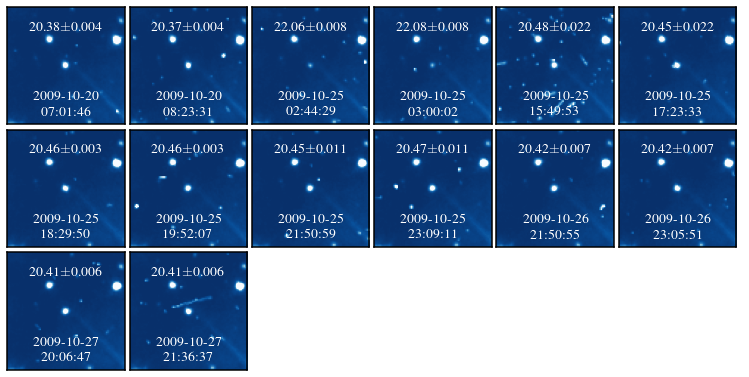

In [96]:
def plot_one_star(ID,filt):
    df = df_phot.loc[ID,filt]
    df = df.sort_values(by='mag')
    #df = pd.concat((df[:6],df[-4:]))
    df = df.sort_values(by='ObsStart')
    filenames = df.index
    
    
    
    files = ['./data/'+w+'/LOGR.STACK_X1_V1.fits' for w in filenames]
    hdus  = [fits.open(w,ignore_missing_end=True) for w in files]
    datas = [hdu[0].data for hdu in hdus]
    
    dPIX = 40
    
    xmin = int(df_master.loc[ID].X-dPIX)
    xmax = int(df_master.loc[ID].X+dPIX)
    ymin = int(df_master.loc[ID].Y-dPIX)
    ymax = int(df_master.loc[ID].Y+dPIX)
    
    fig,axes=plt.subplots(nrows=int(np.ceil(len(files)/6)),ncols=6,figsize=(10.1,5.1))
    axes = np.hstack(axes)
    #ax1 = fig.add_subplot(131)
    cutout = datas[0][ymin:ymax,xmin:xmax]
    cutout[cutout<0] = np.nan
    vmin = np.quantile(cutout,0.2)
    vmax = np.quantile(cutout,0.995)
    
    for i in range(0,len(axes)):
        ax = axes[i]
        if i < len(files):
            data = datas[i]
            cutout = data[ymin:ymax,xmin:xmax]
            cutout[cutout<0] = np.nan

            # Plot the surface.
            surf = ax.imshow(cutout, cmap='Blues_r',vmin=vmin, vmax=vmax)#norm=LogNorm()
            #ax.set_title(np.round(mag_brightest,2),size=16)
            ax.set_xticks([])
            ax.set_yticks([])
            title1 = str(df.iloc[i].mag.round(2))+r'$\pm$'+str(df.iloc[i].emag.round(3))+'\n\n\n\n\n'
            title2 = str(df.ObsStart.iloc[i]).replace(' ','\n')
            title = title1+title2
            ax.set_title(title,color='white',y=0.025,size=14)
        else:
            ax.axis('off')
    plt.tight_layout(pad=-0.55)
    #plt.savefig('./varplots/color_'+str(ID)+'_'+filt+'.pdf',bbox_inches='tight')
    plt.show()
plot_one_star(3554,'F555W')

F336W 6488
102
1.5721331689272502
F438W 10064
141
1.401033386327504


/home/luuk/anaconda3/lib/python3.8/site-packages/pandas/core/computation/expressions.py:177: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  warnings.warn(
/home/luuk/anaconda3/lib/python3.8/site-packages/pandas/core/computation/expressions.py:177: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  warnings.warn(


F555W 13688
175
1.2784921098772648


/home/luuk/anaconda3/lib/python3.8/site-packages/pandas/core/computation/expressions.py:177: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  warnings.warn(


F814W 18572
455
2.4499246177040708


/home/luuk/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3334: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/luuk/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/luuk/anaconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1666: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/luuk/anaconda3/lib/python3.8/site-packages/pandas/core/computation/expressions.py:177: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  warnings.warn(


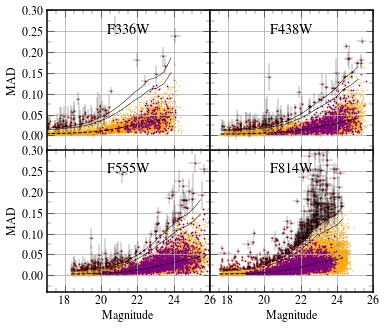

In [100]:
def variation_plot(df):
    running_medians = {}
    #plt.figure(figsize=(8,5))
    plt.figure()#figsize=(8,9))
    i=1
    variable = []
    counts = pd.DataFrame()
    for filter_ in ['F336W','F438W','F555W','F814W','F656N']:
        if not filter_ == 'F656N':
            ax  =plt.subplot('22'+str(i))
        if filter_ in ['F555W', 'F814W']:
            plt.xlabel('Magnitude')
            plt.xticks(np.arange(10,26.5,2))
        else:
            if not filter_ == 'F656N':
                plt.xticks(ticks=np.arange(10,26.5,2), labels=len(np.arange(10,26.5,2))*[''])
            
        if filter_ in ['F438W', 'F814W']:
            plt.yticks(ticks=np.arange(0,0.71,0.05),labels=7*[''])
        else:
            if not filter_ == 'F656N':
                plt.ylabel('MAD')
                plt.yticks(np.arange(0,0.71,0.05))
        #else:
            
        if not filter_ == 'F656N':
            i+=1
            plt.title(filter_, y=0.8)#,x=0.3)
            plt.ylim(-0.04,0.3)
        df = MagMadeMAD[MagMadeMAD.index.get_level_values(1)==filter_].dropna()
        counts = pd.concat((counts,df))
        total_bins = 20#(25 if filter_ in ['F336W','F438W'] else 30)
        lower,upper = df.MAG.quantile(.005),df.MAG.quantile(.995)
        bins = np.linspace(lower,upper, total_bins)
        delta = bins[1]-bins[0]
        idx  = np.digitize(df.MAG,bins)
        running_median = np.array([np.median(df.MAD[idx==k]) for k in range(total_bins)])
        running_median_eMAD = np.array([np.nanstd(df.MAD[idx==k]) for k in range(total_bins)])
        all_y_interp = interp_func(df.MAG,bins, delta, running_median)
        two_sigma_above = all_y_interp +2*1.48*all_y_interp#+ 1.5*1.48*all_y_interp
        
        running_medians[filter_] = [bins-delta/2, running_median]
        
        x = (df.MAD>two_sigma_above)*(df.MAG>16.5)
        x = x[x].index
        
        if not filter_ == 'F656N':
            print(filter_,len(df.MAG))
            print(len(x))
            print(len(x)/len(df.MAG)*100)
            plt.scatter(df.MAG, df.MAD, edgecolor='orange',s=0.1,marker='o',facecolor='orange')
            plt.errorbar(df.MAG.loc[x], df.MAD.loc[x],yerr=df.eMAD.loc[x],xerr=df.eMAG.loc[x],ls='none',lw=0.3,color='black')
            plt.scatter(df.MAG.loc[x], df.MAD.loc[x], edgecolor='red',s=0.5,marker='o',facecolor='red')
            
            plt.scatter(df.MAG.loc[KsollPMS_IDs], df.MAD.loc[KsollPMS_IDs], edgecolor='purple',s=0.5,marker='o',facecolor='purple')
            
            
            
            #plt.scatter(df.MAG.loc[wfc3_ha_x], df.MAD.loc[wfc3_ha_x], edgecolor='purple',s=2,marker='o',facecolor='purple')

            plt.plot(bins-delta/2, running_median, color='black', lw=1,linestyle='--')
            plt.plot(bins-delta/2, running_median*(1+1.5*1.48), color='black', lw=0.5)
            plt.plot(bins-delta/2, running_median*(1+2*1.48), color='black', lw=0.5)
            plt.xlim(17,26.)

            ax.yaxis.set_minor_locator(AutoMinorLocator(2))
        #plt.axvline(18.5, linestyle='dotted', color='black',linewidth=1)
        #plt.xlabel('Magnitude', size=15)
        #plt.ylabel(r'Median Absolute Deviation', size=15)
        for star in x:
            variable.append((star[0], star[1],df.MAG.loc[star], df.MAD.loc[star]))
    plt.tight_layout(pad=-0.5)
    plt.savefig('MAG_MAD_broadbands.pdf',dpi=500,bbox_inches='tight')
    plt.show()
    return pd.DataFrame(variable,columns=['ID','Filter','MAG','MAD']).set_index('ID'),running_medians,counts
variables,WFC3_running_medians,counts = variation_plot(df_phot[df_phot.Q>0.95])

/home/luuk/anaconda3/lib/python3.8/site-packages/pandas/core/computation/expressions.py:177: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  warnings.warn(


F336W 6488
358
5.517879161528977


/home/luuk/anaconda3/lib/python3.8/site-packages/pandas/core/computation/expressions.py:177: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  warnings.warn(


F438W 10064
536
5.325914149443562


/home/luuk/anaconda3/lib/python3.8/site-packages/pandas/core/computation/expressions.py:177: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  warnings.warn(


F555W 13688
1004
7.334891876095851


/home/luuk/anaconda3/lib/python3.8/site-packages/pandas/core/computation/expressions.py:177: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  warnings.warn(


F814W 18572
2865
15.426448416971786


/home/luuk/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3334: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/luuk/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/luuk/anaconda3/lib/python3.8/site-packages/pandas/core/computation/expressions.py:177: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  warnings.warn(


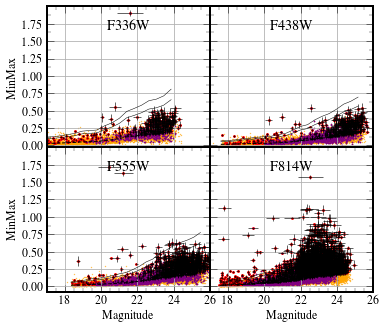

In [188]:
def variation_plot(df):
    running_medians = {}
    #plt.figure(figsize=(8,5))
    plt.figure()#figsize=(8,9))
    i=1
    variable = []
    counts = pd.DataFrame()
    for filter_ in ['F336W','F438W','F555W','F814W','F656N']:
        if not filter_ == 'F656N':
            ax  =plt.subplot('22'+str(i))
        if filter_ in ['F555W', 'F814W']:
            plt.xlabel('Magnitude')
            plt.xticks(np.arange(10,26.5,2))
        else:
            if not filter_ == 'F656N':
                plt.xticks(ticks=np.arange(10,26.5,2), labels=len(np.arange(10,26.5,2))*[''])
            
        if filter_ in ['F438W', 'F814W']:
            plt.yticks(ticks=np.arange(0,2.0,0.25),labels=7*[''])
        else:
            if not filter_ == 'F656N':
                plt.ylabel('MinMax')
                plt.yticks(np.arange(0,2.0,0.25))
        #else:
            
        if not filter_ == 'F656N':
            i+=1
            plt.title(filter_, y=0.8)#,x=0.3)
            plt.ylim(-0.08,2.)
        df = MagMadeMAD[MagMadeMAD.index.get_level_values(1)==filter_].dropna()
        counts = pd.concat((counts,df))
        total_bins = 20#(25 if filter_ in ['F336W','F438W'] else 30)
        lower,upper = df.MAG.quantile(.005),df.MAG.quantile(.995)
        bins = np.linspace(lower,upper, total_bins)
        delta = bins[1]-bins[0]
        idx  = np.digitize(df.MAG,bins)
        running_median = np.array([np.median(df.minmax[idx==k]) for k in range(total_bins)])
        all_y_interp = interp_func(df.MAG,bins, delta, running_median)
        two_sigma_above = all_y_interp +1.5*1.48*all_y_interp#+ 1.5*1.48*all_y_interp
        
        running_medians[filter_] = [bins-delta/2, running_median]
        
        x = (df.MAG>14)*(df.minmax>all_y_interp)*(df.minmax>5*df.eminmax)
        x = x[x].index
        
        if not filter_ == 'F656N':
            print(filter_,len(df.MAG))
            print(len(x))
            print(len(x)/len(df.MAG)*100)
            plt.scatter(df.MAG, df.minmax, edgecolor='orange',s=0.1,marker='o',facecolor='orange')
            plt.errorbar(df.MAG.loc[x], df.minmax.loc[x],yerr=df.eminmax.loc[x],xerr=df.eMAG.loc[x],ls='none',lw=0.6,color='black')
            plt.scatter(df.MAG.loc[x], df.minmax.loc[x], edgecolor='red',s=3.5,marker='o',facecolor='red')
            plt.scatter(df.MAG.loc[KsollPMS_IDs], df.minmax.loc[KsollPMS_IDs], edgecolor='purple',s=0.5,marker='o',facecolor='purple')
            #plt.scatter(df.MAG.loc[wfc3_ha_x], df.MAD.loc[wfc3_ha_x], edgecolor='purple',s=2,marker='o',facecolor='purple')

            plt.plot(bins-delta/2, running_median, color='black', lw=1,linestyle='--')
            plt.plot(bins-delta/2, running_median*(1+1.5*1.48), color='black', lw=0.5)
            plt.plot(bins-delta/2, running_median*(1+2*1.48), color='black', lw=0.5)
            plt.xlim(17,26.)

            ax.yaxis.set_minor_locator(AutoMinorLocator(2))
        #plt.axvline(18.5, linestyle='dotted', color='black',linewidth=1)
        #plt.xlabel('Magnitude', size=15)
        #plt.ylabel(r'Median Absolute Deviation', size=15)
        for star in x:
            variable.append((star[0], star[1],df.MAG.loc[star], df.minmax.loc[star]))
    plt.tight_layout(pad=-0.5)
    plt.savefig('MAG_minmax_broadbands.pdf',dpi=500,bbox_inches='tight')
    plt.show()
    return pd.DataFrame(variable,columns=['ID','Filter','MAG','minmax']).set_index('ID'),running_medians,counts
variables,WFC3_running_medians,counts = variation_plot(df_phot[df_phot.Q>0.9])

In [173]:
variables.sort_values(by='minmax')

,Filter,MAG,minmax
ID,,,
911.0,F814W,17.525062,0.014906
1065.0,F814W,17.688533,0.016702
997.0,F814W,17.706177,0.017304
877.0,F438W,17.935920,0.017486
1086.0,F814W,17.752321,0.017835
...,...,...,...
5085.0,F555W,21.232617,1.623084
3554.0,F555W,20.449073,1.709573
3554.0,F336W,21.599812,1.904633


In [186]:
from scipy.stats import iqr
from scipy.stats import median_absolute_deviation

In [187]:
median_absolute_deviation(df_phot.loc[3554,'F555W'].mag)

0.04334235645556214

In [181]:
MagMadeMAD.loc[3554]

,MAG,MAD,eMAD,eMAG,minmax,eminmax
Filter,,,,,,
F336W,21.599812,0.049527,0.009806,0.711982,1.904633,0.040112
F438W,20.952710,0.039719,0.007964,1.021328,2.595474,0.041578
F555W,20.449073,0.029234,0.003331,0.596020,1.709573,0.009421
F656N,19.378863,0.129553,NaN,0.325614,0.889156,NaN
F814W,19.369763,0.043486,0.002877,0.294837,0.832105,0.010027


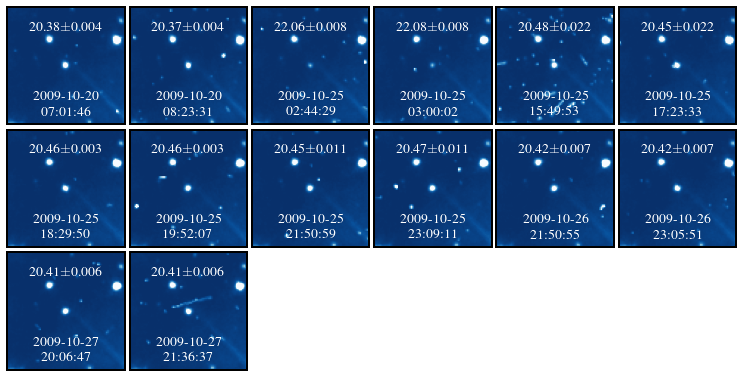

In [176]:
plot_one_star(3554,'F555W')

???????????????????????????????????????????????????????????????????????????????? [astropy.io.fits.card]


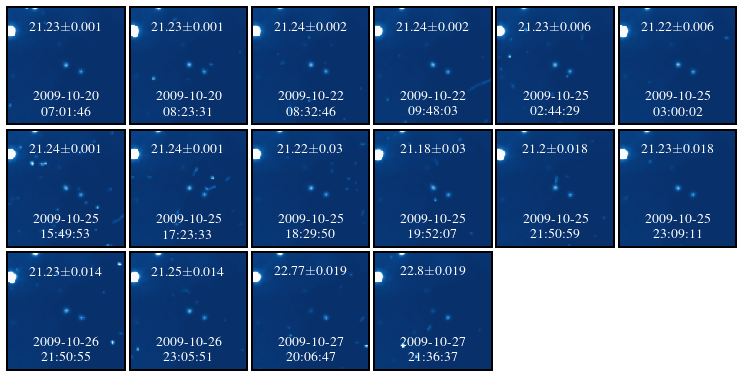

In [174]:
plot_one_star(5085,'F555W')

ib6wd1sqq


???????????????????????????????????????????????????????????????????????????????? [astropy.io.fits.card]


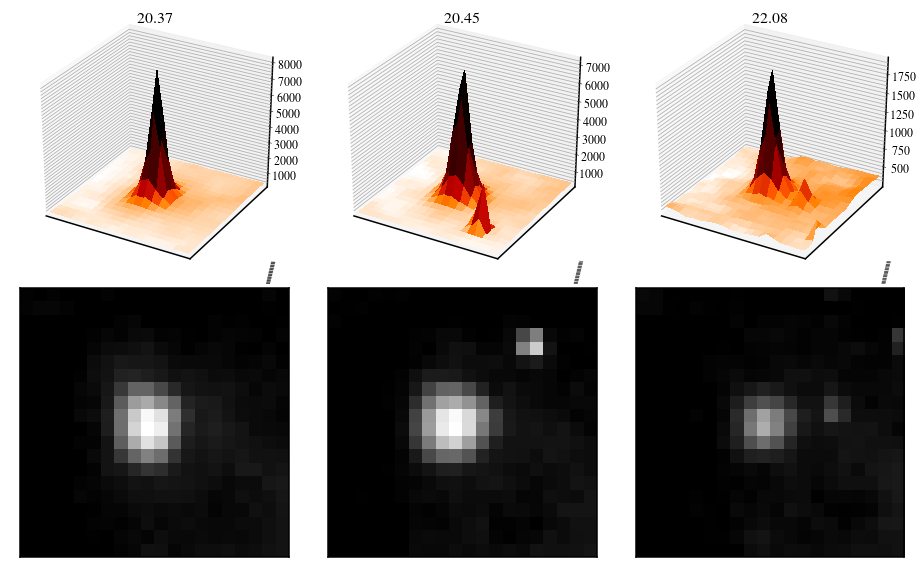

In [103]:
plot_images(3554,'F555W')

In [104]:
#for (id_,row) in variables[variables.Filter=='F814W'].sort_values(by=['minmax']).iloc[-10:].iterrows():
#    plot_images(id_,row.Filter)

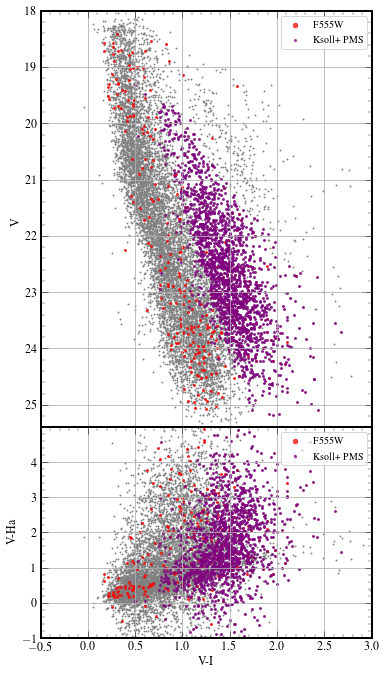

In [197]:
def plot_HR_with_vars():
    from matplotlib import gridspec
    fig = plt.figure(figsize=(5, 9)) 
    gs = gridspec.GridSpec(2,1, height_ratios=[2, 1]) 
    plt.subplot(gs[0])
    
    
    #df = pd.DataFrame({'MAG':wfc3_broadband_df.groupby(['ID','Filter'])['mag'].median(),
    #                   'eMAG':wfc3_broadband_df.groupby(['ID','Filter'])['emag'].mean()})
    
    #df = df[df.eMAG<0.07]
    #df = df[(df.index.get_level_values(1)=='F555W')+(df.index.get_level_values(1)=='F814W')]
    #df = df.unstack().dropna()
    
    all_stars_lowerr = df_master[df_master.em_F555W<0.07]
    all_stars_lowerr = all_stars_lowerr[all_stars_lowerr.em_F814W<0.07]
    
    all_stars_lowerr_ha = all_stars_lowerr[all_stars_lowerr.em_F656N<0.07]
    
    

    
    
    #this_work = df.index
    VI = all_stars_lowerr.m_F555W - all_stars_lowerr.m_F814W
    VHa = all_stars_lowerr.m_F555W - all_stars_lowerr.m_F656N
    V  = all_stars_lowerr.m_F555W
    
    VI_ref = all_stars_lowerr.m_F555W - all_stars_lowerr.m_F814W
    VHa_ref = all_stars_lowerr.m_F555W - all_stars_lowerr.m_F656N
    
    
    plt.scatter(VI, V,edgecolor='grey', facecolor='grey', s=0.7,marker='o')
    
    U_var = variables.index[variables.Filter=='F336W']
    B_var = variables.index[variables.Filter=='F438W']
    V_var = variables.index[variables.Filter=='F555W']
    I_var = variables.index[variables.Filter=='F814W']
    
    
    
    #plt.scatter(VI.reindex(U_var), V.reindex(U_var), edgecolor='purple', facecolor='purple', marker='o', s=1.5,label='F336W',alpha=0.7)
    #plt.scatter(VI.reindex(B_var), V.reindex(B_var), edgecolor='blue', facecolor='blue', marker='o', s=1.5,label='F438W',alpha=0.7)
    plt.scatter(VI.reindex(V_var), V.reindex(V_var), edgecolor='red', facecolor='red', marker='o', s=4,label='F555W',alpha=0.7)
    plt.scatter(VI.reindex(KsollPMS_IDs), V.reindex(KsollPMS_IDs), edgecolor='purple', facecolor='purple', marker='o', s=4,label='Ksoll+ PMS',alpha=0.7)
    
    #plt.scatter(VI.reindex(I_var), V.reindex(I_var), edgecolor='red', facecolor='red', marker='o', s=1.5,label='F814W',alpha=0.7)
    
    plt.ylabel(r'V')
    plt.tight_layout()
    plt.xlim(-0.5,3)
    plt.ylim(25.5,18)
    plt.xticks(ticks=np.arange(-0.5,3.01,0.5),labels=7*[''])
    lgnd = plt.legend(numpoints=1,fontsize=10, loc='upper right',frameon=True)
    #change the marker size manually for both lines
    lgnd.legendHandles[0]._sizes = [20]
    #lgnd.legendHandles[1]._sizes = [20]
    #lgnd.legendHandles[2]._sizes = [20]
    #lgnd.legendHandles[3]._sizes = [20]
    
    #lgnd.legendHandles[1]._colors = ['black']
    #lgnd.legendHandles[1]._alphas = [1]
    #lgnd.legendHandles[2]._sizes = [10]
    plt.subplot(gs[1])
    #VHa  = all_stars_lowerr.v_1 - all_stars_lowerr.ha_1
    
    
    #plt.scatter(VI, VHa,color='grey', s=1,marker='o',alpha=1)
    plt.scatter(VI, VHa,edgecolor='grey', facecolor='grey', s=0.7,marker='o')
    all_var = variables.index

    
    #plt.scatter(VI.reindex(U_var), VHa.reindex(U_var), edgecolor='purple', facecolor='purple', marker='o', s=3,label='F336W',alpha=0.7)
    #plt.scatter(VI.reindex(B_var), VHa.reindex(B_var), edgecolor='blue', facecolor='blue', marker='o', s=3,label='F438W',alpha=0.7)
    plt.scatter(VI.reindex(V_var), VHa.reindex(V_var), edgecolor='red', facecolor='red', marker='o', s=4,label='F555W',alpha=0.7)
    plt.scatter(VI.reindex(KsollPMS_IDs), VHa.reindex(KsollPMS_IDs), edgecolor='purple', facecolor='purple', marker='o', s=4,label='Ksoll+ PMS',alpha=0.7)
    
    
    #plt.scatter(VI.reindex(I_var), VHa.reindex(I_var), edgecolor='red', facecolor='red', marker='o', s=3,label='F814W',alpha=0.7)
    
    total_bins = 10
    bins = np.linspace(0.2,2.4, total_bins)
    delta = bins[1]-bins[0]
    idx  = np.digitize(VI_ref,bins)
    running_median = np.array([np.nanmedian(VHa_ref[idx==k]) for k in range(total_bins)])
    
    
    VI_var = VI.reindex(all_var).dropna()
    VHa_var = VHa.reindex(all_var).dropna()

    
    
    var_y_interp = interp_func(VI_var, bins, delta, running_median)
    
    sigma = np.sqrt(all_stars_lowerr.em_F555W.loc[VHa_var.index]**2+all_stars_lowerr.em_F656N.loc[VHa_var.index]**2)
    #print(np.sum((VHa_var - (var_y_interp))>0.25))
    
    
    
    #plt.plot(bins-delta/2,running_median, lw=3,ls='dotted',color='black')   
    
    plt.xlabel('V-I')
    plt.ylabel(r'V-Ha')
    plt.tight_layout()
    plt.xlim(-0.5,3)
    plt.ylim(-1,5)
    plt.yticks(np.arange(-1,5))
    lgnd = plt.legend(numpoints=1,fontsize=10, loc='upper right',frameon=True)
    
    #change the marker size manually for both lines
    lgnd.legendHandles[0]._sizes = [20]
    #lgnd.legendHandles[1]._sizes = [20]
    #lgnd.legendHandles[2]._sizes = [20]
    #lgnd.legendHandles[3]._sizes = [20]
    
    plt.tight_layout(pad=-0.5)
    plt.savefig('Variables_continuum_CMD.pdf', dpi=500,bbox_inches='tight')
    return 
plot_HR_with_vars()

In [108]:
count_vars = variables.set_index('Filter').groupby('Filter').count()['MAG']

In [109]:
count_all = df_phot[df_phot.Q>0.95].groupby('Filter')['mag'].count()
df = pd.concat((count_vars, count_vars/counts.groupby('Filter').count()['MAG']*100),axis=1)
print(df.round(2).to_latex())

\begin{tabular}{lrr}
\toprule
{} &  MAG &   MAG \\
Filter &      &       \\
\midrule
F336W  &   19 &  0.29 \\
F438W  &   26 &  0.26 \\
F555W  &   50 &  0.37 \\
F814W  &  421 &  2.27 \\
\bottomrule
\end{tabular}



ID       Filter
49.0     F656N          NaN
52.0     F656N          NaN
54.0     F656N          NaN
55.0     F656N          NaN
57.0     F656N          NaN
                     ...   
22261.0  F336W     0.003743
         F656N          NaN
22262.0  F336W     0.004181
         F656N          NaN
         F814W     0.000435
Name: emag, Length: 51935, dtype: float64

<ipython-input-149-87b3bb7dc43c>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  V_WFC3['e555_WFC3'] = df_phot.groupby(['ID','Filter']).emag.median().unstack()['F555W'].dropna() # used median error as proxy


0.03092420270952445
1237


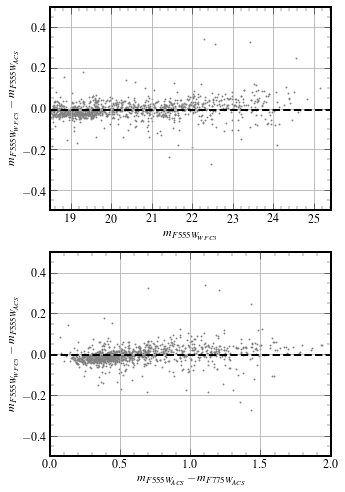

0.022755151869242596

In [149]:
def V_ACS_WFC3():
    qmin=0.75
    V_WFC3 = df_master[['em_F555W','m_F555W','Q_F555W']]
    V_WFC3.columns = ['e555_WFC3','m555_WFC3','q555_WFC3']
    V_WFC3['e555_WFC3'] = df_phot.groupby(['ID','Filter']).emag.median().unstack()['F555W'].dropna() # used median error as proxy
    V_ACS  = ACS_catalogue[['m555','e555','q555']]
    V_ACS  = ACS_catalogue[['m555','e555','q555','m75','e75','q75']]
    V_ACS.columns = ['m555_ACS','e555_ACS','q555_ACS','m775_ACS','e775_ACS','q775_ACS']

    longterm_V = pd.merge(V_ACS,V_WFC3,left_index=True,right_index=True)
    longterm_V = longterm_V[np.isfinite(longterm_V)].dropna()
    longterm_V = longterm_V[(longterm_V.q555_WFC3>qmin)&(longterm_V.q555_ACS>qmin)]
    longterm_V = longterm_V[(longterm_V.e775_ACS<0.1)&(longterm_V.q775_ACS>qmin)]

    longterm_V = pd.merge(V_ACS,V_WFC3,left_index=True,right_index=True)
    longterm_V = longterm_V[np.isfinite(longterm_V)].dropna()
    longterm_V['dV']  = (longterm_V.m555_WFC3 - longterm_V.m555_ACS)
    longterm_V['edV']  = np.sqrt(longterm_V.e555_WFC3**2+ longterm_V.e555_ACS) 
    longterm_V['VI']  = (longterm_V.m555_ACS - longterm_V.m775_ACS)
    median_offset = (longterm_V['dV'])[(longterm_V.q555_WFC3>=0.75)&(longterm_V.q555_ACS>=0.75)].median()
    longterm_V['dV'] = longterm_V['dV'] - median_offset    
    longterm_V = longterm_V[longterm_V['edV']<0.1]
    print(median_offset)
    print(len(longterm_V))
    longterm_V = longterm_V[longterm_V.dV.abs()<10]
    #longterm_V = longterm_V[longterm_V.e555_ACS<0.07]
    #longterm_V = longterm_V[longterm_V.e555_WFC3<0.07]
    #longterm_V = longterm_V[longterm_V.q555_WFC3>0.95]
    longterm_V = longterm_V[longterm_V.q555_ACS>0.95]
    plt.subplots(figsize=(5,7))
    plt.subplot(211)
    plt.scatter(longterm_V.m555_WFC3,longterm_V['dV'],s=0.8,color='grey')
    #plt.errorbar(longterm_V.m555_WFC3[longterm_V['dV'].abs()>0.07],longterm_V[longterm_V['dV'].abs()>0.07]['dV'],yerr=longterm_V[longterm_V['dV'].abs()>0.07].edV,color='grey',ls='none',lw=0.8)
    plt.xlabel(r'$m_{F555W_{WFC3}}$')
    plt.ylabel(r'$m_{F555W_{WFC3}} - m_{F555W_{ACS}}$')
    plt.axhline(longterm_V['dV'].median(),ls='--',color='black',lw=2)
    plt.ylim(-0.5,0.5)
    plt.tight_layout()
    plt.subplot(212)
    plt.scatter(longterm_V.VI,longterm_V['dV'],s=0.8,color='grey')
    #plt.errorbar(longterm_V.VI[longterm_V['dV'].abs()>0.07],longterm_V[longterm_V['dV'].abs()>0.07]['dV'],yerr=longterm_V[longterm_V['dV'].abs()>0.07].edV,color='grey',ls='none',lw=0.8)
    plt.xlabel(r'$m_{F555W_{ACS}} - m_{F775W_{ACS}}$')
    plt.ylabel(r'$m_{F555W_{WFC3}} - m_{F555W_{ACS}}$')
    plt.axhline(longterm_V['dV'].median(),ls='--',color='black',lw=2)
    plt.ylim(-0.5,0.5)
    plt.xlim(0,2)
    plt.tight_layout()
    plt.savefig('dMAG_ACS_WFC3.pdf')
    plt.show()
    return longterm_V
V_ACS_WFC3().dV.abs().median()

<ipython-input-132-effd4b3c9e93>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  V_WFC3['e555_WFC3'] = df_phot.groupby(['ID','Filter']).emag.median().unstack()['F555W'].dropna()


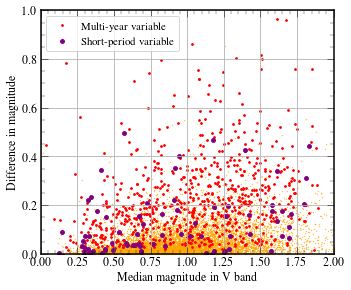

In [132]:
def long_term_v_variable(qmin=0.75):
    # Long term V variability
    V_WFC3 = df_master[['em_F555W','m_F555W','Q_F555W']]
    V_WFC3.columns = ['e555_WFC3','m555_WFC3','q555_WFC3']
    V_WFC3['e555_WFC3'] = df_phot.groupby(['ID','Filter']).emag.median().unstack()['F555W'].dropna()
    V_ACS  = ACS_catalogue[['m555','e555','q555','m75','e75','q75']]
    V_ACS.columns = ['m555_ACS','e555_ACS','q555_ACS','m775_ACS','e775_ACS','q775_ACS']

    longterm_V = pd.merge(V_ACS,V_WFC3,left_index=True,right_index=True)
    longterm_V = longterm_V[np.isfinite(longterm_V)].dropna()
    longterm_V = longterm_V[(longterm_V.q555_WFC3>qmin)&(longterm_V.q555_ACS>qmin)]
    longterm_V = longterm_V[(longterm_V.e775_ACS<0.1)&(longterm_V.q775_ACS>qmin)]
    
    
    
    
    longterm_V['dV']  = (longterm_V.m555_WFC3 - longterm_V.m555_ACS)
    longterm_V['VI']  = (longterm_V.m555_ACS - longterm_V.m775_ACS)
    # Correct for statistical effect
    median_offset = (longterm_V['dV'])[(longterm_V.q555_WFC3>=0.99)&(longterm_V.q555_ACS>=0.99)].median()
    longterm_V['dV'] = longterm_V['dV'].abs() - median_offset
    longterm_V['edV'] = np.sqrt(longterm_V.e555_WFC3**2+longterm_V.e555_ACS**2)
    longterm_V['MAG'] = longterm_V[['m555_WFC3','m555_ACS']].median(axis=1)
    longterm_V['tstat'] = longterm_V['dV'] / longterm_V['edV']
    
    
    total_bins=10
    bins = np.linspace(longterm_V.MAG.min(),longterm_V.MAG.max(), total_bins)
    delta = bins[1]-bins[0]
    idx  = np.digitize(longterm_V.MAG,bins)
    running_median = np.array([np.median(longterm_V.dV[idx==k]) for k in range(total_bins)])
    all_y_interp = interp_func(longterm_V['MAG'],bins, delta, running_median)
        
    longterm_V['significant'] = (longterm_V['tstat']>3)*(longterm_V['dV']>3.5*all_y_interp)
    WFC3_V_variable = variables[(variables.Filter=='F555W')].index
    
    #plt.errorbar(longterm_V.MAG,longterm_V.dV,yerr=longterm_V.edV,ls='none',ms=0.1)
    plt.scatter(longterm_V.VI,longterm_V.dV,s=0.1,color='orange')
    #plt.scatter(longterm_V.MAG.reindex(pms_ids),longterm_V.dV.reindex(pms_ids),s=1,color='black',label='Known PMS')
    plt.scatter(longterm_V.VI[longterm_V['significant']],longterm_V.dV[longterm_V['significant']],s=3,color='red',label='Multi-year variable')
    plt.scatter(longterm_V.VI.reindex(WFC3_V_variable),longterm_V.dV.reindex(WFC3_V_variable),s=15,color='purple', label='Short-period variable')

    plt.ylim(0,1)
    plt.xlim(0,2)
    plt.legend(fontsize=11,frameon=True)
    plt.ylabel('Difference in magnitude')
    plt.xlabel('Median magnitude in V band')
    plt.tight_layout()
    #plt.savefig('Long_shortterm_variability_V.pdf')
    plt.show()
    
V_variable = long_term_v_variable()



<ipython-input-190-71513b1642f6>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  V_WFC3['e555_WFC3'] = df_phot.groupby(['ID','Filter']).emag.median().unstack()['F555W'].dropna()
/home/luuk/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3334: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/luuk/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


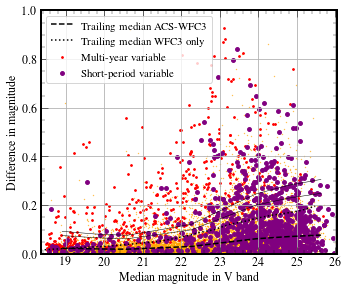

In [190]:
def long_term_v_variable(qmin=0.75):
    # Long term V variability
    V_WFC3 = df_master[['em_F555W','m_F555W','Q_F555W']]
    V_WFC3.columns = ['e555_WFC3','m555_WFC3','q555_WFC3']
    V_WFC3['e555_WFC3'] = df_phot.groupby(['ID','Filter']).emag.median().unstack()['F555W'].dropna()
    V_ACS  = ACS_catalogue[['m555','e555','q555','m75','e75','q75']]
    V_ACS.columns = ['m555_ACS','e555_ACS','q555_ACS','m775_ACS','e775_ACS','q775_ACS']

    longterm_V = pd.merge(V_ACS,V_WFC3,left_index=True,right_index=True)
    longterm_V = longterm_V[np.isfinite(longterm_V)].dropna()
    longterm_V = longterm_V[(longterm_V.q555_WFC3>qmin)&(longterm_V.q555_ACS>qmin)]
    #longterm_V = longterm_V[(longterm_V.e775_ACS<0.1)&(longterm_V.q775_ACS>qmin)]
    #longterm_V = longterm_V[(longterm_V.e555_WFC3<0.1)]
    
    longterm_V['dV']  = (longterm_V.m555_WFC3 - longterm_V.m555_ACS)
    median_offset = (longterm_V['dV'])[(longterm_V.q555_WFC3>=0.99)&(longterm_V.q555_ACS>=0.99)].median()
    longterm_V['dV'] = (longterm_V['dV'] - median_offset).abs()
    
    
    longterm_V['VI']  = (longterm_V.m555_ACS - longterm_V.m775_ACS)
    
    # Correct for statistical effect
    
    longterm_V['edV'] = np.sqrt(longterm_V.e555_WFC3**2+longterm_V.e555_ACS**2)
    longterm_V['MAG'] = longterm_V[['m555_WFC3','m555_ACS']].median(axis=1)
    longterm_V['tstat'] = longterm_V['dV'] / longterm_V['edV']

    total_bins=10
    bins = np.linspace(longterm_V.MAG.min(),longterm_V.MAG.max(), total_bins)
    delta = bins[1]-bins[0]
    idx  = np.digitize(longterm_V.MAG,bins)
    running_median = np.array([np.median(longterm_V.dV[idx==k]) for k in range(total_bins)])
    all_y_interp = interp_func(longterm_V['MAG'],bins, delta, running_median)
    
    longterm_V['significant'] = (longterm_V['tstat']>5)#*(longterm_V['dV']>2.5*all_y_interp)
    WFC3_V_variable = variables[(variables.Filter=='F555W')].index
    
    #plt.errorbar(longterm_V.MAG,longterm_V.dV,yerr=longterm_V.edV,ls='none',ms=0.1)
    plt.scatter(longterm_V.MAG,longterm_V.dV,s=0.1,color='orange')
    #plt.scatter(longterm_V.MAG.reindex(pms_ids),longterm_V.dV.reindex(pms_ids),s=1,color='black',label='Known PMS')
    plt.scatter(longterm_V.MAG[longterm_V['significant']],longterm_V.dV[longterm_V['significant']],s=3,color='red',label='Multi-year variable')
    plt.scatter(longterm_V.MAG.reindex(WFC3_V_variable),longterm_V.dV.reindex(WFC3_V_variable),s=15,color='purple', label='Short-period variable')

    
    plt.plot(bins-delta/2, running_median, color='black', lw=1.5,linestyle='--',label='Trailing median ACS-WFC3')
    plt.plot(bins-delta/2, running_median*(1+1.5*1.48), color='black', lw=0.5)
    plt.plot(bins-delta/2, running_median*(1+2*1.48), color='black', lw=0.5)
    
    
    plt.plot(WFC3_running_medians['F555W'][0], WFC3_running_medians['F555W'][1], color='black', lw=1.5,linestyle='dotted',label='Trailing median WFC3 only')
    
    plt.ylim(0,1)
    plt.legend(fontsize=11,frameon=True)
    plt.ylabel('Difference in magnitude')
    plt.xlabel('Median magnitude in V band')
    plt.tight_layout()
    plt.savefig('Long_shortterm_variability_V.pdf')
    plt.show()
    
    V_variable = np.unique(np.hstack((WFC3_V_variable,longterm_V.index[longterm_V['significant']])))
    return V_variable
    
V_variable = long_term_v_variable()


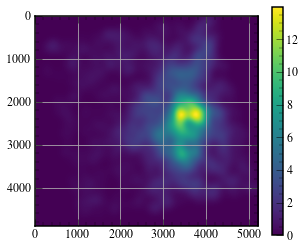

In [117]:
import scipy as sp
import scipy.ndimage

def get_density_contours(plot=False):
    WFC3_coverage = fits.open('/media/luuk/bd95ce27-c2b1-4fb8-9e9f-9b3c04a3353c/StellarVariability_Old/CentralRegionPhotometry/WFC3_Broadband/flt_files/F814W/F814_WFC3_drz.fits')[1].data
    sigma_y = 110.0
    sigma_x = 110.0

    # Create input array
    stars = np.zeros(WFC3_coverage.shape) 
    pms = wfc3_catalogue.reindex(KsollPMS_IDs).dropna()
    for i,row in pms.iterrows():
        stars[int(row.y),int(row.x)] += 1

    if plot:
        # Plot input array
        plt.imshow(stars, cmap='Blues', interpolation='nearest')
        plt.xlabel("$x$")
        plt.ylabel("$y$")
        #plt.savefig("array.png")
        plt.show()
    
    # Apply gaussian filter
    sigma = [sigma_y, sigma_x]
    y = sp.ndimage.filters.gaussian_filter(stars, sigma, mode='constant')
    # From stars per pixel to stars per square parsec
    pms_density = y / (0.01**2)
    if plot:
        plt.imshow(pms_density, cmap='Blues', interpolation='nearest')
        plt.xlabel("$x$")
        plt.ylabel("$y$")
        plt.title("$\sigma_x = " + str(sigma_x) + "\quad \sigma_y = " + str(sigma_y) + "$")
        plt.colorbar()
        plt.show()
    return pms_density
    
    #return pms
pms_density = get_density_contours()
plt.imshow(pms_density)
plt.colorbar()

In [170]:
pd.qcut(variables.loc[multifilter].groupby('ID').minmax.median().sort_values(),q=[0,0.33,0.66,1])

ID
3141.0     (0.014499999999999999, 0.141]
1273.0     (0.014499999999999999, 0.141]
2405.0     (0.014499999999999999, 0.141]
1397.0     (0.014499999999999999, 0.141]
2439.0     (0.014499999999999999, 0.141]
                       ...              
11744.0                   (0.243, 1.807]
15155.0                   (0.243, 1.807]
1291.0                    (0.243, 1.807]
5085.0                    (0.243, 1.807]
3554.0                    (0.243, 1.807]
Name: minmax, Length: 567, dtype: category
Categories (3, interval[float64]): [(0.014499999999999999, 0.141] < (0.141, 0.243] < (0.243, 1.807]]

ID
585.0      0.067287
752.0      0.143921
865.0      0.025387
943.0      0.027440
956.0      0.041713
             ...   
20742.0    0.278267
20844.0    0.241830
20898.0    0.238625
21414.0    0.202986
21432.0    0.308926
Name: minmax, Length: 567, dtype: float64

In [36]:
fullACS = ascii.read('/media/luuk/HDD/StellarVariability_Old/ResearchProject2/LargeField/HTTP.2015_10_20.1.astro').to_pandas()

In [37]:
fullACS['ID'] = np.arange(1,len(fullACS)+1)
fullACS = fullACS.set_index('ID')

In [38]:
fullACS = pd.merge(fullACS, MyID_ACS_ID, left_index=True, right_index=True).dropna().set_index('WFC3_ID')
fullACS.index.name = 'ID'

/home/luuk/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3334: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/luuk/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/luuk/anaconda3/lib/python3.8/site-packages/pandas/core/computation/expressions.py:177: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  warnings.warn(


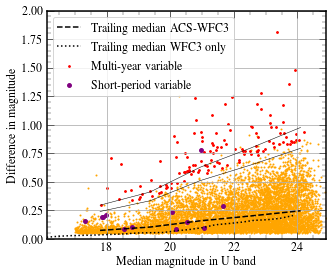

In [39]:
def long_term_u_variable():
    # Long term V variability
    U_WFC3 = df_master[['em_F336W','m_F336W','Q_F336W']]
    U_WFC3.columns = ['e336_WFC3','m336_WFC3','q336_WFC3']
    U_ACS  = fullACS[['m_f336w','e_f336w','q_f336w']]
    U_ACS.columns = ['m336_ACS','e336_ACS','q336_ACS']

    longterm_U = pd.merge(U_ACS,U_WFC3,left_index=True,right_index=True)
    longterm_U = longterm_U[np.isfinite(longterm_U)].dropna()
    longterm_U = longterm_U[(longterm_U.q336_WFC3>0.8)&(longterm_U.q336_ACS>0.8)]
    
    longterm_U['dU']  = ((longterm_U.m336_WFC3 - longterm_U.m336_ACS))
    
    # Correct for statistical effect
    median_offset = (longterm_U['dU'])[(longterm_U.q336_WFC3>=0.9)&(longterm_U.q336_ACS>=0.9)].median()
    
    longterm_U['dU'] = longterm_U['dU'].abs() - median_offset
    longterm_U['edU'] = np.sqrt(longterm_U.e336_ACS**2+longterm_U.e336_WFC3**2)
    longterm_U['MAG'] = longterm_U[['m336_ACS','m336_WFC3']].median(axis=1)
    longterm_U['tstat'] = longterm_U['dU'] / longterm_U['edU']

    total_bins=6
    bins = np.linspace(longterm_U.MAG.min(),longterm_U.MAG.max(), total_bins)
    delta = bins[1]-bins[0]
    idx  = np.digitize(longterm_U.MAG,bins)
    running_median = np.array([np.median(longterm_U.dU[idx==k]) for k in range(total_bins)])
    all_y_interp = interp_func(longterm_U['MAG'],bins, delta, running_median)
        
    longterm_U['significant'] = (longterm_U['tstat']>3)*(longterm_U['dU']>3.5*all_y_interp)
    WFC3_U_variable = variables[(variables.Filter=='F336W')].index
    
    #plt.errorbar(longterm_V.MAG,longterm_V.dV,yerr=longterm_V.edV,ls='none',ms=0.1)
    plt.figure()
    plt.scatter(longterm_U.MAG,longterm_U.dU,s=1,color='orange')
    #plt.scatter(longterm_V.MAG.reindex(pms_ids),longterm_V.dV.reindex(pms_ids),s=1,color='black',label='Known PMS')
    plt.scatter(longterm_U.MAG[longterm_U['significant']],longterm_U.dU[longterm_U['significant']],s=3,color='red',label='Multi-year variable')
    plt.scatter(longterm_U.MAG.reindex(WFC3_U_variable),longterm_U.dU.reindex(WFC3_U_variable),s=15,color='purple', label='Short-period variable')

    
    plt.plot(bins-delta/2, running_median, color='black', lw=1.5,linestyle='--',label='Trailing median ACS-WFC3')
    plt.plot(bins-delta/2, running_median*(1+1.5*1.48), color='black', lw=0.5)
    plt.plot(bins-delta/2, running_median*(1+2*1.48), color='black', lw=0.5)
    
    
    plt.plot(WFC3_running_medians['F336W'][0], WFC3_running_medians['F336W'][1], color='black', lw=1.5,linestyle='dotted',label='Trailing median WFC3 only')
    
    plt.ylim(0,2)
    plt.legend()
    plt.ylabel('Difference in magnitude')
    plt.xlabel('Median magnitude in U band')
    plt.savefig('Long_shortterm_variability_U.pdf')
    plt.show()
    
    U_variable = np.unique(np.hstack((WFC3_U_variable,longterm_U.index[longterm_U['significant']])))
    return U_variable
    
U_variable = long_term_u_variable()


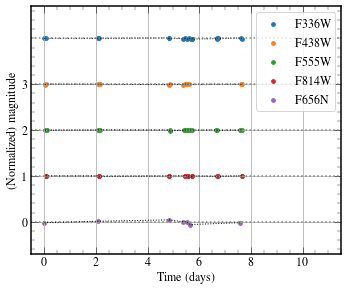

In [40]:
def plot_timeseries(df,AssocID=3554, save=False):
    plt.figure()#igsize=(8,5))
    Filter=['F336W','F438W','F555W','F814W', 'F656N']
    Filters = Filter
    filter_i = 0
    for Filter in Filters:
        
        """if Filter=='F656N':
            try:
                a = pd.read_pickle('../ResearchProject2/IRAF/Joined_BroadbandDRZ_singleHa.pickle')
                JulianDates = a.loc[AssocID, Filter].reset_index().T_Start.values
                Magnitudes  = a.loc[AssocID, Filter].MAG
                #Synth_err   = self.phot_df.loc[AssocID, Filter].SynErrorDevSig
                MAG_err     = a.loc[AssocID, Filter].MERR
                Magnitudes  = Magnitudes - np.median(Magnitudes)-filter_i+4
                plt.axhline(filter_i,xmin=0,xmax=0.75, ls='dotted', color='grey')
                filter_i+=1
                JulianDates = JulianDates - 55124.18571567
                plt.errorbar(JulianDates, Magnitudes, yerr=2*MAG_err, linestyle='none', lw=1)
                plt.scatter(JulianDates, Magnitudes,s=14, label=Filter)
            except:
                pass"""
        
        try:
            subdf = df.loc[AssocID, Filter].sort_values(by='JulianDate')
            JulianDates = subdf.reset_index().JulianDate
            JulianDates = JulianDates - 2455124.762627315
            Magnitudes  = subdf.mag
            #Synth_err   = self.phot_df.loc[AssocID, Filter].SynErrorDevSig
            MAG_err     = subdf.emag
            Magnitudes  = Magnitudes - np.median(Magnitudes)-filter_i+4
            plt.axhline(filter_i,xmin=0,xmax=1, ls='dotted', color='grey')
            filter_i+=1
            plt.errorbar(JulianDates, Magnitudes, yerr=1*MAG_err, linestyle='none', lw=2)
            plt.scatter(JulianDates, Magnitudes,s=14, label=Filter)
            plt.plot(JulianDates, Magnitudes,c='black',ls='dotted',lw=1)
        except:
            pass
        
    plt.xlim(-0.5,11.5)
    plt.ylim(-0.7,4.7)
    plt.legend(loc='upper right',fontsize=12,frameon=True)
    plt.ylabel('(Normalized) magnitude')
    plt.xlabel('Time (days)')
    plt.tight_layout()
    plt.yticks([0,1,2,3])
    #plt.scatter(JulianDates, Magnitudes, marker='o', c='black')
    if save:
        plt.savefig('example_timeseries.pdf', dpi=500, bbox_inches='tight')
    plt.show()
plot_timeseries(df_phot,1925,save=True)

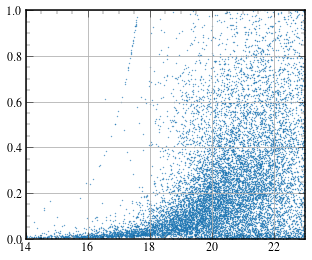

In [41]:
def Ha_err():
    plt.scatter(df_master.m_F656N,df_master.em_F656N,s=0.1)
    plt.ylim(0,1)
    plt.xlim(14,23)
Ha_err()

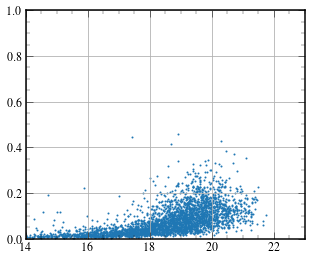

In [42]:
def Ha_err():
    df = df_phot[df_phot.index.get_level_values(1)=='F656N']
    mag = df.groupby('ID').mag.median()
    emag = df.groupby('ID').mag.std()
    plt.scatter(mag, emag,s=1)
    plt.ylim(0,1)
    plt.xlim(14,23)
Ha_err()

In [43]:
a=variables[variables.Filter=='F656N'].sort_values(by='MAD')
a.iloc[-5:].index

KeyError: 'MAD'

In [ ]:
[plot_timeseries(df_phot,save=False,AssocID=w) for w in a.iloc[-10:].index]

/home/luuk/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3334: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/luuk/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/luuk/anaconda3/lib/python3.8/site-packages/pandas/core/computation/expressions.py:177: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  warnings.warn(


3123
181


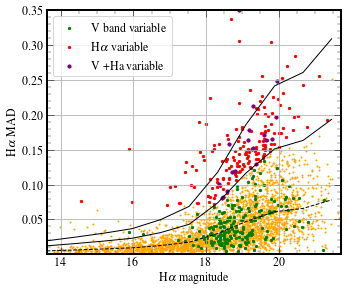

In [198]:
def MAD_Ha():
    plt.figure()
    mad = MagMadeMAD[MagMadeMAD.index.get_level_values(1)=='F656N'].MAD
    mag = MagMadeMAD[MagMadeMAD.index.get_level_values(1)=='F656N'].MAG

    total_bins = 15
    bins = np.linspace(14,25, total_bins)
    delta = bins[1]-bins[0]
    idx  = np.digitize(mag,bins)
    running_median = np.array([np.median(mad[idx==k]) for k in range(total_bins)])
    all_y_interp = interp_func(mag,bins, delta, running_median)
    two_sigma_above = all_y_interp +1*1.48*all_y_interp#+ 1.5*1.48*all_y_interp

    x = (mad>two_sigma_above)*(mag>0)*(mad>0.07)
    x = x[x].index
    print(len(mag))
    print(len(x))
    plt.scatter(mag, mad, edgecolor='orange',s=1,marker='o',facecolor='orange')
    #plt.scatter(mag.loc[x], mad.loc[x], edgecolor='red',s=0.4,marker='o',facecolor='red')
    #V_variables = variables[variables.Filter=='F555W'].index
    plt.scatter(mag.loc[V_variable], mad.loc[V_variable], edgecolor='green',s=5,marker='o',facecolor='green',label='V band variable')
    plt.scatter(mag.loc[x], mad.loc[x], edgecolor='red',s=5,marker='o',facecolor='red', label=r'H$\alpha$ variable')
    plt.scatter(mag.loc[V_variable].reindex(x), mad.loc[V_variable].reindex(x), edgecolor='purple',s=10,marker='o',facecolor='purple',label='V +Ha variable')
    plt.plot(bins-delta/2, running_median, color='black', lw=1,linestyle='--')
    plt.plot(bins-delta/2, running_median*(1+1*1.48), color='black', lw=1)
    plt.plot(bins-delta/2, running_median*(1+2*1.48), color='black', lw=1)
    plt.xlabel(r'H$\alpha$ magnitude')
    plt.ylabel(r'H$\alpha$ MAD')
    plt.legend(frameon=True)
    plt.tight_layout()
    plt.savefig('Ha_WFC3_MAD_Vvariables.pdf')
    
    return x
Ha_variables_wfc3 = MAD_Ha()


<h3>ACS HA</h3>

In [119]:
def get_minmax_q():
    Ha_visits_df = ascii.read('../ACS/halphavisits.txt').to_pandas()
    Ha_visits = Ha_visits_df.set_index(['ID','VIS']).sort_index()#,'VIS']).sort_index()
    idxmaxflux = Ha_visits.groupby('ID').FLUX.idxmax()
    idxminflux = Ha_visits.groupby('ID').FLUX.idxmin()
    qmin = pd.DataFrame({'q658min':Ha_visits.loc[idxminflux].Q1.droplevel(1)})
    qmax = pd.DataFrame({'q658max':Ha_visits.loc[idxmaxflux].Q1.droplevel(1)})
    q658_df = pd.DataFrame({'q658max':Ha_visits.loc[idxmaxflux].Q1.droplevel(1),
                            'q658min':Ha_visits.loc[idxminflux].Q1.droplevel(1)})
    return q658_df

In [121]:
def num_counts_ACS():
    Ha_visits_df = ascii.read('../ACS/halphavisits.txt').to_pandas()
    Ha_visits_df=Ha_visits_df.set_index('ID')
    a=pd.merge(Ha_visits_df, MyID_ACS_ID, left_index=True, right_index=True).dropna().set_index('WFC3_ID')
    nums = a.groupby('WFC3_ID').MUL.mean().value_counts()
    frac = (a.groupby('WFC3_ID').MUL.mean().value_counts()/a.index.nunique()*100).round(1)
    print(pd.concat((nums, frac),axis=1).to_latex())
#num_counts_ACS()

In [122]:
def load_Jphot():
    # Now we can load Elena's catalogue and inplace the WFC3 IDs in there
    Jphot_df = pd.read_pickle('../ACS/FullCatalogue.updatedWCS.pickle')
    # Join the ID systems
    Jphot_df['ID'] = np.arange(1,len(Jphot_df)+1)
    Jphot_df = Jphot_df.set_index('ID')
    Jphot_df = pd.merge(Jphot_df, MyID_ACS_ID, left_index=True, right_index=True).dropna()
    # Merge I band
    Jphot_df['m75'] = Jphot_df[['m75a','m75u']].min(axis=1)
    Jphot_df['e75'] = Jphot_df[['e75a','e75u']].min(axis=1)
    # Drop redundant columns
    Jphot_df = Jphot_df.drop(['e75a','e75u','m75a','m75u'], axis=1)
    # Get corresponding q values for minimum and maximum Ha measurements
    q658_df = get_minmax_q()
    # Merge Jphot_df with these q parameters
    Jphot_df = pd.merge(Jphot_df, q658_df, left_index=True, right_index=True)
    # Change index IDs
    Jphot_df = Jphot_df.set_index('WFC3_ID')
    # Save this df
    Jphot_df.to_pickle('Jphot_df_merged.pickle')
    return Jphot_df
try:
    Jphot_df = pd.read_pickle('Jphot_df_merged.pickle')
except:
    Jphot_df = load_Jphot()
    
Jphot_df = Jphot_df#[(Jphot_df.e658<0.15)&(Jphot_df.e555<0.1)&(Jphot_df.e75<0.1)&(Jphot_df['e658min']<0.1)&(Jphot_df['e658max']<0.1)&(Jphot_df.q555>0.75)&(Jphot_df.q658min>0.75)&(Jphot_df.q658max>0.75)]

/home/luuk/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3334: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/luuk/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


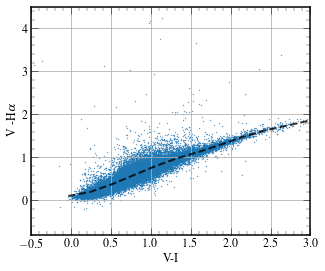

In [123]:
def referende_photometry(plot=True):
    # Now we can load Elena's catalogue and inplace the WFC3 IDs in there
    df = pd.read_pickle('../ACS/FullCatalogue.updatedWCS.pickle')
    #df2 = Jphot_df.loc[[w[0] for w in continuum_variables]].dropna()
    df['m75'] = df[['m75a','m75u']].min(axis=1)
    df['e75'] = df[['e75a','e75u']].min(axis=1)
    df = df[df.q658>0.75]
    df_clean = df[(df.q555>0.9)&(df.e555<0.1)&(df.e75<0.1)&(df.e658<0.1)].copy()
    #Jphot_df = Jphot_df[(Jphot_df.m555<90)&(Jphot_df.m658<90)&(Jphot_df.m75<90)]
    X = df_clean.m555-df_clean.m75
    Y = df_clean.m555-df_clean.m658

    #X2 = df2.m555-df2.m75
    #Y2 = df2.m555-df2.m658
    total_bins = 30
    bins = np.linspace(0.1,0.98*X.max(), total_bins)
    delta = bins[1]-bins[0]
    idx  = np.digitize(X,bins)
    running_median = np.array([np.median(Y[idx==k]) for k in range(total_bins)])
    if plot:
        plt.scatter(X, Y, s=0.1)
        #plt.scatter(X2, Y2, s=0.1,color='red')
        plt.xlim(-0.5,3)
        plt.ylim(-0.8,4.5)
        plt.xlabel('V-I')
        plt.ylabel(r'V -H$\alpha$')
        plt.plot(bins-delta/2,running_median,color='black', linestyle='dashed',lw=2,alpha=.8)
        plt.show()
    return bins, delta, running_median, df_clean, X, Y
ref_VHa_bins, ref_VHa_delta, ref_VHa_runmedian, Jphot_reference, VHa_ref, VI_ref = referende_photometry()
q658_df = pd.read_pickle('../ACS/MinMax658_Q.pickle')
Jphot_reference = pd.merge(Jphot_reference, q658_df, left_index=True, right_index=True)

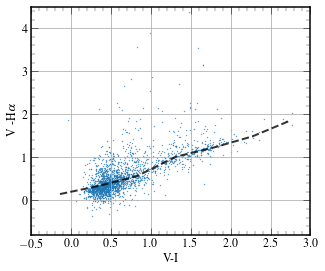

In [124]:
def referende_photometry_WFC3(plot=True):
    df = df_master
    df_clean = df[(df.em_F814W<0.1)&(df.em_F555W<0.1)&(df.em_F656N<0.2)&(df.Q_F656N>0.9)].copy()
    #Jphot_df = Jphot_df[(Jphot_df.m555<90)&(Jphot_df.m658<90)&(Jphot_df.m75<90)]
    df_clean = df_clean.dropna()
    X = df_clean.m_F555W-df_clean.m_F814W
    Y = df_clean.m_F555W-df_clean.m_F656N

    total_bins = 7
    bins = np.linspace(0.1,3, total_bins)
    delta = bins[1]-bins[0]
    idx  = np.digitize(X,bins)
    running_median = np.array([np.nanmedian(Y[idx==k]) for k in range(total_bins)])
    if plot:
        plt.scatter(X, Y, s=0.1)
        #plt.scatter(X2, Y2, s=0.1,color='red')
        plt.xlim(-0.5,3)
        plt.ylim(-0.8,4.5)
        plt.xlabel('V-I')
        plt.ylabel(r'V -H$\alpha$')
        plt.plot(bins-delta/2,running_median,color='black', linestyle='dashed',lw=2,alpha=.8)
        plt.show()
    return bins, delta, running_median, X, Y
ref_VHa_bins_WFC3, ref_VHa_delta_WFC3, ref_VHa_runmedian_WFC3, VHa_ref_WFC3, VI_ref_WFC3 = referende_photometry_WFC3()
#q658_df = pd.read_pickle('../ACS/MinMax658_Q.pickle')
#Jphot_reference = pd.merge(Jphot_reference, q658_df, left_index=True, right_index=True)

In [125]:
def get_Ha_var(df):
    # Define arrays
    Hamin = df.m658max
    Hamax = df.m658min
    Hamean = df.m658
    # Get average magnitude using minimum and maximum magnitude
    avgHamag = -2.5*np.log10(1/3*(10**(df.m658max/-2.5)+10**(df.m658/-2.5)+10**(df.m658min/-2.5)))
    # Take the V-I color 
    VI       = (df.m555 - df.m75)
    # V-Ha color predicted for no-excess
    # Derive Ha excess in min and max regime
    VHa_nex    = interp_func(VI,ref_VHa_bins, ref_VHa_delta, ref_VHa_runmedian)
    interp_Ha  = df.m555 - VHa_nex
    DeltaHamax = Hamax - interp_Ha
    DeltaHamin = Hamin - interp_Ha
    # Plusha (equivalent width)
    plusHamax= abs(10**(-0.4*DeltaHamax)-1)
    plusHamin= abs(10**(-0.4*DeltaHamin)-1)
    # Get fraction of Ha
    fracHamax= plusHamax/(1+plusHamax)
    fracHamin= plusHamin/(1+plusHamin)
    addHamax = -2.5*np.log10(fracHamax)
    addHamin = -2.5*np.log10(fracHamin)

    deltamag = Hamax + addHamax - Hamin - addHamin#np.clip(Hamax + addHamax - Hamin - addHamin,0,np.inf)

    #V_flux = 10**(-0.4*df.m555) * 1.957e-19
    #Hamaxflux = 10**(-0.4*df.m658max) * 1.964e-18 - V_flux
    #Haminflux = 10**(-0.4*df.m658min) * 1.964e-18 - V_flux
    #deltamag = 2.5*np.log10((Hamaxflux/Haminflux))

    #print(deltamag[deltamag>0])
    sigma_DeltaHamax = np.sqrt(Jphot_df.e555**2+Jphot_df.e658max**2+(0.4*Jphot_df.e555)**2+(0.4*Jphot_df.e75)**2)
    sigma_DeltaHamin = np.sqrt(Jphot_df.e555**2+Jphot_df.e658min**2+(0.4*Jphot_df.e555)**2+(0.4*Jphot_df.e75)**2)

    sigma_plusHamax = np.log(10)/2.5*abs(10**(0.4*DeltaHamax)-1)*sigma_DeltaHamax
    sigma_plusHamin = np.log(10)/2.5*abs(10**(0.4*DeltaHamin)-1)*sigma_DeltaHamin

    sigma_fracHamax = 1/((1+plusHamax)**2) * sigma_plusHamax
    sigma_fracHamin = 1/((1+plusHamin)**2) * sigma_plusHamin

    sigma_addHamax  = (2.5/np.log(10))*(1/fracHamax)*sigma_fracHamax
    sigma_addHamin  = (2.5/np.log(10))*(1/fracHamin)*sigma_fracHamin

    sigma_deltamag  = np.sqrt(Jphot_df.e658max**2+Jphot_df.e658min**2 + sigma_addHamax**2+sigma_addHamin**2)

    # Equivalent Width

    # Define arrays
    Hamin = df.m658max
    Hamax = df.m658min
    # Get average magnitude using minimum and maximum magnitude
    avgHamag = -2.5*np.log10(1/3*(10**(df.m658max/-2.5)+10**(df.m658/-2.5)+10**(df.m658min/-2.5)))
    # Take the V-I color 
    VI       = (df.m555 - df.m75)
    # V-Ha color predicted for no-excess
    # Derive Ha excess in min and max regime
    VHa_nex     = interp_func(VI,ref_VHa_bins, ref_VHa_delta, ref_VHa_runmedian)
    interp_Ha   = df.m555 - VHa_nex
    Ha_HaC_max  = - (Hamax   - interp_Ha)
    Ha_HaC_min  = - (Hamin   - interp_Ha)
    Ha_HaC_mean = - (Hamean  - interp_Ha)
    # Derive equivalent widths
    RW = 74.96
    WEQ_max  = RW * (1-10**(0.4*Ha_HaC_max))
    WEQ_min  = RW * (1-10**(0.4*Ha_HaC_min))
    WEQ_mean = RW * (1-10**(0.4*Ha_HaC_mean))

    delta_WEQ = WEQ_max - WEQ_min
    sigma_Ha_Hac_min  = np.sqrt(df.e658min**2 + (0.3*np.sqrt(df.e555**2+df.e75**2))**2)
    sigma_Ha_Hac_max  = np.sqrt(df.e658max**2 + (0.3*np.sqrt(df.e555**2+df.e75**2))**2)
    sigma_Ha_Hac_mean = np.sqrt(df.e658**2 + (0.3*np.sqrt(df.e555**2+df.e75**2))**2)
    
    eWEQ_min = RW*0.4*np.log(10)*10**(0.4*Ha_HaC_min) * sigma_Ha_Hac_min
    eWEQ_max = RW*0.4*np.log(10)*10**(0.4*Ha_HaC_max) * sigma_Ha_Hac_max
    eWEQ_mean = RW*0.4*np.log(10)*10**(0.4*Ha_HaC_mean) * sigma_Ha_Hac_mean
    sigma_dWEQ = np.sqrt(eWEQ_min**2 + eWEQ_max**2)
    
    return avgHamag, deltamag, sigma_deltamag, delta_WEQ, sigma_dWEQ, WEQ_max, WEQ_min, WEQ_mean, eWEQ_max, eWEQ_min, eWEQ_mean, Ha_HaC_max, Ha_HaC_min, Ha_HaC_mean, sigma_Ha_Hac_max, sigma_Ha_Hac_min, sigma_Ha_Hac_mean

In [126]:
(avgHamag, deltamag, sigma_deltamag, delta_eqwidth, 
           e_eqwidth, WEQ_max, WEQ_min, WEQ_mean, 
           eWEQ_max, eWEQ_min, eWEQ_mean, Ha_HaC_max, 
           Ha_HaC_min, Ha_HaC_mean, sigma_Ha_HaC_max, 
           sigma_Ha_HaC_min, sigma_Ha_HaC_mean) = get_Ha_var(Jphot_reference)
Jphot_reference['avgHamag'] = avgHamag
Jphot_reference['deltamag'] = deltamag
Jphot_reference['edeltamag'] = sigma_deltamag
Jphot_reference['delta_eqwidth'] = delta_eqwidth
Jphot_reference['edelta_eqwidth'] = e_eqwidth
Jphot_reference['eqwidth_max'] = WEQ_max
Jphot_reference['eqwidth_min'] = WEQ_min
Jphot_reference['e_eqwidth_max'] = eWEQ_max
Jphot_reference['e_eqwidth_min'] = eWEQ_min
Jphot_reference['eqwidth'] = WEQ_mean
Jphot_reference['e_eqwidth'] = eWEQ_mean
Jphot_reference['Ha_HaC_min'] = Ha_HaC_min
Jphot_reference['Ha_HaC_max'] = Ha_HaC_max
Jphot_reference['Ha_HaC_mean'] = Ha_HaC_mean
Jphot_reference['e_Ha_HaC_min'] = sigma_Ha_HaC_min
Jphot_reference['e_Ha_HaC_max'] = sigma_Ha_HaC_max
Jphot_reference['e_Ha_HaC_mean'] = sigma_Ha_HaC_mean

goodmask = Jphot_reference.index[(Jphot_reference.q658>0.75)&(Jphot_reference.e555<0.1)&(Jphot_reference.e75<0.1)&(np.sqrt((Jphot_reference.e658min)**2+(Jphot_reference.e658max)**2)<0.25)]
Jphot_reference = Jphot_reference.loc[goodmask]

(avgHamag, deltamag, sigma_deltamag, delta_eqwidth, 
           e_eqwidth, WEQ_max, WEQ_min, WEQ_mean, 
           eWEQ_max, eWEQ_min, eWEQ_mean, Ha_HaC_max, 
           Ha_HaC_min, Ha_HaC_mean, sigma_Ha_HaC_max, 
           sigma_Ha_HaC_min, sigma_Ha_HaC_mean) = get_Ha_var(Jphot_df)
Jphot_df['avgHamag'] = avgHamag
Jphot_df['deltamag'] = deltamag
Jphot_df['edeltamag'] = sigma_deltamag
Jphot_df['delta_eqwidth'] = delta_eqwidth
Jphot_df['edelta_eqwidth'] = e_eqwidth
Jphot_df['eqwidth_max'] = WEQ_max
Jphot_df['eqwidth_min'] = WEQ_min
Jphot_df['e_eqwidth_max'] = eWEQ_max
Jphot_df['e_eqwidth_min'] = eWEQ_min
Jphot_df['eqwidth'] = WEQ_mean
Jphot_df['e_eqwidth'] = eWEQ_mean
Jphot_df['Ha_HaC_min'] = Ha_HaC_min
Jphot_df['Ha_HaC_max'] = Ha_HaC_max
Jphot_df['Ha_HaC_mean'] = Ha_HaC_mean
Jphot_df['e_Ha_HaC_min'] = sigma_Ha_HaC_min
Jphot_df['e_Ha_HaC_max'] = sigma_Ha_HaC_max
Jphot_df['e_Ha_HaC_mean'] = sigma_Ha_HaC_mean
goodmask = Jphot_df.index[(Jphot_df.q658>0.75)&(Jphot_df.e555<0.1)&(Jphot_df.e75<0.1)&(Jphot_df.e658min<0.1)&(Jphot_df.e658max<0.1)&(np.sqrt((Jphot_df.e658min)**2+(Jphot_df.e658max)**2)<0.2)]
Jphot_df = Jphot_df.loc[goodmask]

INFO: Auto-setting vmin to  1.646e-01 [aplpy.core]
INFO: Auto-setting vmax to  3.091e+01 [aplpy.core]


/home/luuk/anaconda3/lib/python3.8/site-packages/astropy/visualization/stretch.py:285: RuntimeWarning: invalid value encountered in log
  np.log(values, out=values)
/home/luuk/anaconda3/lib/python3.8/site-packages/astropy/visualization/stretch.py:285: RuntimeWarning: invalid value encountered in log
  np.log(values, out=values)
/home/luuk/anaconda3/lib/python3.8/site-packages/astropy/visualization/stretch.py:285: RuntimeWarning: invalid value encountered in log
  np.log(values, out=values)
/home/luuk/anaconda3/lib/python3.8/site-packages/astropy/visualization/stretch.py:285: RuntimeWarning: invalid value encountered in log
  np.log(values, out=values)
/home/luuk/anaconda3/lib/python3.8/site-packages/astropy/visualization/stretch.py:285: RuntimeWarning: invalid value encountered in log
  np.log(values, out=values)
/home/luuk/anaconda3/lib/python3.8/site-packages/astropy/visualization/stretch.py:285: RuntimeWarning: invalid value encountered in log
  np.log(values, out=values)
/home/luuk

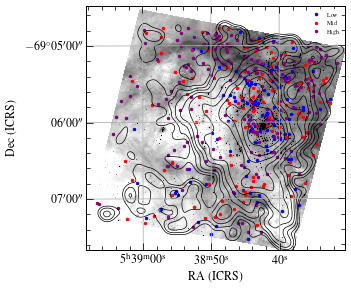

In [199]:
import aplpy
def plot_locations(df):
    variable_IDs = variables.groupby('ID')['Filter'].nunique()
    multifilter = variable_IDs.index[variable_IDs>1]
    #variable_IDs = variables[variables.Filter!='F814W'].groupby('ID')['Filter'].nunique()
    #singlefilter = variable_IDs.index[variable_IDs==1]
    var = variables.loc[multifilter].groupby('ID').minmax.median()
    var_low = var.index[var<0.141]
    var_mid = var.index[(var>0.141)&(var<0.243)]
    var_high = var.index[(var>0.243)]
    
    xl,yl = wfc3_catalogue.loc[var_low].x,wfc3_catalogue.loc[var_low].y
    xm,ym = wfc3_catalogue.loc[var_mid].x,wfc3_catalogue.loc[var_mid].y
    xh,yh = wfc3_catalogue.loc[var_high].x,wfc3_catalogue.loc[var_high].y
    #xs,ys = wfc3_catalogue.loc[singlefilter].x,wfc3_catalogue.loc[singlefilter].y
    
    WFC3_coverage = fits.open('/media/luuk/bd95ce27-c2b1-4fb8-9e9f-9b3c04a3353c/StellarVariability_Old/CentralRegionPhotometry/WFC3_Broadband/flt_files/F814W/F814_WFC3_drz.fits')[1].data
    WFC3_coverage = np.where(np.isfinite(WFC3_coverage), 1, np.nan)
    ACS_Ha_data = fits.open('/media/luuk/bd95ce27-c2b1-4fb8-9e9f-9b3c04a3353c/StellarVariability_Old/CentralRegionPhotometry/ACS_Ha/flc_files/F658N_ACS_WFC3_drz.fits')[1].data
    ACS_Ha_header = fits.open('/media/luuk/bd95ce27-c2b1-4fb8-9e9f-9b3c04a3353c/StellarVariability_Old/CentralRegionPhotometry/ACS_Ha/flc_files/F658N_ACS_WFC3_drz.fits')[1].header
    ACS_Ha_data = ACS_Ha_data * WFC3_coverage
    Vband_data = fits.open('/media/luuk/bd95ce27-c2b1-4fb8-9e9f-9b3c04a3353c/StellarVariability_Old/ResearchProject2/HST_Guido/30dorf555drz.fits')[0].data
    Vhdu = fits.ImageHDU(data=Vband_data, header=ACS_Ha_header)
    pms_hdu = fits.ImageHDU(data=pms_density, header=ACS_Ha_header)
    
    canvas = plt.figure()#figsize=(10,10))
    plt.rcParams['axes.linewidth'] = 2
    
    fig = aplpy.FITSFigure(Vhdu, figure=canvas)
    
    RAl, DECl = fig.pixel2world(xl,yl)
    RAm, DECm = fig.pixel2world(xm,ym)
    RAh, DECh = fig.pixel2world(xh,yh)
    
    fig.show_colorscale(pmin=35, pmax=99.6, stretch='log')
    fig.set_theme('publication')
    #fig.show_colorbar()
    #fig.colorbar.set_font(size=16)
    #fig.colorbar.set_axis_label_text('Number of measurements')
    #fig.colorbar.set_axis_label_font(size=17)
    #fig.tick_labels.set_font(weight='medium', \
    #                         stretch='normal', family='sans-serif', \
    #                         style='normal', variant='normal')
    #fig.axis_labels.set_font(weight='medium', \
    #                         stretch='normal', family='sans-serif', \
    #                         style='normal', variant='normal')
    fig.tick_labels.set_xformat('hh:mm:ss')
    fig.tick_labels.set_yformat('dd:mm:ss')
    fig.show_contour(pms_hdu, levels=np.logspace(-0.4,1.,10), colors='black', smooth=True, linewidths=0.7)
    plt.tight_layout()


    fig.show_markers(RAl,DECl, layer='markers_low', edgecolor='blue', facecolor='blue', marker='o', s=6, label=r'Low')
    fig.show_markers(RAm,DECm, layer='markers_mid', edgecolor='red', facecolor='red', marker='o', s=6, label=r'Mid')
    fig.show_markers(RAh,DECh, layer='markers_high', edgecolor='purple', facecolor='purple', marker='o', s=6, label=r'High')
    #fig.show_markers(RAs,DECs, layer='markers_single', edgecolor='red', facecolor='red', marker='o', s=6, label=r'Single filter')
    #fig.recenter(np.median(RA_mids)-0.012, np.median(DEC_mids)+0.013, radius=0.034)
    #plt.legend(loc='upper center', bbox_to_anchor=(0.48, +1.1),
    #fancybox=True, shadow=True, ncol=3,fontsize=5.7)
    legend = plt.legend(frameon = 1, fontsize=6)
    frame = legend.get_frame()
    frame.set_facecolor('white')
    frame.set_linewidth(0)
    plt.savefig('Vmap_with_multifilter_continuumvar.pdf', dpi=350, bbox_inches='tight')
plot_locations(Jphot_df)

2909
Total number of stars:  2845
Total number of PMS stars:  387
Five sigma stars:  83
Five sigma PMS stars:  25


<ipython-input-205-9a9412bd39a6>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['delta_eqwidth'] = df['delta_eqwidth'].abs()#[df.eqwidth>0]


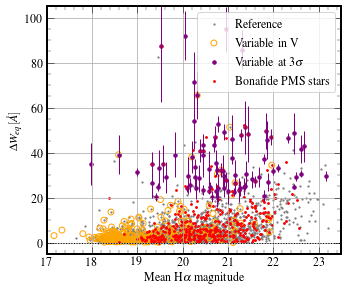

In [205]:
def plot_Ha_var(df, q_thresh, how='line'):
    try:df = df[(df.q658max>q_thresh)&(df.q658min>q_thresh)&(df.q555>q_thresh)]
    except:pass
    print(len(df))

    if how=='eqwidth':
        fig, ax = plt.subplots()
        df['delta_eqwidth'] = df['delta_eqwidth'].abs()#[df.eqwidth>0]
        #df = df.dropna()
        df = df[df.delta_eqwidth!=0]
        #df = df.dropna()
        no_pms = df.drop([w for w in df.reindex(pms_ids).dropna().index]).index
        print("Total number of stars: ",len(df))
        no_pms_x = df.loc[no_pms].avgHamag
        no_pms_y = df.loc[no_pms].delta_eqwidth
        #no_pms_e = np.sqrt((df.loc[no_pms].e658min**2 + df.loc[no_pms].e658max**2))
        ax.scatter(no_pms_x,no_pms_y, s=1.5, color='grey', label='Reference')
        #plt.errorbar(no_pms_x,no_pms_y,no_pms_e, color='grey', ls='none')

        pms_x = df.reindex(KsollPMS_IDs).avgHamag
        pms_y = df.reindex(KsollPMS_IDs).delta_eqwidth
        #ax.scatter(pms_x,pms_y, s=3, label='Bonafide PMS stars', color='red')
        print("Total number of PMS stars: ",len(pms_x.dropna()))
        
        
        all_x = df.avgHamag
        all_y = df.delta_eqwidth
        all_e = df['edelta_eqwidth']

        total_bins = 10
        bins = np.linspace(18,23, total_bins)
        delta = bins[1]-bins[0]
        idx  = np.digitize(all_x,bins)
        running_median = np.array([np.nanmedian(all_y[idx==k]) for k in range(total_bins)])
        running_std    = np.array([np.std(all_y[idx==k]) for k in range(total_bins)])

        ax.scatter(all_x.reindex(V_variable),all_y.reindex(V_variable), s=35,marker='o',facecolor='none', label=r'Variable in V', edgecolor='orange')
        all_y_interp = interp_func(all_x,bins, delta, running_median)
        five_sigma = ((all_y-all_y_interp) / all_e >=3) * (all_y>20)# * df.eqwidth_min<0
        print("Five sigma stars: ",five_sigma.sum())
        print("Five sigma PMS stars: ",np.sum(five_sigma.reindex(pms_ids).dropna()))

        ax.scatter(all_x[five_sigma],all_y[five_sigma], s=12, label=r'Variable at 3$\sigma$', color='purple')
        ax.errorbar(all_x[five_sigma],all_y[five_sigma], all_e[five_sigma], ls='none', color='purple', lw=1)
        
        ax.scatter(pms_x,pms_y, s=3, label='Bonafide PMS stars', color='red')
        ax.set_xlabel(r'Mean H$\alpha$ magnitude')#, size=15)
        ax.set_ylabel(r'$\Delta W_{eq}\, [\AA]$')#, size=15)
        
        plt.legend()#loc='upper left')
        plt.tight_layout()
        ax.axhline(0, color='black', ls='dotted', lw='1')
        #plt.semilogy()
        ax.set_ylim(-5,105)
        ax.set_xlim(17,23.5)
        plt.tight_layout()
        fig.savefig('ACS_Ha_var_centralregion.pdf',dpi=500,bbox_inches='tight')
        plt.show()
        
        return df[five_sigma]
#Jphot_variable = plot_Ha_var(Jphot_df,0.7, 'noline')
#Jphot_variable = plot_Ha_var(Jphot_df,0.75, 'line')

#ACS_Luuk_variable = plot_Ha_var(ACS_df,0.8, 'eqwidth')
Jphot_variable = plot_Ha_var(Jphot_df,0.8, 'eqwidth')
Ha_var_IDs = Jphot_variable.index

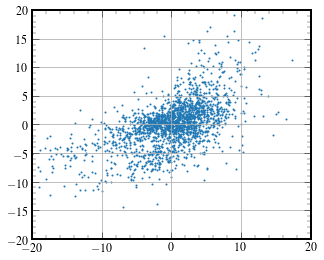

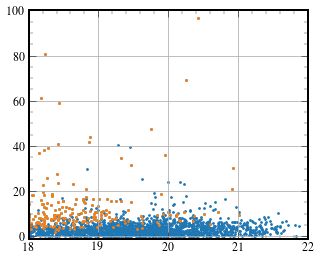

In [142]:
def compare_Ha_EW():
    WFC3 = df_master[['em_F656N','m_F656N','Q_F656N','em_F814W','m_F814W','Q_F814W','em_F555W','m_F555W','Q_F555W']]
    #WFC3.columns = ['e656_WFC3','m656_WFC3','q656_WFC3']
    ACS  = Jphot_df

    longterm_Ha = pd.merge(ACS,WFC3,left_index=True,right_index=True)
    longterm_Ha = longterm_Ha[np.isfinite(longterm_Ha)].dropna()
    longterm_Ha['AvgMag'] = -2.5*np.log10(1/2*(10**(longterm_Ha.m_F656N/-2.5)+(10**(longterm_Ha.m658/-2.5))))
    longterm_Ha = longterm_Ha[(longterm_Ha.Q_F656N>0.85)&(longterm_Ha.q658>0.85)]
    # Get eq widths
    VI_WFC3 = longterm_Ha['m_F555W'] - longterm_Ha['m_F814W']
    #VI_WFC3 = longterm_Ha['m555'] - longterm_Ha['m75']
    VHa_nex    = interp_func(VI_WFC3,ref_VHa_bins_WFC3, ref_VHa_delta_WFC3, ref_VHa_runmedian_WFC3)
    #VHa_nex    = interp_func(VI_WFC3,ref_VHa_bins, ref_VHa_delta, ref_VHa_runmedian)
    interp_Ha_WFC3  = longterm_Ha.m_F555W - VHa_nex
    longterm_Ha['Ha_Hac_WFC3'] = longterm_Ha['m_F656N'] - interp_Ha_WFC3
    RW_WFC3 = 17.68
    longterm_Ha['WEQ_WFC3'] = -RW_WFC3 * (1-10**(0.4*longterm_Ha['Ha_Hac_WFC3']))
    longterm_Ha['dWEQ'] = np.abs(longterm_Ha['WEQ_WFC3'] - longterm_Ha['eqwidth'])
    # Estimate errors
    eHa_Hac_WFC3 = np.sqrt(longterm_Ha.em_F656N**2 + (0.3*np.sqrt(longterm_Ha.em_F555W**2+longterm_Ha.em_F814W**2))**2)
    longterm_Ha['eWEQ_WFC3'] = RW_WFC3*0.4*np.log(10)*10**(0.4*longterm_Ha['Ha_Hac_WFC3']) * eHa_Hac_WFC3
    
    longterm_Ha['edWEQ'] = np.sqrt(longterm_Ha.e_eqwidth**2 + longterm_Ha.eWEQ_WFC3**2)
    longterm_Ha['tdWEQ'] = longterm_Ha['dWEQ'] / longterm_Ha['edWEQ']
    
    
    fig,ax = plt.subplots()
    plt.scatter(longterm_Ha['eqwidth'],longterm_Ha['WEQ_WFC3'],s=1)
    
    plt.xlim(-20,20)
    plt.ylim(-20,20)
    plt.show()
    
    plt.scatter(longterm_Ha['AvgMag'],np.abs(longterm_Ha['eqwidth']-longterm_Ha['WEQ_WFC3']),s=3)
    plt.scatter(longterm_Ha['AvgMag'][longterm_Ha['tdWEQ']>3],np.abs(longterm_Ha['eqwidth']-longterm_Ha['WEQ_WFC3'])[longterm_Ha['tdWEQ']>3],s=3)
    plt.xlim(18,22)
    plt.ylim(-1,100)
    plt.show()

    
    return 
compare_Ha_EW()

/home/luuk/anaconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


Five sigma stars:  45
Five sigma PMS stars:  31


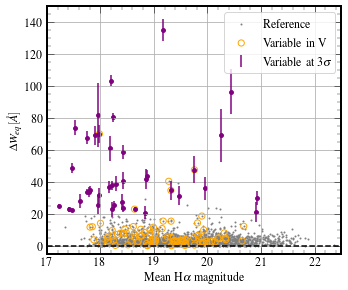

In [143]:
def long_term_Ha():
    WFC3 = df_master[['em_F656N','m_F656N','Q_F656N','em_F814W','m_F814W','Q_F814W','em_F555W','m_F555W','Q_F555W']]
    #WFC3.columns = ['e656_WFC3','m656_WFC3','q656_WFC3']
    ACS  = Jphot_df

    longterm_Ha = pd.merge(ACS,WFC3,left_index=True,right_index=True)
    longterm_Ha = longterm_Ha[np.isfinite(longterm_Ha)].dropna()
    longterm_Ha['AvgMag'] = -2.5*np.log10(1/2*(10**(longterm_Ha.m_F656N/-2.5)+(10**(longterm_Ha.m658/-2.5))))
    longterm_Ha = longterm_Ha[(longterm_Ha.Q_F656N>0.85)&(longterm_Ha.q658>0.85)]
    # Get eq widths
    VI_WFC3 = longterm_Ha['m_F555W'] - longterm_Ha['m_F814W']
    VHa_nex    = interp_func(VI_WFC3,ref_VHa_bins_WFC3, ref_VHa_delta_WFC3, ref_VHa_runmedian_WFC3)
    interp_Ha_WFC3  = longterm_Ha.m_F555W - VHa_nex
    longterm_Ha['Ha_Hac_WFC3'] = longterm_Ha['m_F656N'] - interp_Ha_WFC3
    RW_WFC3 = 17.68
    longterm_Ha['WEQ_WFC3'] = -RW_WFC3 * (1-10**(0.4*longterm_Ha['Ha_Hac_WFC3']))
    longterm_Ha['dWEQ'] = np.abs(longterm_Ha['WEQ_WFC3'] - longterm_Ha['eqwidth'])
    # Estimate errors
    eHa_Hac_WFC3 = np.sqrt(longterm_Ha.em_F656N**2 + (0.3*np.sqrt(longterm_Ha.em_F555W**2+longterm_Ha.em_F814W**2))**2)
    longterm_Ha['eWEQ_WFC3'] = RW_WFC3*0.4*np.log(10)*10**(0.4*longterm_Ha['Ha_Hac_WFC3']) * eHa_Hac_WFC3
    
    longterm_Ha['edWEQ'] = np.sqrt(longterm_Ha.e_eqwidth**2 + longterm_Ha.eWEQ_WFC3**2)

    # Estimate trailing median
    total_bins = 10
    bins = np.linspace(18,23, total_bins)
    delta = bins[1]-bins[0]
    idx  = np.digitize(longterm_Ha['AvgMag'],bins)
    running_median = np.array([np.nanmedian(longterm_Ha['dWEQ'][idx==k]) for k in range(total_bins)])
    
    all_y_interp = interp_func(longterm_Ha['AvgMag'],bins, delta, running_median)
    five_sigma = (longterm_Ha['dWEQ'] / longterm_Ha['edWEQ'] >=3)*(longterm_Ha['dWEQ']>20)
    print("Five sigma stars: ",five_sigma.sum())
    print("Five sigma PMS stars: ",np.sum(five_sigma.reindex(pms_ids).dropna()))

    
    
    # Plot differences
    fig, ax = plt.subplots()
    ax.scatter(longterm_Ha['AvgMag'],longterm_Ha['dWEQ'],s=1, color='grey', label='Reference')
    ax.scatter(longterm_Ha['AvgMag'].reindex(V_variable),longterm_Ha['dWEQ'].reindex(V_variable), s=38,marker='o',facecolor='none', label=r'Variable in V', edgecolor='orange')
    plt.errorbar(longterm_Ha['AvgMag'][five_sigma],longterm_Ha['dWEQ'][five_sigma],yerr=longterm_Ha['edWEQ'][five_sigma],ls='none', label=r'Variable at 3$\sigma$', color='purple')  
    plt.scatter(longterm_Ha['AvgMag'][five_sigma],longterm_Ha['dWEQ'][five_sigma],s=15, color='purple')  
    
    ax.axhline(0,ls='--',color='black')
    ax.set_ylim(-5,150)
    ax.set_xlim(17,22.5)
    ax.set_xlabel(r'Mean H$\alpha$ magnitude')#, size=15)
    ax.set_ylabel(r'$\Delta W_{eq}\, [\AA]$')#, size=15)
    plt.legend()#loc='upper left')
    plt.tight_layout()
    return longterm_Ha[five_sigma]
    

longterm_Ha = long_term_Ha()

/home/luuk/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3334: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/luuk/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


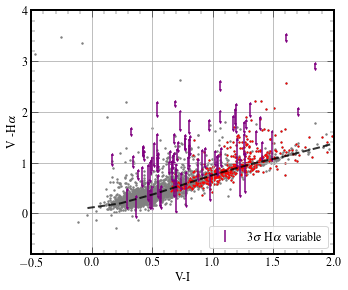

In [144]:
def plot_variable_HR(variable_df):
    plt.figure()#figsize=(8,5))
    ref_VHa_bins, ref_VHa_delta, ref_VHa_runmedian, Jphot_reference, VHa_ref, VI_ref = referende_photometry(plot=False)
    
    #clean_df_master = df_master[(df_master.Q_F555W>0.85)&(df_master.Q_F814W>0.85)&(df_master.Q_F656N>0.85)]
    #clean_df_master = wfc3_catalogue[(wfc3_catalogue.ei_2<0.07)&(wfc3_catalogue.ev_2<0.07)&(wfc3_catalogue.eha_2<0.07)]
    #clean_df_master = clean_df_master[(wfc3_catalogue.ei_2>=0)&(wfc3_catalogue.ev_2>=0)&(wfc3_catalogue.eha_2>=0)]
    #VHa_ref = (clean_df_master.v_1 - clean_df_master.ha_1)#.m555 - Jphot_df.m658)
    #VI_ref  = (clean_df_master.v_1 - clean_df_master.i_1)##(Jphot_df.m555 - Jphot_df.m75)
    
    
    #VHa_ref = (clean_df_master.m_F555W - clean_df_master.m_F656N)
    VHa_ref = Jphot_df.m555 - Jphot_df.m658
    VI_ref = Jphot_df.m555 - Jphot_df.m75
    #VI_ref  = (clean_df_master.m_F555W - clean_df_master.m_F814W)##(Jphot_df.m555 - Jphot_df.m75)
    
    #VHa_ref_pms = (ACS_pms_df.V - ACS_pms_df.Ha).loc[pms_ids].dropna()
    #VI_ref_pms  = (ACS_pms_df.V - ACS_pms_df.I).loc[pms_ids].dropna()
    #PMS_mask = (VHa_ref_pms > interp_func(VI_ref_pms, ref_VHa_bins, ref_VHa_delta, ref_VHa_runmedian))
    #VHa_ref_pms = VHa_ref_pms[PMS_mask]
    #VI_ref_pms  = VI_ref_pms[PMS_mask]
    
    
    plt.scatter(VI_ref, VHa_ref, s=2, color='grey')
    plt.scatter(VI_ref.reindex(KsollPMS_IDs), VHa_ref.reindex(KsollPMS_IDs), s=1, color='red')
    #plt.scatter(VI_ref_pms, VHa_ref_pms, s=0.8, color='red', label='Bonafide PMS')
    #plt.scatter(VI_ref_pms,VHa_ref_pms, s=1.2, color='red', label='Bonafide PMS')
    #plt.scatter(VI_ref.loc[fivesigma_continuum],VHa_ref.loc[fivesigma_continuum], s=20,marker='v', color='black', label='Continuum variables')
    
    
    
    plt.xlim(-0.5,2.)
    plt.ylim(-0.8,4.)
    
    plt.xlabel('V-I')#, size=15)
    plt.ylabel(r'V -H$\alpha$')#, size=15)
    plt.plot(ref_VHa_bins-ref_VHa_delta/2,ref_VHa_runmedian,color='black', linestyle='dashed',lw=2,alpha=.8)
    VI_variable = variable_df['m555'] - variable_df['m75']
    VHa_max = variable_df['m555']-variable_df['m658max']
    VHa_min = variable_df['m555']-variable_df['m658min']
    VHa_mean = 1/2*(VHa_max+VHa_min)
    VHa_delta = (VHa_max - VHa_min)/2
    plt.errorbar(VI_variable, VHa_mean, VHa_delta, ls='none', color='purple', label=r'$3\sigma$ H$\alpha$ variable',lw=1.5)
    plt.scatter(VI_variable, VHa_mean+VHa_delta,s=3, color='purple',marker="^")
    plt.scatter(VI_variable, VHa_mean-VHa_delta,s=3, color='purple',marker="v")
    #plt.scatter(Jphot_variable['m555'] - Jphot_variable['m75'],Jphot_variable['m555']-Jphot_variable['m658max'],s=3)
    #plt.scatter(Jphot_variable['m555'] - Jphot_variable['m75'],Jphot_variable['m555']-Jphot_variable['m658min'],s=3)
    
    plt.legend(loc='best')
    plt.tight_layout()
    plt.savefig('HR_with_variability.pdf', dpi=500, bbox_inches='tight')
    plt.show()
plot_variable_HR(Jphot_variable)

478


<ipython-input-210-cc0e404238a6>:35: RuntimeWarning: invalid value encountered in log
  return 2.5*np.log(-Y/RW-1)


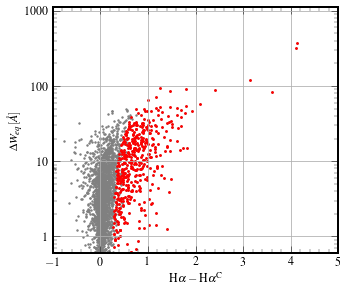

In [210]:
def deltaWEQ_vsExcess(df,q_thresh=0.8):
    try:df = df[(df.q658max>q_thresh)&(df.q658min>q_thresh)&(df.q555>q_thresh)]
    except:pass
    fig, ax = plt.subplots()
    VHamax = df.m555 - df.m658max
    VHamin = df.m555 - df.m658min
    VI = df.m555 - df.m75
    VHa_interp = interp_func(VI,ref_VHa_bins,ref_VHa_delta,ref_VHa_runmedian)
    Ha_excess_max = VHamax - VHa_interp
    Ha_excess_min = VHamin - VHa_interp
    delta_eqwidth = df.delta_eqwidth
    delta_Ha_excess = Ha_excess_max - Ha_excess_min
    mean_Ha_excess = 1/2*(Ha_excess_min+Ha_excess_max)
    
    fivesigma_excess = Ha_excess_max / df.e658max > 5
    
    excess = df[(df.eqwidth_min<-20)&(df.eqwidth_max<-20)&(df.Ha_HaC_max / df.e_Ha_HaC_max > 5)&(df.Ha_HaC_min / df.e_Ha_HaC_min > 5)].index
    print(len(excess))
    #delta_eqwidth = np.log10(df.delta_eqwidth)
    ax.scatter(Ha_excess_max,delta_eqwidth,s=2, c='grey')
    ax.scatter(Ha_excess_max.loc[excess],delta_eqwidth.loc[excess],s=3, c='red', label=r'$5\sigma$ excess')
    
    ax.set_xlim(-1,5)
    #plt.scatter(mean_Ha_excess.loc[fivesigma_excess],delta_eqwidth.loc[fivesigma_excess],s=11,marker="v", c='red', label=r'$5\sigma$ excess')
    #ax.semilogy()
    RW = 74.96
    #secax = ax.secondary_xaxis('top', functions=((lambda x: RW*(1-10**(-0.4*x))),(lambda x: -2.5*np.log10(1-x/RW))))
    

    def tick_function(X):
        Weq = RW * (1-10**(0.4*X))
        return -Weq
    
    def inv_tick_function(Y):
        return 2.5*np.log(-Y/RW-1)
    #ax2 = ax.twiny()
    #new_tick_locations = np.arange(-1,5,1)
    #ax2.set_xlim(tick_function(-1),tick_function(5))
    #ax2.set_xticks(new_tick_locations)
    #ax2.set_xscale('log')
    #ax2.set_xticklabels(tick_function(new_tick_locations))
    #ax2.set_xlabel(r"$\mathrm{max(W_{EQ})}\, [\AA]$")
    EW_ticks = np.array([0,2000,4000,6000])
    X_ticks = inv_tick_function(EW_ticks)
    #ax2.set_xticks([])
    #ax2.set_xticklabels([])
    #ax2.scatter(tick_function(Ha_excess_max),delta_eqwidth,s=2, c='grey')
    #WEQ = RW * (1-10**(-0.4x)
    #WEQ/RW -1
    #secax.set_xlabel(r'Equivalent Width [$\AA$]', size=15)
    ax.set_ylim(0.6,1.1e3)
    #ax.set_xticks(size=15)
    #ax.set_yticks(np.arange(0,3.1,1))
    ax.semilogy()
    #plt.yticks(size=15)
    ax.set_xlabel(r"$\mathrm{H\alpha - H\alpha^{C}}$")
    ax.set_ylabel(r'$\Delta W_{eq}\, [\AA]$')
    ax.set_yticks([1,10,100,1000])
    ax.set_yticklabels(['1','10','100','1000'])
    

    #plt.legend(loc='best', fontsize=14)
    plt.tight_layout()
    plt.savefig('delta_Weq_vs_Haexcess.pdf', dpi=600, bbox_inches='tight')
deltaWEQ_vsExcess(Jphot_df)

/home/luuk/anaconda3/lib/python3.8/site-packages/pandas/core/computation/expressions.py:177: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  warnings.warn(


PMS for single magnitude:  164
Newly found:  201


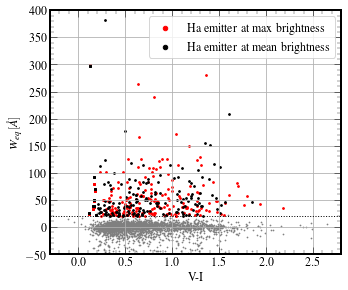

In [146]:
def EW_VI_plot(Jphot_df):
    #Jphot_df = Jphot_df[(Jphot_df.q658max>0.8)&(Jphot_df.q658>0.75)]
    plt.figure()
    x = Jphot_df.m555 - Jphot_df.m75
    y_mean = Jphot_df.eqwidth
    plt.scatter(x, y_mean, s=0.5, color='grey')
    plt.axhline(20, color='black', ls='dotted', lw='1')

    x_central = Jphot_df.m555 - Jphot_df.m75
    y_central = (-Jphot_df.eqwidth)
    e_central = Jphot_df.e_eqwidth
    y_central_max = -Jphot_df.eqwidth_max
    e_central_max = Jphot_df.e_eqwidth_max
    eHa_HaC_mean = 0.738*Jphot_df.e_Ha_HaC_mean


    PMS_cand  = (y_central>=20) * (x_central>0.2) * (Jphot_df.Ha_HaC_mean / eHa_HaC_mean >= 5)
    PMS_cand_max  = (y_central_max>=20) * (x_central>0.2) * (Jphot_df.Ha_HaC_max / Jphot_df.e_Ha_HaC_max >= 5)
    PMS_cand_AeBe  = (y_central>=20) * (x_central<=0.2) * (Jphot_df.Ha_HaC_mean / eHa_HaC_mean >= 5)
    PMS_cand_max_AeBe  = (y_central_max>=20) * (x_central<=0.2) * (Jphot_df.Ha_HaC_max / Jphot_df.e_Ha_HaC_max >= 5)

    
    new_PMS = PMS_cand_max * np.logical_not(PMS_cand)
    a = new_PMS
    a.loc[[w for w in pms_ids if w in new_PMS.index[new_PMS]]] = False
    print("PMS for single magnitude: ", np.sum(PMS_cand))
    print("Newly found: ", np.sum(new_PMS))

    plt.scatter(x_central[new_PMS], y_central_max[new_PMS], s=3, color='red', label='Ha emitter at max brightness')
    plt.scatter(x_central[PMS_cand], y_central[PMS_cand], s=3, color='black', label='Ha emitter at mean brightness')
 
    #AeBe_candidates = (x_central<0.2)*y_central>20
    #plt.scatter(x_central[AeBe_candidates], y_central[AeBe_candidates], s=15, color='purple', label='Ae/Be candidates')
    plt.scatter(x_central[PMS_cand_max_AeBe], y_central_max[PMS_cand_max_AeBe], s=3,marker='s', color='red')
    plt.scatter(x_central[PMS_cand_AeBe], y_central[PMS_cand_AeBe], s=3, color='black',marker='s')
    
    plt.ylim(-50,400)
    plt.xlabel("V-I")
    plt.ylabel(r'$W_{eq}\, [\AA]$')
    plt.tight_layout()
    lgnd = plt.legend(loc='best', numpoints=1)
    lgnd.legendHandles[0]._sizes = [20]
    lgnd.legendHandles[1]._sizes = [20]
    #lgnd.legendHandles[2]._sizes = [20]
    plt.xlim(-0.3,2.8)

    plt.savefig('EqWidth_VI.pdf', dpi=500, bbox_inches='tight')
EW_VI_plot(Jphot_df)

In [477]:
# OBSTABLE
def make_table():
    flt_list = glob('/media/luuk/bd95ce27-c2b1-4fb8-9e9f-9b3c04a3353c/StellarVariability_Old/CentralRegionPhotometry/WFC3_Broadband/flt_files/F*W/*_flt.fits')
    flt_list_ha = glob('/media/luuk/bd95ce27-c2b1-4fb8-9e9f-9b3c04a3353c/StellarVariability_Old/CentralRegionPhotometry/WFC3_Ha_all/flc_files/*_flc.fits')
    acs_list = glob('/media/luuk/bd95ce27-c2b1-4fb8-9e9f-9b3c04a3353c/StellarVariability_Old/CentralRegionPhotometry/ACS_Ha/flc_files/OrIg_files/*_flc.fits')   
    acs_VI_list = glob('/media/luuk/bd95ce27-c2b1-4fb8-9e9f-9b3c04a3353c/StellarVariability_Old/CentralRegionPhotometry/ACS_Broadband/flc_files/F*/OrIg_files/*fl*fits')
    
    flt_list = np.hstack((flt_list,acs_list,flt_list_ha,acs_VI_list))
    filters = []
    names = []
    obstimes = []
    instrument = []
    exptimes = []
    pointing = []
    for f in flt_list:
        hdu = fits.open(f)
        header = hdu[0].header
        names.append(header['ROOTNAME'])#['OBS-START']
        obstimes.append(header['DATE-OBS']+ ' ' +header['TIME-OBS'])
        exptimes.append(header['EXPTIME'])
        pointing.append(str(header['RA_TARG']) + ' '+ str(header['DEC_TARG']))
        try:
            filters.append(str(header['FILTER']))
        except:
            filters.append(str(header['FILTER1']))
        instrument.append(header['INSTRUME'])
    df = pd.DataFrame({'Instrument':instrument,'Name':names, 'Filter':filters, 'Exposure start':obstimes, 'Exposure time':exptimes, 'Pointing':pointing})
    
    df['Exposure start'] = pd.to_datetime(df['Exposure start'])
    df = df.sort_values(by='Exposure start')
    df['RA'] = df['Pointing'].str.split(' ').apply(lambda x: x[0]).astype(float)
    df['DEC'] = df['Pointing'].str.split(' ').apply(lambda x: x[1]).astype(float)
    df = df[np.sqrt((df.RA - 84.7049583)**2 + (df.DEC + 69.1023194)**2)<0.1]
    
    ACS_df = df[df.Instrument=='ACS']
    WFC_df = df[df.Instrument=='WFC3']
    ACS_df['Time difference'] = ACS_df['Exposure start'] - ACS_df['Exposure start'].iloc[0]
    WFC_df['Time difference'] = WFC_df['Exposure start'] - WFC_df['Exposure start'].iloc[0]
    df = pd.concat((WFC_df, ACS_df))
    df = df.sort_values(by='Exposure start')
    df = df[df['Exposure time']>0]
    return df[['Instrument', 'Name', 'Filter', 'Exposure time', 'Exposure start', 'Time difference']]
make_table()
#OBS_ID_table
print(make_table().to_latex(index=False))

<ipython-input-477-31418abe6b3a>:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ACS_df['Time difference'] = ACS_df['Exposure start'] - ACS_df['Exposure start'].iloc[0]
<ipython-input-477-31418abe6b3a>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  WFC_df['Time difference'] = WFC_df['Exposure start'] - WFC_df['Exposure start'].iloc[0]


\begin{tabular}{lllrlr}
\toprule
Instrument &       Name & Filter &  Exposure time &      Exposure start &   Time difference \\
\midrule
      WFC3 &  ib6wd1roq &  F336W &          400.0 & 2009-10-20 04:18:23 &   0 days 00:00:00 \\
      WFC3 &  ib6wd1rrq &  F656N &         1345.0 & 2009-10-20 04:27:25 &   0 days 00:09:02 \\
      WFC3 &  ib6wd1rxq &  F438W &          440.0 & 2009-10-20 04:52:30 &   0 days 00:34:07 \\
      WFC3 &  ib6wd1s1q &  F555W &          435.0 & 2009-10-20 05:02:21 &   0 days 00:43:58 \\
      WFC3 &  ib6wd1sdq &  F336W &          430.0 & 2009-10-20 05:37:47 &   0 days 01:19:24 \\
      WFC3 &  ib6wd1sgq &  F814W &          664.0 & 2009-10-20 05:47:25 &   0 days 01:29:02 \\
      WFC3 &  ib6wd1siq &  F814W &          664.0 & 2009-10-20 06:00:37 &   0 days 01:42:14 \\
      WFC3 &  ib6wd1smq &  F438W &          440.0 & 2009-10-20 06:14:15 &   0 days 01:55:52 \\
      WFC3 &  ib6wd1sqq &  F555W &          435.0 & 2009-10-20 06:24:06 &   0 days 02:05:43 \\
      WF

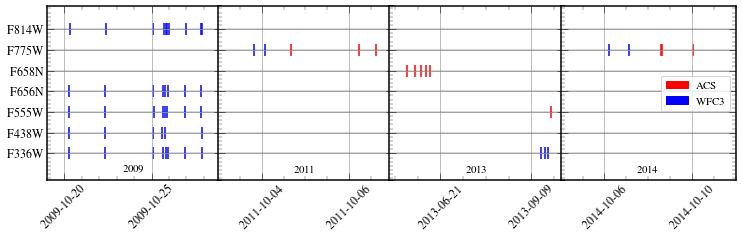

In [613]:
import datetime
def schedule_plot():
    obs_list = pd.read_csv('../EHST-Results-1603577226089.csv')
    obs_list['INSTRUMENT'] = obs_list.INSTRUMENT_NAME.apply(lambda x: 'ACS' if 'ACS' in x else 'WFC3')
    obs_list['START_TIME'] = pd.to_datetime(obs_list['START_TIME'])
    obs_list['Year'] = obs_list['START_TIME'].apply(lambda x: x.year)
    obs_list = obs_list[obs_list.TARGET_NAME.apply(lambda x: True if (x.startswith('30')+x.startswith('NGC'))==1 else False)]
    
    obs_list = obs_list[np.sqrt((obs_list.RA - 84.7049583)**2 + (obs_list.DEC + 69.1023194)**2)<0.08]
    obs_list['FILTER'] = obs_list['FILTER'].str.split(';').apply(lambda x:x[0])

    #filter_dict = {'F336W':'U','F438W':'B','F555W':'V','F656N':r'H$\alpha$','F658N':r'H$\alpha$','F775W':'I','F814W':'I'}
    #obs_list['FILTER'] = obs_list['FILTER'].apply(lambda x: filter_dict[x])
    
    
    import matplotlib.dates as mdates
    filters = np.sort(obs_list['FILTER'].unique())
    filters = ['F336W','F438W','F555W','F656N','F658N','F775W','F814W']
    cdict = {'ACS':'red','WFC3':'blue'}
    fig,(ax1,ax2,ax3,ax4) = plt.subplots(ncols=4,figsize=(10,3),sharey=True)
    for i,year in enumerate([2009,2011,2013,2014]):
        year_df = obs_list[obs_list.Year==year]
        ax = (ax1,ax2,ax3,ax4)[i]
        for height,filt_ in enumerate(filters):
            height = height
            df = year_df[year_df['FILTER']==filt_]
            
            for i,row in df.iterrows():
                ins = row.INSTRUMENT
                ax.scatter(row['START_TIME'],height,color=cdict[ins],marker="|",s=150)
                
                #for tick in ax.xaxis.get_major_ticks():
                #    tick.label.set_fontsize(11) 
            
            ax.set_ylim(-1.3,len(filters)+0.1)
            ax.set_title(year,y=0.012,size=11)
            ax.xaxis.set_major_locator(plt.MaxNLocator(2))
            xticks = ax.get_xticklabels()
            ax.tick_params(axis='x', rotation=45)

    for height,filt_ in enumerate(filters):
        for ax in (ax1,ax2,ax3,ax4):
            ax.axhline(height,lw=0.3,color='black')
            #ax.set_rasterized(True)
    ax1.set_yticks(np.arange(0,len(filters)))
    ax1.set_yticklabels(filters)
    ax1.set_xlim(datetime.date(2009, 10, 19),datetime.date(2009, 10, 29))
    ax2.set_xlim(datetime.date(2011, 10, 3),datetime.date(2011, 10, 7))
    ax3.set_xlim(datetime.date(2013, 5, 7),datetime.date(2013, 10, 8))
    ax4.set_xlim(datetime.date(2014, 10, 4),datetime.date(2014, 10, 12))
    
    
    #for tick in ax1.yaxis.get_major_ticks():
    #    tick.label.set_fontsize(11) 
    import matplotlib.patches as mpatches
    #fig.autofmt_xdate()
    legend_list = []
    legend_list.append(mpatches.Patch(color='red', label='ACS'))
    legend_list.append(mpatches.Patch(color='blue', label='WFC3'))
    # display the graph.
    ax4.legend(handles=legend_list,fontsize=11,loc='center right')
    plt.tight_layout(pad=-0.35)
    plt.savefig('Scheduling.pdf',bbox_inches='tight')#,dpi=1000)
    plt.show()
    
schedule_plot()

In [459]:
def table():
    obs_list = pd.read_csv('../EHST-Results-1603577226089.csv')
    obs_list['INSTRUMENT'] = obs_list.INSTRUMENT_NAME.apply(lambda x: 'ACS' if 'ACS' in x else 'WFC3')
    obs_list['START_TIME'] = pd.to_datetime(obs_list['START_TIME'])
    obs_list['Year'] = obs_list['START_TIME'].apply(lambda x: x.year)
    obs_list = obs_list[obs_list.TARGET_NAME.apply(lambda x: True if (x.startswith('30')+x.startswith('NGC'))==1 else False)]
    
    obs_list = obs_list[np.sqrt((obs_list.RA - 84.7049583)**2 + (obs_list.DEC + 69.1023194)**2)<0.08]
    obs_list['FILTER'] = obs_list['FILTER'].str.split(';').apply(lambda x:x[0])

    
    import matplotlib.dates as mdates
    filters = np.sort(obs_list['FILTER'].unique())
    filters = ['F336W','F438W','F555W','F656N','F658N','F775W','F814W']
    
    df = obs_list[obs_list['FILTER'].apply(lambda x: x in filters)]
    return df[['INSTRUMENT','OBSERVATION_ID','FILTER','EXPOSURE_DURATION','START_TIME']]
table()[table().INSTRUMENT=='WFC3'].sort_values(by='FILTER')

,INSTRUMENT,OBSERVATION_ID,FILTER,EXPOSURE_DURATION,START_TIME
0,WFC3,ib6wd1040,F336W,870.0,2009-10-20 06:15:43.817000
49,WFC3,ib6wr8080,F336W,870.0,2009-10-27 20:51:28.823000
32,WFC3,ib6wd6060,F336W,1775.0,2009-10-26 22:25:57.847000
200,WFC3,iby07p020,F336W,1408.0,2013-04-09 08:00:34.243000
198,WFC3,iby07o020,F336W,1408.0,2013-04-09 23:41:28.227000
5,WFC3,ib6wd2040,F336W,873.5,2009-10-25 01:58:16.857000
28,WFC3,ib6wd5050,F336W,870.0,2009-10-25 19:13:59.833000
16,WFC3,ib6wd4060,F336W,870.0,2009-10-22 07:49:03.817000
184,WFC3,iby07g020,F336W,1408.0,2013-09-21 06:21:22.537000
176,WFC3,iby07b020,F336W,1408.0,2013-09-23 23:28:23.560000


In [229]:
from astropy.timeseries import LombScargle
frequency = np.linspace(0.1, 20, 1000)
pows = np.zeros(len(frequency))
for id_ in variables[variables.Filter=='F555W'].index:
    dy = df_phot.loc[id_,'F555W'].emag
    y = df_phot.loc[id_,'F555W'].mag
    t = df_phot.loc[id_,'F555W'].JulianDate
    power = LombScargle(t, y, dy).power(frequency)
    pows += np.abs(power)

Text(0, 0.5, 'Power')

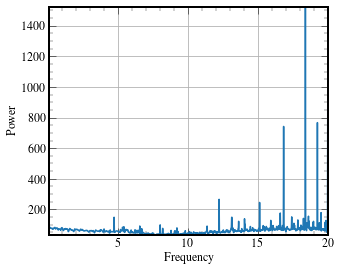

In [230]:
plt.plot(frequency,pows)
plt.xlabel('Frequency')
plt.ylabel('Power')

Int64Index([  336,  1072,  1095,  1121,  1123,  1125,  1128,  1132,  1134,
             1137,
            ...
            20210, 20230, 20331, 20696, 20708, 21138, 21799, 22078, 22146,
            22262],
           dtype='int64', name='ID', length=12973)

In [657]:
MAD = (df_phot.groupby(['ID','Filter','EpochNR'])['mag'].median() - df_phot.groupby(['ID','Filter'])['mag'].median()).abs()
MAD = MAD.groupby(['ID','Filter']).median()
MAD = MAD.unstack()[['F336W','F438W','F555W','F656N','F814W']]
BB_MAD = MAD.drop(['F336W','F438W','F656N'],axis=1).dropna()
NB_MAD = MAD.drop(['F336W','F438W'],axis=1).dropna()

(-0.013361097851338856,
 0.3897322066614315,
 -0.018196244923738548,
 0.3848970595890318)

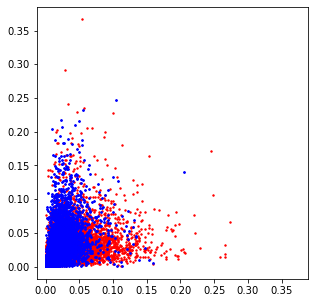

In [658]:
plt.figure(figsize=(8,5))
plt.scatter(MAD.F555W,MAD.F814W,s=2,color='red')
plt.scatter(MAD.F555W,MAD.F438W,s=2,color='blue')
plt.scatter(MAD.F555W,MAD.F438W,s=2,color='blue')
#plt.xlim(0,0.1)
#plt.ylim(0,0.1)
plt.axis('square')

In [123]:
from sklearn import datasets, linear_model
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from scipy import stats

X = BB_MAD.F555W
y = BB_MAD.F814W
X2 = sm.add_constant(X)
est = sm.OLS(y, X2)
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:                  F814W   R-squared:                       0.194
Model:                            OLS   Adj. R-squared:                  0.194
Method:                 Least Squares   F-statistic:                     3678.
Date:                Thu, 24 Sep 2020   Prob (F-statistic):               0.00
Time:                        22:39:37   Log-Likelihood:                 39779.
No. Observations:               15324   AIC:                        -7.955e+04
Df Residuals:                   15322   BIC:                        -7.954e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0111      0.000     56.090      0.0

/home/luuk/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


Text(0, 0.5, 'Ha MAD')

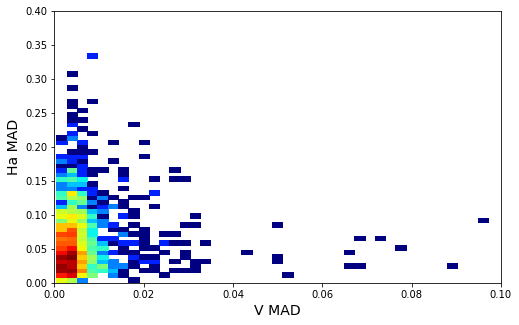

In [124]:
plt.figure(figsize=(8,5))
plt.hist2d(NB_MAD.F555W,NB_MAD.F656N,bins=50,cmap='jet', norm=LogNorm())
#plt.scatter(MAD.F555W,MAD.F656N,s=2)#, bins=35, cmap='jet', cmin=0, norm=LogNorm())
plt.xlim(0,0.1)
plt.ylim(0,0.4)
plt.xlabel('V MAD',size=14)
plt.ylabel('Ha MAD',size=14)

In [127]:
NB_MAD[(NB_MAD.F555W<0.02)&(NB_MAD.F656N>0.3)]

Filter,F555W,F656N,F814W
ID,,,
6124.0,0.003155,0.305313,0.011939
14854.0,0.008551,0.332997,0.008687
15200.0,0.007613,0.337468,0.001941


In [128]:
mags = df_phot.groupby(['ID','Filter','EpochNR'])['mag'].median()
deltaVI = (mags.loc[:,'F555W'] - mags.loc[:,'F814W']).dropna()
MAD_deltaVI = (deltaVI.groupby(['ID','EpochNR']).median() - deltaVI.groupby(['ID']).median()).abs().groupby('ID').median()

                            OLS Regression Results                            
Dep. Variable:                 MAD_VI   R-squared:                       0.314
Model:                            OLS   Adj. R-squared:                  0.314
Method:                 Least Squares   F-statistic:                     6990.
Date:                Thu, 24 Sep 2020   Prob (F-statistic):               0.00
Time:                        22:39:58   Log-Likelihood:                 34495.
No. Observations:               15264   AIC:                        -6.899e+04
Df Residuals:                   15262   BIC:                        -6.897e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0095      0.000     34.129      0.0

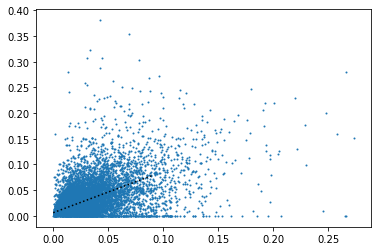

                            OLS Regression Results                            
Dep. Variable:                 MAD_VI   R-squared:                       0.260
Model:                            OLS   Adj. R-squared:                  0.260
Method:                 Least Squares   F-statistic:                     5358.
Date:                Thu, 24 Sep 2020   Prob (F-statistic):               0.00
Time:                        22:39:58   Log-Likelihood:                 33914.
No. Observations:               15264   AIC:                        -6.782e+04
Df Residuals:                   15262   BIC:                        -6.781e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0102      0.000     34.567      0.0

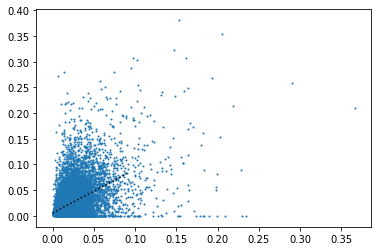

                            OLS Regression Results                            
Dep. Variable:                  F814W   R-squared:                       0.194
Model:                            OLS   Adj. R-squared:                  0.194
Method:                 Least Squares   F-statistic:                     3678.
Date:                Thu, 24 Sep 2020   Prob (F-statistic):               0.00
Time:                        22:39:59   Log-Likelihood:                 39779.
No. Observations:               15324   AIC:                        -7.955e+04
Df Residuals:                   15322   BIC:                        -7.954e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0111      0.000     56.090      0.0

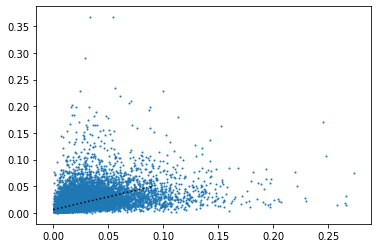

In [129]:
MAD_VI_MAD_V = pd.merge(MAD_deltaVI,BB_MAD.F555W,left_index=True,right_index=True)
MAD_VI_MAD_I = pd.merge(MAD_deltaVI,BB_MAD.F814W,left_index=True,right_index=True)
MAD_VI_MAD_V.columns = ['MAD_VI','MAD_V']
MAD_VI_MAD_I.columns = ['MAD_VI','MAD_I']
X = MAD_VI_MAD_V.MAD_V
y = MAD_VI_MAD_V.MAD_VI
X2 = sm.add_constant(X)
est = sm.OLS(y, X2)
est2 = est.fit()
print(est2.summary())
plt.scatter(MAD_VI_MAD_V.MAD_V,MAD_VI_MAD_V.MAD_VI,s=1)
plt.plot(np.arange(0,0.1,0.01),0.8027*np.arange(0,0.1,0.01)+0.006,ls='dotted',c='black')
plt.show()

X = MAD_VI_MAD_I.MAD_I
y = MAD_VI_MAD_I.MAD_VI
X2 = sm.add_constant(X)
est = sm.OLS(y, X2)
est2 = est.fit()
print(est2.summary())
plt.scatter(MAD_VI_MAD_I.MAD_I,MAD_VI_MAD_I.MAD_VI,s=1)
plt.plot(np.arange(0,0.1,0.01),0.8520*np.arange(0,0.1,0.01)+0.0054,ls='dotted',c='black')
plt.show()


X = BB_MAD.F555W
y = BB_MAD.F814W
X2 = sm.add_constant(X)
est = sm.OLS(y, X2)
est2 = est.fit()
print(est2.summary())
plt.scatter(X,y,s=1)
plt.plot(np.arange(0,0.1,0.01),0.4811*np.arange(0,0.1,0.01)+0.006,ls='dotted',c='black')

In [ ]:
# MAD V > MAD I
# MAD VI < MAD V
# MAD VI < MAD I

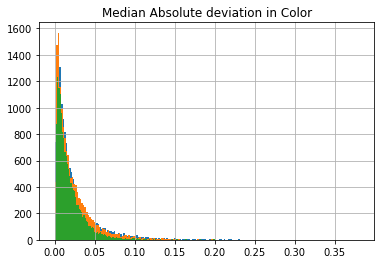

In [130]:
plt.title('Median Absolute deviation in Color')
MAD_deltaVI.groupby('ID').median().hist(bins='auto')
BB_MAD.F555W.hist(bins='auto')
BB_MAD.F814W.hist(bins='auto')

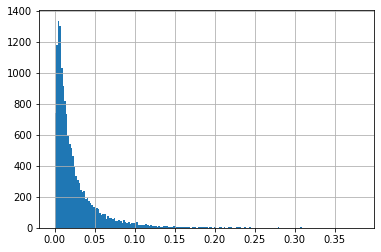

In [131]:
MAD_deltaVI.groupby('ID').median().hist(bins='auto')

In [509]:
df_phot

ObsStart  ExpTime        X        Y  \
ID      Filter OBS_ID                                                         
49.0    F656N  ib6wd1rrq 2009-10-20 06:27:25.833   1345.0  1118.14  1732.04   
               ib6wd3fdq 2009-10-25 15:15:30.840   1345.0  1118.14  1732.04   
               ib6wd6e9q 2009-10-26 22:00:37.847   1360.0  1118.14  1732.04   
               ib6wd7hdq 2009-10-25 22:00:19.830   1345.0  1118.14  1732.04   
52.0    F656N  ib6wd1rrq 2009-10-20 06:27:25.833   1345.0  1447.87   677.38   
...                                          ...      ...      ...      ...   
22262.0 F814W  ib6wd4lfq 2009-10-22 09:25:16.000    665.0  1142.12  2162.96   
               ib6wd7hvq 2009-10-25 23:18:57.000    665.0  1142.12  2162.96   
               ib6wd7hxq 2009-10-25 23:32:27.000    665.0  1142.12  2162.96   
               ib6wr8jzq 2009-10-27 21:46:13.000    665.0  1142.12  2162.96   
               ib6wr8k1q 2009-10-27 21:59:43.000    665.0  1142.12  2162.96   

                                flux    Q    Crowd        mag     emagP  \
ID      Filter OBS_ID                                                     
49.0    F656N  ib6wd1rrq  359060.344  1.0     1.70  13.826120  0.001836   
               ib6wd3fdq  355049.781  1.0     1.50  13.851123  0.001846   
               ib6wd6e9q  356412.844  1.0     1.34  13.847462  0.001843   
               ib6wd7hdq  355276.313  1.0     3.15  13.846329  0.001845   
52.0    F656N  ib6wd1rrq  331647.688  1.0     0.00  13.921398  0.001910   
...                              ...  ...      ...        ...       ...   
22262.0 F814W  ib6wd4lfq  267997.250  1.0  1495.24  18.028421  0.002125   
               ib6wd7hvq  269991.375  1.0  1751.89  18.018763  0.002117   
               ib6wd7hxq  270046.813  1.0  1587.26  18.019367  0.002117   
               ib6wr8jzq  269464.844  1.0  2130.89  18.021673  0.002119   
               ib6wr8k1q  270082.344  1.0  1845.48  18.019966  0.002117   

                         EpochNR    JulianDate      emag  \
ID      Filter OBS_ID                                      
49.0    F656N  ib6wd1rrq       1  2.455125e+06       NaN   
               ib6wd3fdq       3  2.455130e+06       NaN   
               ib6wd6e9q       6  2.455131e+06       NaN   
               ib6wd7hdq       7  2.455130e+06       NaN   
52.0    F656N  ib6wd1rrq       1  2.455125e+06       NaN   
...                          ...           ...       ...   
22262.0 F814W  ib6wd4lfq       4  2.455127e+06  0.000412   
               ib6wd7hvq       7  2.455130e+06  0.000158   
               ib6wd7hxq       7  2.455130e+06  0.000158   
               ib6wr8jzq       8  2.455132e+06  0.001757   
               ib6wr8k1q       8  2.455132e+06  0.001757   

                                                       Filenames  AperMaxVal  \
ID      Filter OBS_ID                                                          
49.0    F656N  ib6wd1rrq  ./data/ib6wd1rrq/LOGR.STACK_X1_V1.fits     44277.0   
               ib6wd3fdq  ./data/ib6wd3fdq/LOGR.STACK_X1_V1.fits     48130.0   
               ib6wd6e9q  ./data/ib6wd6e9q/LOGR.STACK_X1_V1.fits     43112.0   
               ib6wd7hdq  ./data/ib6wd7hdq/LOGR.STACK_X1_V1.fits     45553.0   
52.0    F656N  ib6wd1rrq  ./data/ib6wd1rrq/LOGR.STACK_X1_V1.fits     39576.0   
...                                                          ...         ...   
22262.0 F814W  ib6wd4lfq  ./data/ib6wd4lfq/LOGR.STACK_X1_V1.fits     36474.0   
               ib6wd7hvq  ./data/ib6wd7hvq/LOGR.STACK_X1_V1.fits     35499.0   
               ib6wd7hxq  ./data/ib6wd7hxq/LOGR.STACK_X1_V1.fits     35593.0   
               ib6wr8jzq  ./data/ib6wr8jzq/LOGR.STACK_X1_V1.fits     33329.0   
               ib6wr8k1q  ./data/ib6wr8k1q/LOGR.STACK_X1_V1.fits     36175.0   

                          RelativeMaxVal  cr_Maxclip  cr_Qclip cr_emagclip  \
ID      Filter OBS_ID                                                        
49.0    F656N  ib6wd1rrq        0.985795       False     F

Float64Index([1990.0, 1562.0, 1446.0, 2938.0, 6233.0, 3903.0], dtype='float64', name='ID')








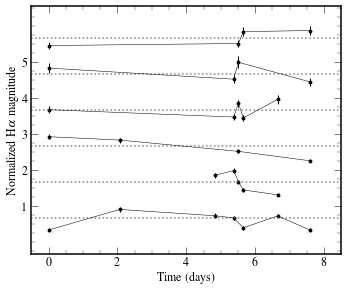

In [513]:
def plot_ha_timeseries(save=False):
    
    #wfc3_ha_df = pd.read_pickle('../ResearchProject2/IRAF/Joined_BroadbandDRZ_singleHa.pickle')
    #wfc3_ha_df = wfc3_ha_df[wfc3_ha_df.index.get_level_values(1)=='F656N']

    #toplot = wfc3_ha_df
    #print(toplot)
    """
    three_con = wfc3_ha_df[(wfc3_ha_df.index.get_level_values(2)>55129.3) * (wfc3_ha_df.index.get_level_values(2)<55130)]
    three_con = pd.DataFrame({'STDerror':three_con.groupby(['AssocID','Filter'])['MAG'].std().dropna()})
    wfc3_ha_df = pd.merge(wfc3_ha_df,three_con, left_index=True,right_index=True, how='left')

    wfc3_ha_df = wfc3_ha_df[~wfc3_ha_df.STDerror.isna()]

    nmeas = wfc3_ha_df.groupby('AssocID')['MAG'].nunique()>4
    nmeas = nmeas.index[nmeas]

    wfc3_ha_df = wfc3_ha_df.loc[nmeas]

    wfc3_ha_df['eMAG'] = np.sqrt(wfc3_ha_df['STDerror']**2+wfc3_ha_df['MERR']**2)
    
    minmax = (wfc3_ha_df.groupby('AssocID')['MAG'].max() - wfc3_ha_df.groupby('AssocID')['MAG'].min()) 
    minmax_sigma = minmax / wfc3_ha_df.groupby('AssocID')['eMAG'].median()
    mag = wfc3_ha_df.loc[minmax.index].groupby('AssocID')['MAG'].median()
    mad = np.abs(wfc3_ha_df.groupby(['AssocID','T_Start'])['MAG'].median()-wfc3_ha_df.groupby(['AssocID'])['MAG'].median()).groupby('AssocID').median()

    variable = (minmax_sigma>5)*(minmax>0.4)*(mad>0.05)

    toplot = wfc3_ha_df.loc[variable.index[variable]]

    nmeas = toplot.groupby('AssocID')['MAG'].nunique()>6
    nmeas = nmeas.index[nmeas]

    wfc3_ha_x = toplot.loc[nmeas]
    """
    toplot = MagMadeMAD.loc[Ha_variables_wfc3].sort_values(by='MAD',ascending=False)
    plt.figure()#figsize=(8,6))
    stars = toplot.index.get_level_values(0).unique()[:6]
    star_i = 1
    print(stars)
    for star in stars:
        JulianDates = df_phot.loc[star,'F656N'].reset_index()['JulianDate']
        order = np.argsort(JulianDates)
        Magnitudes  = df_phot.loc[star,'F656N'].reset_index()['mag'][order]
        #Synth_err   = self.phot_df.loc[AssocID, Filter].SynErrorDevSig
        MAG_err     = df_phot.loc[star,'F656N'].reset_index()['emagP'][order]*5
        Magnitudes  = (Magnitudes - np.median(Magnitudes)+star_i)
        print()
        plt.axhline(star_i,xmin=0,xmax=1, ls='dotted', color='grey')
        star_i+=1.5
        JulianDates = (JulianDates - 2455124.762627315)[order]
        plt.errorbar(JulianDates, Magnitudes, yerr=MAG_err, linestyle='none',lw=1, color='black')# label=Filter)
        plt.scatter(JulianDates, Magnitudes, s=8, color='black')# label=Filter)
        plt.plot(JulianDates, Magnitudes,lw=0.5, color='black')# label=Filter)

        
    #plt.legend(loc='center', fontsize=15)
    plt.ylabel(r'Normalized H$\alpha$ magnitude')
    plt.xlabel('Time (days)')
    plt.grid(False)
    plt.tight_layout()
    plt.xlim(-0.5,8.5)
    plt.yticks(np.arange(1,5.1,1)*1.5,labels=[1,2,3,4,5])
    plt.ylim(-0.5,1.5*len(stars)+0.8)
    if save:
        plt.savefig('WFC3_Ha_variability.pdf', dpi=500, bbox_inches='tight')
    plt.show()
plot_ha_timeseries(save=True)

In [135]:
def plot_HR_with_vars(df):
    from matplotlib import gridspec
    fig = plt.figure(figsize=(3, 6)) 
    gs = gridspec.GridSpec(2,1, height_ratios=[2, 1]) 
    plt.subplot(gs[0])
    
    
    df = pd.DataFrame({'MAG':df.groupby(['ID','Filter'])['mag'].median(),
                       'eMAG':df.groupby(['ID','Filter'])['emag'].mean()})
    
    df = df.unstack()
    
    print("Length our data",len(df))
   
    maxerr = 0.1
    #this_work = df.index
   
    
    all_stars_lowerr = wfc3_catalogue[(wfc3_catalogue.ei_2<0.07)&(wfc3_catalogue.ev_2<0.07)]
    all_stars_lowerr = all_stars_lowerr[(all_stars_lowerr.v_1<80)&(all_stars_lowerr.v_1>-80)&(all_stars_lowerr.i_1<80)&(all_stars_lowerr.i_1>-80)&(all_stars_lowerr.ha_1<80)&(all_stars_lowerr.ha_1>-80)]
    
    all_stars_lowerr_ha = all_stars_lowerr[all_stars_lowerr.eha_2<0.07]
    
    VI_ref = all_stars_lowerr_ha.v_1 - all_stars_lowerr_ha.i_1
    VHa_ref = all_stars_lowerr_ha.v_1 - all_stars_lowerr_ha.ha_1
    
    VI_KS2  = df[df['eMAG']<maxerr]['MAG']['F555W'] - df[df['eMAG']<maxerr]['MAG']['F814W']
    V_KS2   = df[df['eMAG']<maxerr]['MAG']['F555W']
    VHa_KS2 = df[df['eMAG']['F555W']<maxerr]['MAG']['F555W'] - df[df['eMAG']['F555W']<maxerr]['MAG']['F656N']
 
    VI_Giacomo = all_stars_lowerr.v_1 - all_stars_lowerr.i_1
    V_Giacomo  = all_stars_lowerr.v_1
    VHa_Giacomo  = all_stars_lowerr.v_1 - all_stars_lowerr.ha_1
      
    plt.scatter(VI_Giacomo, V_Giacomo,edgecolor='grey', facecolor='black', s=0.01,marker='o',alpha=1)
    
    U_var = [w[0] for w in variables if w[1]=='F336W']
    B_var = [w[0] for w in variables if w[1]=='F438W']
    V_var = [w[0] for w in variables if w[1]=='F555W']
    I_var = [w[0] for w in variables if w[1]=='F814W']
    
    
    
    plt.scatter(VI_KS2.loc[U_var], V_KS2.loc[U_var], edgecolor='purple', facecolor='purple', marker='o', s=0.5,label='F336W',alpha=0.7)
    plt.scatter(VI_KS2.loc[B_var], V_KS2.loc[B_var], edgecolor='blue', facecolor='blue', marker='o', s=0.5,label='F438W',alpha=0.7)
    plt.scatter(VI_KS2.loc[V_var], V_KS2.loc[V_var], edgecolor='green', facecolor='green', marker='o', s=0.5,label='F555W',alpha=0.7)
    plt.scatter(VI_KS2.loc[I_var], V_KS2.loc[I_var], edgecolor='red', facecolor='red', marker='o', s=0.5,label='F814W',alpha=0.7)
    
    plt.ylabel(r'V')
    plt.tight_layout()
    plt.xlim(-0.5,3)
    plt.ylim(27,16)
    plt.xticks(ticks=np.arange(-0.5,3.01,0.5),labels=7*[''])
    lgnd = plt.legend(numpoints=1,fontsize=6, loc='upper right')
    #change the marker size manually for both lines
    lgnd.legendHandles[0]._sizes = [20]
    lgnd.legendHandles[1]._sizes = [20]
    lgnd.legendHandles[2]._sizes = [20]
    lgnd.legendHandles[3]._sizes = [20]
    
    #lgnd.legendHandles[1]._colors = ['black']
    #lgnd.legendHandles[1]._alphas = [1]
    #lgnd.legendHandles[2]._sizes = [10]
    plt.subplot(gs[1])

    
    

    plt.scatter(VI_Giacomo, VHa_Giacomo,color='grey', s=0.05,marker='o',alpha=1)
    
    U_var = [w[0] for w in variables if w[1]=='F336W']
    B_var = [w[0] for w in variables if w[1]=='F438W']
    V_var = [w[0] for w in variables if w[1]=='F555W']
    I_var = [w[0] for w in variables if w[1]=='F814W']
    all_var = np.unique([w[0] for w in variables])

    
    plt.scatter(VI_KS2.loc[U_var], VHa_KS2.loc[U_var], edgecolor='purple', facecolor='purple', marker='o', s=0.5,label='F336W',alpha=0.7)
    plt.scatter(VI_KS2.loc[B_var], VHa_KS2.loc[B_var], edgecolor='blue', facecolor='blue', marker='o', s=0.5,label='F438W',alpha=0.7)
    plt.scatter(VI_KS2.loc[V_var], VHa_KS2.loc[V_var], edgecolor='green', facecolor='green', marker='o', s=0.5,label='F555W',alpha=0.7)
    plt.scatter(VI_KS2.loc[I_var], VHa_KS2.loc[I_var], edgecolor='red', facecolor='red', marker='o', s=0.5,label='F814W',alpha=0.7)
    
    total_bins = 15
    bins = np.linspace(0.2,2.4, total_bins)
    delta = bins[1]-bins[0]
    idx  = np.digitize(VI_ref,bins)
    running_median = np.array([np.median(VHa_ref[idx==k]) for k in range(total_bins)])
    
    
    VI_var = VI_KS2.loc[all_var].dropna()
    VHa_var = VHa_KS2.loc[all_var].dropna()

    
    
    var_y_interp = interp_func(VI_var, bins, delta, running_median)
    
    sigma = np.sqrt(all_stars_lowerr.ev_2.loc[VHa_var.index]**2+all_stars_lowerr.eha_2.loc[VHa_var.index]**2)
    #print(np.sum((VHa_var - (var_y_interp))>0.25))
    
    
    
    plt.plot(bins-delta/2,running_median, lw=1,ls='dotted',color='black')   
    
    plt.xlabel('V-I')
    plt.ylabel(r'V-Ha')
    plt.tight_layout()
    plt.xlim(-0.5,3)
    plt.ylim(-1,5)
    plt.yticks(np.arange(-1,5))
    lgnd = plt.legend(numpoints=1,fontsize=6, loc='upper right')
    #change the marker size manually for both lines
    lgnd.legendHandles[0]._sizes = [20]
    lgnd.legendHandles[1]._sizes = [20]
    lgnd.legendHandles[2]._sizes = [20]
    lgnd.legendHandles[3]._sizes = [20]
    
    plt.tight_layout(pad=-0.5)
    plt.savefig('Variables_continuum_CMD.pdf', dpi=500,bbox_inches='tight')
    return 
#plot_HR_with_vars(df_phot)

In [136]:
# Subtract from Ha the V band magnitudes
Ha_meas = df_phot[df_phot.index.get_level_values(1)=='F656N'].droplevel([1,2])
V_meas  = df_phot[df_phot.index.get_level_values(1)=='F555W'].droplevel([1,2])
I_meas  = df_phot[df_phot.index.get_level_values(1)=='F814W'].droplevel([1,2])

In [150]:
color_df = pd.DataFrame({'ID':[],'m_F656N':[],'m_F555W':[],'m_F814W':[],'T_F656N':[],'T_555W':[],'T_814W':[]})

In [151]:
V_stars = V_meas.index.unique()
I_stars = I_meas.index.unique()
i=0
for ID,row in Ha_meas.iterrows():
    if ID in I_stars and ID in V_stars:
        V = V_meas.loc[ID]
        I = I_meas.loc[ID]
        
        dT_V = np.argmin(np.abs(V.JulianDate - row.JulianDate).values)
        dT_I = np.argmin(np.abs(I.JulianDate - row.JulianDate).values)
        
        color_df.loc[i] = [ID,row.mag,V.mag.values[dT_V],I.mag.values[dT_I],row.JulianDate,V.JulianDate.values[dT_V],I.JulianDate.values[dT_I]]
        i+=1

In [152]:
VI = color_df.m_F555W-color_df.m_F814W
VHa = color_df.m_F555W-color_df.m_F656N

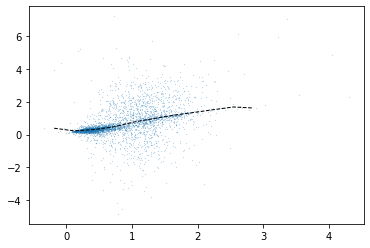

In [153]:
def get_reference():
    
    df = wfc3_catalogue[wfc3_catalogue.eha_2<0.07]
    df = df[df.ev_2<0.07]
    df = df[df.ei_2<0.07]
    df = df[(df.ha_1>10)*(df.ha_1<28)]
    df = df[(df.i_1>10)*(df.i_1<28)]
    df = df[(df.v_1>10)*(df.v_1<28)]
    #df = df[df.Q_F555W>0.8]
    #df = df[df.Q_F814W>0.8]
    VI = df.v_1 - df.i_1
    VHa = df.v_1 - df.ha_1
    plt.scatter(VI,VHa,s=0.01)
    
    total_bins = 12
    bins = np.linspace(VI.min(), 3, total_bins)
    delta = bins[1]-bins[0]
    idx  = np.digitize(VI,bins)
    running_median = np.array([np.median(VHa[idx==k]) for k in range(total_bins)])
    plt.plot(bins-delta/2, running_median, color='black', lw=1,linestyle='--')
    
    return bins,delta,running_median
bins,delta,running_median = get_reference()
y_interp = interp_func(VI,bins,delta,running_median)

In [154]:
RW = -18
color_df['WEQ']  = RW * (1-10**(0.4*(VHa - y_interp)))
color_df['VHa']  = VHa - y_interp
dWEQ = color_df.groupby('ID').WEQ.max() - color_df.groupby('ID').WEQ.min()
dMAG = color_df.groupby('ID').VHa.max() - color_df.groupby('ID').VHa.min()
mag  = color_df.groupby('ID').m_F656N.median()

Five sigma stars:  78


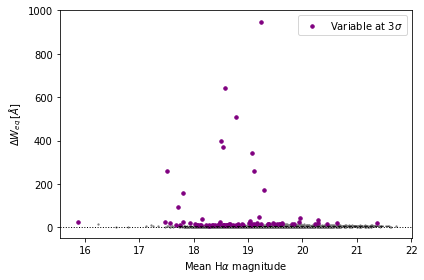

In [155]:
fig, ax = plt.subplots()

x = mag
y = dWEQ
ax.scatter(x,y, s=1.5, color='grey')


total_bins = 10
bins = np.linspace(18,23, total_bins)
delta = bins[1]-bins[0]
idx  = np.digitize(x,bins)
running_median = np.array([np.nanmedian(y[idx==k]) for k in range(total_bins)])

all_y_interp = interp_func(x,bins, delta, running_median)
five_sigma = (y/all_y_interp)>3
print("Five sigma stars: ",five_sigma.sum())


ax.scatter(x[five_sigma],y[five_sigma], s=12, label=r'Variable at 3$\sigma$', color='purple')
#ax.errorbar(mag[five_sigma],mag[five_sigma], all_e[five_sigma], ls='none', color='purple', lw=1)


ax.set_xlabel(r'Mean H$\alpha$ magnitude')#, size=15)
ax.set_ylabel(r'$\Delta W_{eq}\, [\AA]$')#, size=15)
plt.plot(bins-delta/2, running_median, color='black', lw=1,linestyle='--')
plt.legend()#loc='upper left')
plt.tight_layout()
ax.axhline(0, color='black', ls='dotted', lw='1')
#plt.semilogy()
#ax.set_ylim(-5,105)
plt.show()


Five sigma stars:  37


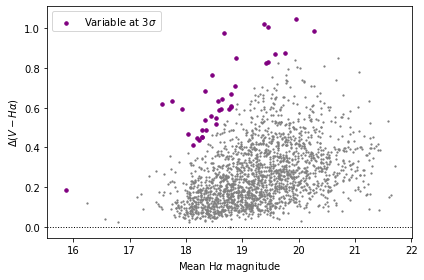

In [157]:
fig, ax = plt.subplots()
x = mag
y = dMAG

ax.scatter(x,y, s=1.5, color='grey')


total_bins = 10
bins = np.linspace(18,23, total_bins)
delta = bins[1]-bins[0]
idx  = np.digitize(x,bins)
running_median = np.array([np.nanmedian(y[idx==k]) for k in range(total_bins)])

all_y_interp = interp_func(x,bins, delta, running_median)
five_sigma = (y/all_y_interp)>3
print("Five sigma stars: ",five_sigma.sum())


ax.scatter(x[five_sigma],y[five_sigma], s=12, label=r'Variable at 3$\sigma$', color='purple')
#ax.errorbar(mag[five_sigma],mag[five_sigma], all_e[five_sigma], ls='none', color='purple', lw=1)


ax.set_xlabel(r'Mean H$\alpha$ magnitude')#, size=15)
ax.set_ylabel(r'$\Delta (V-H\alpha)$')#, size=15)
#plt.plot(bins-delta/2, running_median, color='black', lw=1,linestyle='--')
plt.legend()#loc='upper left')
plt.tight_layout()
ax.axhline(0, color='black', ls='dotted', lw='1')
#plt.semilogy()
#ax.set_ylim(-5,105)
plt.show()


Five sigma stars:  290


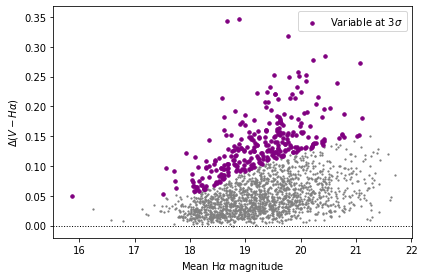

In [158]:
fig, ax = plt.subplots()
x = mag
y = (color_df.groupby(['ID','T_F656N']).VHa.median() - color_df.groupby('ID').VHa.median()).abs().groupby('ID').median()

ax.scatter(x,y, s=1.5, color='grey')


total_bins = 10
bins = np.linspace(18,23, total_bins)
delta = bins[1]-bins[0]
idx  = np.digitize(x,bins)
running_median = np.array([np.nanmedian(y[idx==k]) for k in range(total_bins)])

all_y_interp = interp_func(x,bins, delta, running_median)
five_sigma = (y/all_y_interp)>2
print("Five sigma stars: ",five_sigma.sum())


ax.scatter(x[five_sigma],y[five_sigma], s=12, label=r'Variable at 3$\sigma$', color='purple')
#ax.errorbar(mag[five_sigma],mag[five_sigma], all_e[five_sigma], ls='none', color='purple', lw=1)


ax.set_xlabel(r'Mean H$\alpha$ magnitude')#, size=15)
ax.set_ylabel(r'$\Delta (V-H\alpha)$')#, size=15)
#plt.plot(bins-delta/2, running_median, color='black', lw=1,linestyle='--')
plt.legend()#loc='upper left')
plt.tight_layout()
ax.axhline(0, color='black', ls='dotted', lw='1')
#plt.semilogy()
#ax.set_ylim(-5,105)
plt.show()


In [162]:
df=ascii.read('/media/luuk/bd95ce27-c2b1-4fb8-9e9f-9b3c04a3353c/StellarVariability_Old/ResearchProject2/LargeField/HTTP.2015_10_20.1.astro')
df=df.to_pandas()

3.758872875887288


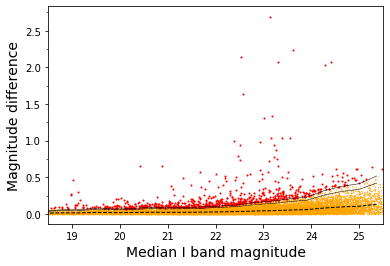

In [168]:
def long_term_I():
    a=df[(df['e_f775a']<0.05)&(df['e_f775u']<0.05)]
    a=a[(a.q_f775a>0.8)&(a.q_f775u>0.8)]
    
    minmax = np.abs(a.m_f775a - a.m_f775u)
    mag = a[['m_f775a','m_f775u']].median(axis=1)
    
    total_bins = 20#(25 if filter_ in ['F336W','F438W'] else 30)
    lower,upper = mag.quantile(.005),mag.quantile(.995)
    bins = np.linspace(lower,upper, total_bins)
    delta = bins[1]-bins[0]
    idx  = np.digitize(mag,bins)
    running_median = np.array([np.median(minmax[idx==k]) for k in range(total_bins)])
    running_median_eMAD = np.array([np.nanstd(minmax[idx==k]) for k in range(total_bins)])
    all_y_interp = interp_func(mag,bins, delta, running_median)
    two_sigma_above = all_y_interp +2*1.48*all_y_interp

    x = (minmax>two_sigma_above)*(mag>16.5)*(minmax>np.sqrt(2)*0.05)
    x = x[x].index
    print(len(x)/len(mag)*100)
    fig,ax=plt.subplots()
    plt.scatter(mag, minmax, edgecolor='orange',s=0.08,marker='o',facecolor='orange')
    plt.scatter(mag.loc[x], minmax.loc[x], edgecolor='red',s=1.,marker='o',facecolor='red')
    #plt.scatter(df.MAG.loc[wfc3_ha_x], df.MAD.loc[wfc3_ha_x], edgecolor='purple',s=2,marker='o',facecolor='purple')

    plt.plot(bins-delta/2, running_median, color='black', lw=1,linestyle='--')
    plt.plot(bins-delta/2, running_median*(1+1.5*1.48), color='black', lw=0.5)
    plt.plot(bins-delta/2, running_median*(1+2*1.48), color='black', lw=0.5)
    plt.xlim(18.5,25.5)
    
    ax.yaxis.set_minor_locator(AutoMinorLocator(2))
    plt.xlabel('Median I band magnitude',size=14)
    plt.ylabel('Magnitude difference',size=14)
    
    #plt.axvline(18.5, linestyle='dotted', color='black',linewidth=1)
    #plt.xlabel('Magnitude', size=15)
    #plt.ylabel(r'Median Absolute Deviation', size=15)
    #for star in x:
    #    variable.append((star[0], star[1],df.MAG.loc[star], df.MAD.loc[star]))
    return minmax
dI = long_term_I()

In [ ]:
# mention Poisson for Ha

In [ ]:
# what happens with std of three meas in Ha
# remake fig 9 using new data
